In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES=
%env PROJECTS_BASE=/scratch/hdd001/projects/ml4h/projects/mimic_access_required/
import sys
sys.path.append('../..')

env: CUDA_VISIBLE_DEVICES=
env: PROJECTS_BASE=/scratch/hdd001/projects/ml4h/projects/mimic_access_required/


In [2]:
%autoreload
import collections, datetime, itertools, os, time, matplotlib.pyplot as plt
import scipy.stats as ss, seaborn as sns
from sklearn.cluster.bicluster import SpectralBiclustering, SpectralCoclustering
from sklearn.cluster.hierarchical import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from sklearn.metrics import consensus_score
%matplotlib inline

from tqdm import tqdm_notebook

from latent_patient_trajectories.representation_learner.evaluator import main as eval_main
from latent_patient_trajectories.representation_learner.task_generalizability import *
from latent_patient_trajectories.representation_learner.meta_model import *
from latent_patient_trajectories.representation_learner.clustering import *
from latent_patient_trajectories.representation_learner.validate_weights import *
from latent_patient_trajectories.data_utils import *
from latent_patient_trajectories.constants import *

from matplotlib.lines import Line2D

## Constants, Reloading the model, etc.

In [267]:
OLD_COLORS = {
    'Imminent Mortality':              '#332288',
    'Comfort Measures':                '#117733',
    'DNR Ordered':                     '#44AA99',
    'ICD Code Prediction':             '#88CCEE',
    'Long LOS':                        '#DDCC77',
    '30-day Readmission':              '#CC6677',
    'Imminent Discharge':              '#AA4499',
    'Final Acuity Outcome':            '#882255',
    'Next Hour Will-be-measured':      '#1B5D41',
    'Future Treatment Sequence (FTS)': '#B59FEB',
}

OLD_MODE_COLORS = {
    'ST': '#117733',
    'MT': '#88CCEE',
    'FTF': '#CC6677',
    'FTD': 'blue',
}

OLD_ABLATIONS_TO_REPORTING_MAP = {
    'mortality': 'Imminent Mortality',
    'cmo': 'Comfort Measures',
    'dnr': 'DNR Ordered',
    'icd10': 'ICD Code Prediction',
    'los': 'Long LOS',
    'readmission': '30-day Readmission',
    'discharge': 'Imminent Discharge',
    'acuity': 'Final Acuity Outcome',
    'next_timepoint_info': 'Next Hour Will-be-measured',
    'future_treatment_sequence': 'Future Treatment Sequence (FTS)',
}

In [281]:
COLORS = {
    ABBREVIATIONS['Imminent Mortality']:              '#332288',
    ABBREVIATIONS['Comfort Measures']:                '#117733',
    ABBREVIATIONS['DNR Ordered']:                     '#44AA99',
    ABBREVIATIONS['ICD Code Prediction']:             '#88CCEE',
    ABBREVIATIONS['Long LOS']:                        '#DDCC77',
    ABBREVIATIONS['30-day Readmission']:              '#CC6677',
    ABBREVIATIONS['Imminent Discharge']:              '#AA4499',
    ABBREVIATIONS['Final Acuity Outcome']:            '#882255',
    ABBREVIATIONS['Next Hour Will-be-measured']:      '#1B5D41',
    ABBREVIATIONS['Future Treatment Sequence (FTS)']: '#B59FEB',
}

MODE_COLORS = {
    'ST': '#117733',
    'MT': '#88CCEE',
    'FTF': '#CC6677',
    'FTD': 'blue',
}
MODE_STYLES = {
    'ST':  ('dashdot', 'o'),
    'MT':  ('dotted',  '^'),
    'FTF': ('solid',   '*'),
    'FTD': ('dashed',  '+'),
}

ABLATIONS_TO_REPORTING_MAP = {
    'mortality':                 ABBREVIATIONS['Imminent Mortality'],
    'cmo':                       ABBREVIATIONS['Comfort Measures'],
    'dnr':                       ABBREVIATIONS['DNR Ordered'],
    'icd10':                     ABBREVIATIONS['ICD Code Prediction'],
    'los':                       ABBREVIATIONS['Long LOS'],
    'readmission':               ABBREVIATIONS['30-day Readmission'],
    'discharge':                 ABBREVIATIONS['Imminent Discharge'],
    'acuity':                    ABBREVIATIONS['Final Acuity Outcome'],
    'next_timepoint_info':       ABBREVIATIONS['Next Hour Will-be-measured'],
    'future_treatment_sequence': ABBREVIATIONS['Future Treatment Sequence (FTS)'],
}

TASK_ORDER = [
    ABBREVIATIONS['Imminent Mortality'],
    ABBREVIATIONS['Comfort Measures'],
    ABBREVIATIONS['DNR Ordered'],
    ABBREVIATIONS['Imminent Discharge'],
    ABBREVIATIONS['ICD Code Prediction'],
    ABBREVIATIONS['Long LOS'],
    ABBREVIATIONS['30-day Readmission'],
    ABBREVIATIONS['Final Acuity Outcome'],
    ABBREVIATIONS['Next Hour Will-be-measured'],
    ABBREVIATIONS['Future Treatment Sequence (FTS)'],
]
def sort_to_order(tasks):
    return [t for t in TASK_ORDER if t in tasks] + sorted([t for t in tasks if t not in TASK_ORDER])

## Functions

In [269]:
def transform_num_samples_col(c):
    if c[1] == 'Orig': return (c[0], 'Full-data')
    elif 'emale' in c[1]: return c
    else:
        new_s = '%.1f' % (float(c[1].split(' ')[1]) * 100)
        return ('%s Few-Shot %%' % c[0], new_s)
    
def num_samples_display_cols(df):
    df.columns = pd.MultiIndex.from_tuples(
        [transform_num_samples_col(c) for c in df.columns],
        names = df.columns.names
    )
    return df

In [270]:
def get_per_task_metrics(all_perfs, split='tuning', auprc=False):
    fn = get_manuscript_metrics_auprc if auprc else get_manuscript_metrics
    return {
        ABLATIONS_TO_REPORTING_MAP[t]: fn(m[split])*100 for t, m in all_perfs.items()
    }

def get_small_data_per_task_metrics(all_perfs, split='tuning', auprc=False):
    fn = get_manuscript_metrics_auprc if auprc else get_manuscript_metrics
    return {
        ABLATIONS_TO_REPORTING_MAP[t]: [
            data_fractions, [fn(m[split])[ABLATIONS_TO_REPORTING_MAP[t]]*100 for m in ms]
        ] for t, (data_fractions, ms) in all_perfs.items()
    }

def get_female_per_task_metrics(all_perfs, split='tuning', auprc=False):
    fn = get_manuscript_metrics_auprc if auprc else get_manuscript_metrics
    return {
        ABLATIONS_TO_REPORTING_MAP[t]: [
            data_fractions,
            [fn(m[split])[ABLATIONS_TO_REPORTING_MAP[t]]*100 for m in females],
            [fn(m[split])[ABLATIONS_TO_REPORTING_MAP[t]]*100 for m in males]
        ] for t, (data_fractions, females, males) in all_perfs.items()
    }

In [271]:
def plot_in_ensemble_perf(
    orig_metrics, pretrain_metrics, ax_perf_delta, ax_avg_task_impact,
    split='tuning', tasks = set(ABLATION_GROUPS.keys()),
    display_ticks=True, add_titles=True, row_label=None,
    add_violin_points=True, add_violin_points_jitter=False, add_violin_points_errorbars=False,
    show_legend=True, legend_right=True,
):
    # Old:
    # orig_metrics = orig_metrics['mean']

    if not add_violin_points: assert not (add_violin_points_jitter or add_violin_points_errorbars)
    
    tasks = sort_to_order([ABLATIONS_TO_REPORTING_MAP[t] for t in tasks])

    Ys = {k: [] for k in tasks}
    tasks_withheld = {k: [] for k in tasks}

    impact = {k: None for k in tasks}
    tasks_measured = {k: None for k in tasks}

    idx = pd.IndexSlice
    for omitted_task in tasks:
        m = pretrain_metrics.loc[:, idx[:, omitted_task]]
        other_tasks = sort_to_order([t for t in tasks if t != omitted_task])
        impact[omitted_task] = [
            [
                x - y for x, y in itertools.product(orig_metrics.loc[t, 'list'], m.loc[t, ('list', omitted_task)])
            ] for t in other_tasks
        ]
        tasks_measured[omitted_task] = other_tasks
        for t in other_tasks:
            Ys[t].append([
                x - y for x, y in itertools.product(m.loc[t, ('list', omitted_task)], orig_metrics.loc[t, 'list'])
            ])
            tasks_withheld[t].append(omitted_task)
        tasks_withheld[t] = sort_to_order(tasks_withheld[t])

    data = [Ys[t] for t in tasks]
    positions = np.arange(len(data))
    labels = tasks
    perf_legend_labels, perf_hs = [], []
    if add_violin_points_jitter:
        JITTERS = {t: (0.5 * i / len(tasks))-0.25 for i, t in enumerate(tasks)}

    # Violinplot
#     print(data)
#     print([list(itertools.chain.from_iterable(d)) for d in data])
    ax_perf_delta.violinplot(
        [list(itertools.chain.from_iterable(d)) for d in data], positions=positions, showmeans=True
    )
    # Scatter
    scatter  = itertools.chain.from_iterable(
        [(x, np.mean(y), np.std(y)) for y in Y] for x, Y in zip (positions, data)
    )
    ts       = itertools.chain.from_iterable(tasks_withheld[t] for t in tasks)
    pts_by_t = collections.defaultdict(list)
    for t, pt in zip(ts, scatter): pts_by_t[t].append(pt)

    for t, pts in pts_by_t.items():
        if not add_violin_points: break
   
        xx, yy, yerr = zip(*pts)
        if add_violin_points_jitter: xx = [x + JITTERS[t] for x in xx]
            
        perf_legend_labels.append('%s withheld' % t)
        perf_hs.append(ax_perf_delta.scatter(xx, yy, color=COLORS[t], zorder=10))
        if add_violin_points_errorbars:
            markers, caps, bars = ax_perf_delta.errorbar(xx, yy, yerr=yerr, ecolor=COLORS[t], fmt='none')
            [bar.set_alpha(0.35) for bar in bars]
            [cap.set_alpha(0.35) for cap in caps]

    if display_ticks:
        ax_perf_delta.set_xticks(positions)
        ax_perf_delta.set_xticklabels(labels, rotation=60, fontsize=16)
    else: ax_perf_delta.set_xticks([])
        
    perf_legend_labels.append('No change')
    perf_hs.append(ax_perf_delta.axhline(0, color='black', linestyle='dashed'))

    # ax_perf_delta.set_xlabel('Task')
    ax_perf_delta.set_ylabel('Task withheld - Original (AUROC)', fontsize=18)
    if add_titles:
        ax_perf_delta.set_title('In-distribution Task Performance\nWhen Other Tasks Withheld', fontsize=22)
#     ax_perf_delta.legend(perf_hs, perf_legend_labels, fontsize=7, loc='lower right')
    
    if row_label:
        ax_perf_delta.annotate(
            row_label, xy=(0, sum(ax_perf_delta.get_ylim())/2), fontsize=32, xytext=(-300, 0),
            textcoords='offset points',
#             xycoords=ax_perf_delta.transAxes
#             xycoords=ax.yaxis.label, textcoords='offset points', size='large', ha='right', va='center'
        )

    impact_data = [impact[t] for t in tasks]
    impact_positions = np.arange(len(impact_data))
    impact_labels = tasks
    impact_legend_labels, impact_hs = [], []

    # Violinplot
#     print(impact_data)
#     print([list(itertools.chain.from_iterable(d)) for d in impact_data])
    ax_avg_task_impact.violinplot(
        [list(itertools.chain.from_iterable(d)) for d in impact_data], positions=impact_positions,
        showmeans=True
    )

    # Scatter
    scatter  = itertools.chain.from_iterable(
        [(x, np.mean(y), np.std(y)) for y in Y] for x, Y in zip (impact_positions, impact_data)
    )
    ts       = itertools.chain.from_iterable(tasks_measured[t] for t in tasks)
    pts_by_t = collections.defaultdict(list)
    for t, pt in zip(ts, scatter): pts_by_t[t].append(pt)

    for t, pts in pts_by_t.items():
        if not add_violin_points: break
            
        xx, yy, yerr = zip(*pts)
        if add_violin_points_jitter: xx = [x + JITTERS[t] for x in xx]
        
        impact_legend_labels.append('%s omitted/measured' % t)
        impact_hs.append(ax_avg_task_impact.scatter(xx, yy, color=COLORS[t], zorder=10))
        
        if add_violin_points_errorbars:
            markers, caps, bars = ax_avg_task_impact.errorbar(xx, yy, yerr=yerr, ecolor=COLORS[t], fmt='none')
            [bar.set_alpha(0.35) for bar in bars]
            [cap.set_alpha(0.35) for cap in caps]

    if display_ticks:
        ax_avg_task_impact.set_xticks(impact_positions)
        ax_avg_task_impact.set_xticklabels(impact_labels, rotation=60, fontsize=16)
    else: ax_avg_task_impact.set_xticks([])

    # No change line
    impact_legend_labels.append('No change')
    impact_hs.append(ax_avg_task_impact.axhline(0, color='black', linestyle='dashed'))

    # ax_perf_delta.set_xlabel('Task')
    ax_avg_task_impact.set_ylabel('AUROC Improvement When Task Included', fontsize=18)
    if add_titles:
        ax_avg_task_impact.set_title('In-distribution Task Inclusion Value', fontsize=22)
        
    if show_legend:
        if legend_right:
            ax_avg_task_impact.legend(
                impact_hs, impact_legend_labels, fontsize=11, loc='upper left', bbox_to_anchor=(1.05, 1.0)
            )
        else:
            ax_avg_task_impact.legend(
                impact_hs, impact_legend_labels, fontsize=11, loc='upper right'#, bbox_to_anchor=(1.05, 1.0)
            )            
#             raise NotImplementedError("not done yet.")
            
    perf_ymin, perf_ymax     = ax_perf_delta.get_ylim()
    impact_ymin, impact_ymax = ax_avg_task_impact.get_ylim()
    global_ymin, global_ymax = min(perf_ymin, impact_ymin), max(perf_ymax, impact_ymax)
    
    ax_perf_delta.set_ylim(global_ymin, global_ymax)
    ax_avg_task_impact.set_ylim(global_ymin, global_ymax)
    
    return impact_hs, impact_legend_labels

In [272]:
DATE_VALID = datetime(2020, 5, 20)
def tasks_done(exp_dir, split='tuning', double=False, female=False, validate_date=True):
    out = []
    for task in ABLATION_GROUPS.keys():
        if female:
            fps = [
                os.path.join(
                    exp_dir,
                    '%s/%s' % (task, task) if double else task,
                    'female_%s_perf.pkl' % split
                ), os.path.join(
                    exp_dir,
                    '%s/%s' % (task, task) if double else task,
                    'male_%s_perf.pkl' % split
                )
            ]
            if all([os.path.exists(fp) for fp in fps]):
                out.append(task)
                continue
        else:
            if os.path.exists(
                os.path.join(
                    exp_dir,
                    '%s/%s' % (task, task) if double else task,
                    '%s_perf.pkl' % split
                )
            ):
                out.append(task)
                continue
            
#         valid = True
#         for fp in fps: 
#             if not os.path.isfile(fp):
#                 valid = False
#                 break
#             if validate_date and not datetime.utcfromtimestamp(os.path.getmtime(fp)) > DATE_VALID:
#                 valid = False
#                 break
#         if valid: out.append(task)
    return out

In [273]:
EXP_KEYS = {
    'gru': 'f3fd061f9c7216b77f053d92a884bea8',
    'linear': '011bae68e092df759ae1c784f148bc74',
    'self_attention': '0a87b0a83923b840442cbc187f4c9095',
}
ROW_LABELS = {
    'gru': 'GRU',
    'linear': 'Projection',
    'self_attention': 'Transformer',
}
BASES = [
    '/crimea/latent_patient_trajectories/runs/sp_20_runs/',
    '/crimea/latent_patient_trajectories/runs/sp_20_runs_1/',
    '/crimea/latent_patient_trajectories/runs/sp_20_runs_2/',
    '/crimea/latent_patient_trajectories/runs/sp_20_runs_3/',
    '/crimea/latent_patient_trajectories/runs/sp_20_runs_4/',
]
TG_DIR = 'task_generalizability'
TG_FULL_DIR = 'task_generalizability_ftencoder'
ST_DIR = 'task_generalizability_single'
FE_DIR = 'task_generalizability_female'
FE_FULL_DIR = 'task_generalizability_ftencoder_female'
FE_ST_DIR = 'task_generalizability_single_female'

MT_BASE = '/crimea/latent_patient_trajectories/runs/sp_20_runs/multi_task_runs/'

In [274]:
def split_diag_non(df, agg=True):    
    cols = list(df.columns)
    diag, non = {}, {}
    for c in cols:
        diag[c] = df.loc[c, c]
        non[c] = df.loc[c, [c2 for c2 in cols if c2 != c]]
    on = pd.Series(diag)
    on.index.names = [f"{df.index.names[0]}/{df.columns.names[0]}"]

    off = pd.DataFrame(non).T
    off.index.names = df.index.names
    off.columns.names = df.columns.names 
    
    if agg: off = off.agg(['mean', 'std', 'max', 'min', 'count', list], axis=1)
 
    return on, off

In [275]:
def transform_num_samples_col(c):
    if c[1] == 'Orig': return (c[0], 'Full-data')
    elif 'emale' in c[1]: return c
    else:
        new_s = '%.1f' % (float(c[1].split(' ')[1]) * 100)
        return ('%s Few-Shot %%' % c[0], new_s)
    
def num_samples_display_cols(df):
    df.columns = pd.MultiIndex.from_tuples(
        [transform_num_samples_col(c) for c in df.columns],
        names = df.columns.names
    )
    return df

def rest_data_num_samples(df, mode, prefix):
    if df is None:
        out = pd.DataFrame(
            {(mode, f"{prefix}: ?"): [0] * len(MANUSCRIPT_BREAKDOWN)},
            index=list(MANUSCRIPT_BREAKDOWN.keys())
        )
        return out

    out = df.loc[:, idx[:, 'count']].T.copy()
    out.index = out.index.droplevel('Aggregation Function')
    out.columns = pd.MultiIndex.from_tuples(
        [(mode, f"{prefix}: {c:.2e}") for c in out.columns]
    )
    return out

def agg_rest_data_FT(dfs):
    dfs = [df for df in dfs if df is not None and not df.empty]
    if not dfs: return None
    
    if len(dfs) == 1:
        out_df = {}
        df = dfs[0]
        
        def new_col_fn(c, agg):
            if type(df.columns) is pd.MultiIndex:
                return tuple(list(c) + [agg])
            else: return (c, agg)
        for c, vals in dfs[0].iteritems():
            out_df[new_col_fn(c, 'mean')] = vals
            out_df[new_col_fn(c, 'std')] = 0*vals
            out_df[new_col_fn(c, 'count')] = 0*vals +1
            out_df[new_col_fn(c, 'max')] = vals
            out_df[new_col_fn(c, 'min')] = vals
            out_df[new_col_fn(c, 'list')] = vals.apply(lambda x: [x])
        out_df = pd.DataFrame(out_df)
        out_df.columns.names = df.columns.names + ['Aggregation Function']
        out_df.index.names = ['% Data']
        return out_df
    
    for i, df in enumerate(dfs):
        if type(df.columns) is pd.MultiIndex:
            group_by = df.columns.names
            df.columns = pd.MultiIndex.from_tuples(
                [tuple([i] + list(c)) for c in df.columns], names=['Sample'] + df.columns.names
            )
        else:
            df.columns = pd.MultiIndex.from_tuples([(i, c) for c in df.columns], names=['Sample', 'Task'])
            group_by = ['Task']
    try:
        out_df = dfs[0].join(dfs[1:]).T.groupby(
            group_by
        ).agg(['mean', 'std', 'count', 'max', 'min', list])
        out_df.columns.names = ['% Data', 'Aggregation Function']
        out_df = out_df.T.unstack('Aggregation Function')
    except:
        globals()['error_dfs'] = dfs
        raise
    
    return out_df

def agg_diag(serieses):
    serieses = [s for s in serieses if s is not None]
    serieses = [s.reindex(MANUSCRIPT_BREAKDOWN.keys()) for s in serieses]
    return pd.DataFrame(serieses).T.agg(['mean', 'std', 'max', 'min', 'count', list], axis=1)

# def indexed_agg(dfs, op = lambda x, y: pd.DataFrame([x, y]).sum(axis=1)):
#     df1 = dfs[0]
#     for df2 in dfs[1:]:
#         df1_tasks = set(df1.index)
#         df2_tasks = set(df2.index)

#         df1_only = df1_tasks - df2_tasks
#         df2_only = df2_tasks - df1_tasks
#         shared = df1_tasks.intersection(df2_tasks)
        
#         df1.loc[shared] = op(df1.loc[shared], df2.loc[shared])
#         df1.loc[df2_only] = df2.loc[df2_only]
    
#     return df1

# def indexed_sum(dfs): return indexed_agg(dfs)
# def indexed_max(dfs): return indexed_agg(dfs, op=lambda x, y: pd.DataFrame([x, y]).sum(axis=1))
# def indexed_min(dfs): return indexed_agg(dfs, op=lambda x, y: pd.DataFrame([x, y]).sum(axis=1))

def agg_non_diag_full(dfs):
    tasks = list(MANUSCRIPT_BREAKDOWN.keys())
    dfs = [df.loc[tasks, tasks] for df in dfs if df is not None]
    
    index_name, col_name = None, None
    for df in dfs:
        if index_name is None: index_name = df.index.names
        else: assert df.index.names == index_name, str((index_name, df.columns.names))
            
        if col_name is None: col_name = df.columns.names
        else: assert df.columns.names == col_name, str((col_name, df.columns.names))
    assert len(col_name) == 1
    
    new_df = {}
    for t in tasks:
        new_df.update({
            ('mean', t): [0 for _ in tasks],
            ('std', t): [0 for _ in tasks],
            ('min', t): [float('inf') for _ in tasks],
            ('max', t): [-float('inf') for _ in tasks],
            ('count', t): [0 for _ in tasks],
            ('list', t): [[] for _ in tasks],
        })
    idxmap = {t: i for i, t in enumerate(tasks)}
        
    for df in dfs:
        for t in tasks:
            df.loc[t, t] = np.NaN
            for t2 in tasks:
                if t2 == t: continue
                new_df[('mean', t)][idxmap[t2]] += df.loc[t2, t]
                new_df[('std', t)][idxmap[t2]] += df.loc[t2, t]**2
                new_df[('min', t)][idxmap[t2]] = min(new_df[('min', t)][idxmap[t2]], df.loc[t2, t])
                new_df[('max', t)][idxmap[t2]] = max(new_df[('max', t)][idxmap[t2]], df.loc[t2, t])
                new_df[('count', t)][idxmap[t2]] += 1
                new_df[('list', t)][idxmap[t2]].append(df.loc[t2, t])
                
    new_df = pd.DataFrame(new_df, index=tasks)
    new_df['mean'] /= new_df['count']
    new_df['std'] = (new_df['std'] / new_df['count']) - new_df['mean']**2

    new_df.index.names = index_name
    new_df.columns.names = ('Aggregation Function', col_name[0])
    
    idx = pd.IndexSlice
    for t in tasks: new_df.loc[t, idx[:, t]] = np.NaN
    
    return new_df

def concat(ls):
    ls = list(ls)
    o = copy.deepcopy(ls[0])
    for l in ls[1:]:
        if type(l) is list: o.extend([e for e in copy.deepcopy(l) if not np.isnan(e)])
    return o

def agg_non_diag(dfs):
    tasks = list(MANUSCRIPT_BREAKDOWN.keys())
    dfs = [df for df in dfs if df is not None]
    dfs = [df.reindex(tasks) for df in dfs]
        
#     counts = indexed_sum([df['count'] for df in dfs])
#     means = indexed_sum([df['mean'] * df['count'] for df in dfs])/counts
#     stds = (indexed_sum(
#         [(df['std']**2 + df['mean']**2) * df['count'] for df in dfs]
#     ) / counts  - means**2) ** (1/2)
#     maxs = indexed_max([df['max'] for df in dfs])
#     mins = indexed_min([df['min'] for df in dfs])
    
#     return pd.DataFrame({
#         'mean': means, 'std': stds, 'max': maxs, 'min': mins, 'count': counts
#     })

    counts = pd.DataFrame([df['count'] for df in dfs]).sum(axis=0)
    means = pd.DataFrame([df['mean'] * df['count'] for df in dfs]).sum(axis=0)/counts
    stds = (pd.DataFrame(
        [(df['std']**2 + df['mean']**2) * df['count'] for df in dfs]
    ).sum(axis=0) / counts  - means**2) ** (1/2)
    maxs = pd.DataFrame([df['max'] for df in dfs]).max(axis=0)
    mins = pd.DataFrame([df['min'] for df in dfs]).min(axis=0)
    
    ldf = pd.DataFrame([df['list'] for df in dfs])
#     ldf = ldf.applymap(
#         lambda x: [e for e in x if not np.isnan(e)] if type(x) is list else [] if np.isnan(x) else x
#     )
#     display(ldf)
#     globals()['aa'] = ldf
    lists = ldf.agg(concat, axis=0)
    
    return pd.DataFrame({
        'mean': means, 'std': stds, 'max': maxs, 'min': mins, 'count': counts
    })

SyntaxError: invalid syntax (<ipython-input-275-af48b2a42ab7>, line 13)

In [276]:
def read_all_perf_metrics(
    exp_dir,
    full_model_dir = None,
    datasets = ('tuning',),# 'test'),
    tasks = set(ABLATION_GROUPS.keys()),
    expecting_fine_tune = True,
    expecting_inclusion_perfs = True,
):
    if full_model_dir:
        full_model_perfs = {d: depickle(os.path.join(full_model_dir, '%s_perf.pkl' % d)) for d in datasets}
    else: full_model_perfs = None
    assert set(tasks).issubset(set(ABLATION_GROUPS.keys()))
    
    all_perfs = {}
    fine_tune_perfs = {}
    for task in tasks:
        task_dir = os.path.join(exp_dir, task)
        if not all(os.path.exists(os.path.join(task_dir, '%s_perf.pkl' % d)) for d in datasets):
            if expecting_inclusion_perfs: print("Missing %s" % task_dir)
        else:
            all_perfs[task] = {d: depickle(os.path.join(task_dir, '%s_perf.pkl' % d)) for d in datasets}
        
        if not expecting_fine_tune: continue
        fine_tune_dir = os.path.join(task_dir, task)
        if not (
            os.path.isdir(fine_tune_dir) and
            all(os.path.isfile(os.path.join(fine_tune_dir, '%s_perf.pkl' % d)) for d in datasets)
        ): 
            print("Missing %s" % fine_tune_dir)
            continue
        fine_tune_perfs[task] = {d: depickle(os.path.join(fine_tune_dir, '%s_perf.pkl' % d)) for d in datasets}
    return full_model_perfs, all_perfs, fine_tune_perfs

def read_small_data_perf_metrics(
    exp_dir,
    datasets = ('tuning',),# 'test'),
    tasks = set(ABLATION_GROUPS.keys()),
):
    print(exp_dir, tasks)
    assert set(tasks).issubset(set(ABLATION_GROUPS.keys()))
    
    small_data_perfs = {}
    for task in tasks:
        task_dir            = os.path.join(exp_dir, task)
        if 'sp_20_runs/' in exp_dir: desired_suffix = '_1'
        elif 'sp_20_runs_1/' in exp_dir: desired_suffix = '_2'
        elif 'sp_20_runs_2/' in exp_dir: desired_suffix = '_3'
        elif 'sp_20_runs_3/' in exp_dir: desired_suffix = '_4'
        elif 'sp_20_runs_4/' in exp_dir: desired_suffix = '_5'
        else: assert False
            
        downstream_dirnames = [
            fn for fn in os.listdir(task_dir) if (
                fn.startswith(f"{task}_0-") and fn.endswith(desired_suffix)
            )
        ]
        small_data_perfs[task] = [[], []]

        for fn in downstream_dirnames:
            fine_tune_dir = os.path.join(task_dir, fn)
            try:
                data_fraction = float("0.%s" % fn.split('_')[-2][2:])
            except Exception as e:
                print(fine_tune_dir, 'failed!')
                raise
            if not (
                os.path.isdir(fine_tune_dir) and
                all(os.path.isfile(os.path.join(fine_tune_dir, '%s_perf.pkl' % d)) for d in datasets)
            ): 
                print("Missing %s" % fine_tune_dir)
#                 print(os.path.isdir(fine_tune_dir))
#                 print(datasets)
#                 print(os.listdir(fine_tune_dir))
                continue
            small_data_perfs[task][0].append(data_fraction)
            small_data_perfs[task][1].append(
                {d: depickle(os.path.join(fine_tune_dir, '%s_perf.pkl' % d)) for d in datasets}
            )
        idx = np.argsort(small_data_perfs[task][0])
        small_data_perfs[task] = [list(np.array(v)[idx]) for v in small_data_perfs[task]]
    return small_data_perfs

def read_female_perf_metrics(
    exp_dir,
    datasets = ('tuning',),# 'test'),
    tasks = set(ABLATION_GROUPS.keys()),
):
    assert set(tasks).issubset(set(ABLATION_GROUPS.keys()))
    
    female_perfs = {}
    for task in tasks:
        female_perfs[task] = [[], [], []]

        task_dir = os.path.join(exp_dir, task)
        if not os.path.isdir(task_dir): continue
            
        downstream_dirnames = [fn for fn in os.listdir(task_dir) if fn.startswith(f"{task}_F0")]
        for fn in downstream_dirnames:
            fine_tune_dir = os.path.join(task_dir, fn)
            data_fraction = float("0.%s" % fn.split('_')[-2][3:])
            if not (
                os.path.isdir(fine_tune_dir)
                and all(os.path.isfile(os.path.join(fine_tune_dir, 'female_%s_perf.pkl' % d)) for d in datasets)
                and all(os.path.isfile(os.path.join(fine_tune_dir, 'male_%s_perf.pkl' % d)) for d in datasets) 
            ): 
                print("Missing %s" % fine_tune_dir)
                continue
            female_perfs[task][0].append(data_fraction)
            female_perfs[task][1].append(
                {d: depickle(os.path.join(fine_tune_dir, 'female_%s_perf.pkl' % d)) for d in datasets}
            )
            female_perfs[task][2].append(
                {d: depickle(os.path.join(fine_tune_dir, 'male_%s_perf.pkl' % d)) for d in datasets}
            )
        idx = np.argsort(female_perfs[task][0])
        female_perfs[task] = [list(np.array(v)[idx]) for v in female_perfs[task]]
    return female_perfs

In [277]:
def get_single_task_metrics_single(st_base, exp_key, split='tuning', auprc = False):
    final_dir = os.path.join(st_base, 'v0', exp_key, EXP_KEYS[exp_key], '0')
    small_data_metrics = read_small_data_perf_metrics(
        exp_dir=final_dir, datasets=(split,)
    )
    small_data_results = get_small_data_per_task_metrics(small_data_metrics, split, auprc=auprc)
    small_data_results = pd.DataFrame({k: pd.Series(v[1], index=v[0]) for k, v in small_data_results.items()})
    small_data_results.index.names = ['% Data']
    small_data_results.columns.names = ['Task']

    tasks = tasks_done(final_dir, double=True)
    if not tasks or len(tasks) == 1: return small_data_results, (None, None)
    validate_all(final_dir, single_task=True, tasks=tasks)

    _, _, all_samples = read_all_perf_metrics(
        exp_dir=final_dir, full_model_dir=None, tasks=tasks, datasets=(split,), expecting_inclusion_perfs=False
    )
    
    M = pd.DataFrame(get_per_task_metrics(all_samples, split, auprc=auprc))
    M.index.names = ['Measured Task']
    M.columns.names = ['Single-task Trained Task']
    idx_tasks = [ABLATIONS_TO_REPORTING_MAP[t] for t in tasks]
    
    return small_data_results, split_diag_non(M.loc[idx_tasks, idx_tasks])

def get_single_task_metrics(exp_key, split='tuning', auprc=False):
    small_data, diags, non_diags = [], [], []
    for base in BASES:
        out_small_data, (out_diag, out_non_diag) = get_single_task_metrics_single(
            os.path.join(base, ST_DIR), exp_key, split, auprc=auprc
        )
        small_data.append(out_small_data)
        diags.append(out_diag)
        non_diags.append(out_non_diag)

    return agg_rest_data_FT(small_data), agg_diag(diags), agg_non_diag(non_diags)

In [238]:
foo = {}

In [251]:
def get_gender(df, g='M-F Disparity'):
    if df is None: return None
    out = df.loc[:, idx[:, g, :]].copy()
    out.columns = out.columns.droplevel('Gender')
    return out
def get_female_metrics_single(base, exp_key, split='tuning', full=False, single_task=False, auprc=False):
    final_dir = os.path.join(base, 'v0', exp_key, EXP_KEYS[exp_key], '0')
    tasks = list(ABLATION_GROUPS.keys()) # tasks_done(final_dir, female=True, double=True)
    if not tasks: return None
#     validate_all(final_dir, single_task=single_task, ft_encoder=full, tasks=tasks)

    female_metrics = read_female_perf_metrics(exp_dir=final_dir, tasks=tasks, datasets=(split,))
    
    female_results = get_female_per_task_metrics(female_metrics, split, auprc=auprc)
    female_results = pd.DataFrame({
        **{(k, 'Female'): pd.Series(v[1], index=v[0]) for k, v in female_results.items()},   
        **{(k, 'Male'):   pd.Series(v[2], index=v[0]) for k, v in female_results.items()},   
    })
    female_results.index.names = ['% Data']
    female_results.columns.names = ['Task', 'Gender']
    print(final_dir, female_results)
    globals()['foo'][final_dir] = female_metrics
    
    for t in tasks:
        task = ABLATIONS_TO_REPORTING_MAP[t]
        female_results[(task, 'M-F Disparity')] = (
            female_results[(task, 'Male')] - female_results[(task, 'Female')]
        )
        
    return female_results

def get_female_metrics(exp_key, split='tuning', full=False, single_task=False, auprc=False):
    assert not (full and single_task)
    D = FE_FULL_DIR if full else FE_ST_DIR if single_task else FE_DIR
    female_FT = []
    for base in BASES:
        female_FT.append(
            get_female_metrics_single(
                os.path.join(base, D), exp_key, split, full, single_task, auprc=auprc
            )
        )
        
    return agg_rest_data_FT(female_FT)

In [240]:
def get_fine_tune_metrics_single(base, exp_key, split='tuning', full=False, auprc=False):
    final_dir = os.path.join(base, 'v0', exp_key, EXP_KEYS[exp_key], '0')
    
    tasks = tasks_done(final_dir, double=full)
    if not tasks: return None, (None, None), (None, None),
    try:
        validate_all(final_dir, single_task=False, ft_encoder=full, tasks=tasks)
    except Exception as e:
        print("\n\n\nFailed validation for %s" % final_dir)
        print(e)
        print("\n\n\n")
        
        if not ('no such file or directory' in str(e).lower() and 'model.epoch-' in str(e).lower()):
            return None, (None, None), (None, None)

    _, pre_train_metrics, fine_tune_metrics = read_all_perf_metrics(
        exp_dir=final_dir, full_model_dir=None, tasks=tasks, datasets=(split,),
        expecting_inclusion_perfs=(not full)
    )
    small_data_metrics = read_small_data_perf_metrics(
        exp_dir=final_dir, tasks=tasks, datasets=(split,)
    )
    
    small_data_results = get_small_data_per_task_metrics(small_data_metrics, split, auprc=auprc)
    small_data_results = pd.DataFrame({k: pd.Series(v[1], index=v[0]) for k, v in small_data_results.items()})
    small_data_results.index.names = ['% Data']
    small_data_results.columns.names  = ['Task']
    
    M_FT = pd.DataFrame(get_per_task_metrics(fine_tune_metrics, split, auprc=auprc))
    M_FT.index.names = ['Measured Task']
    M_FT.columns.names = ['Fine-Tuned Task']
    idx_FT = list(M_FT.columns)
    
    if full: PT_results = (None, None)
    else:
        M_PT = pd.DataFrame(get_per_task_metrics(pre_train_metrics, split, auprc=auprc))
        M_PT.index.names = ['Measured Task']
        M_PT.columns.names = ['Omitted Task']
        idx_PT = list(M_PT.columns)
        PT_results = split_diag_non(M_PT.loc[idx_PT, idx_PT], agg=False)
    
    return small_data_results, PT_results, split_diag_non(M_FT.loc[idx_FT, idx_FT])

def get_fine_tune_metrics(exp_key, split='tuning', full=False, auprc=False):
    D = TG_FULL_DIR if full else TG_DIR
    small_data_FT          = []
    diags_FT, non_diags_FT = [], []
    diags_PT, non_diags_PT = [], []
    for base in BASES:
        out_small_data_FT, (out_PT_diag, out_PT_non_diag), (out_FT_diag, out_FT_non_diag) = \
            get_fine_tune_metrics_single(os.path.join(base, D), exp_key, split, full, auprc=auprc)
        small_data_FT.append(out_small_data_FT)
        diags_FT.append(out_FT_diag)
        non_diags_FT.append(out_FT_non_diag)
        diags_PT.append(out_PT_diag)
        non_diags_PT.append(out_PT_non_diag)
        
    # The order is reversed as diags for PT are off-target, as is it task-agnostic MT pre-training.
    out = [
        agg_rest_data_FT(small_data_FT),
        agg_non_diag_full(non_diags_PT) if not full else None, agg_diag(diags_PT) if not full else None,
        agg_diag(diags_FT), agg_non_diag(non_diags_FT)
    ]
    return out

In [241]:
def compute_task_distances(deltas_matrix, order='rows'):
    tasks, N = list(deltas_matrix.columns), len(deltas_matrix)
    sim_scores = pd.DataFrame(np.zeros((N, N)), index=tasks, columns=tasks)
    for task1, task2 in itertools.product(tasks, tasks):
        if task1 == task2: rho = 1
        else:
            if order == 'rows': vals_df = deltas_matrix.loc[[task1, task2]].T.dropna()
            elif order == 'cols': vals_df = deltas_matrix[[task1, task2]].dropna()
            else: raise NotImplementedError
            rho, _ = ss.pearsonr(vals_df[task1].values, vals_df[task2].values)
        sim_scores.loc[task1, task2] = 1-rho
        sim_scores.loc[task2, task1] = 1-rho
    
    return sim_scores

In [242]:
def get_agg_results(exp_dir, base_dir, split='tuning', auprc = False):
    fn = get_manuscript_metrics_auprc if auprc else get_manuscript_metrics
    tasks = tasks_done(exp_dir)
    orig_results, random_samples, _ = read_all_perf_metrics(
        exp_dir=exp_dir, full_model_dir=base_dir, tasks=tasks, datasets=(split,),
        expecting_fine_tune=False
    )
    
    X = pd.DataFrame(
        {k: fn(v[split]) for k, v in random_samples.items()}
    )
# TODO(mmd): This doesn't work -- I re-evaluated linear and self_attention and now it is way off. Why?
# TODO: Sync with evankim.
#     X['orig'] = get_manuscript_metrics(orig_results[split]) 
#     print(X['orig'])
    X = X * 100
    X = X.agg(['mean', 'std', 'count', 'max', 'min', list], axis=1)
    
    return X

In [243]:
def produce_matrix_plot(
    all_samples, agg_baseline, linkage_method='complete', order_by='rows', ax=None,
):
    out = all_samples['mean'].copy()
    display(out, agg_baseline)
    tasks = sort_to_order(list(out.columns))
    for task in tasks:
        out[task] = agg_baseline['mean'][tasks] - out.loc[tasks, task]
        out.loc[task, task] = np.NaN
    
    out = out.loc[tasks, tasks].astype(float)
    task_dists = compute_task_distances(out, order=order_by).astype(float)

    out.index = ['%s Performance' % t for t in tasks]
    out.columns = ['%s Omitted' % t for t in tasks]
    
#     optimal_linkage = linkage(task_dists.values[np.triu_indices(len(task_dists), 1)], method=linkage_method)
    
    #     cbar = matshow_ax.matshow(out)
    #     fig.colorbar(cbar, ax=matshow_ax)
    #     matshow_ax.set_xticks(np.arange(len(tasks)))
    #     matshow_ax.set_xticklabels(tasks, rotation=90)
    #     matshow_ax.set_yticks(np.arange(len(tasks)))
    #     matshow_ax.set_yticklabels(tasks)
    
#     display(agg_baseline, out, task_dists)

    if ax is not None:
        clustergrid = sns.clustermap(
            out,
            row_linkage=linkage(task_dists.values[np.triu_indices(len(task_dists), 1)]),
            col_linkage=linkage(task_dists.values[np.triu_indices(len(task_dists), 1)]),
            ax=ax,
            center=0
        )
    else:
        clustergrid = sns.clustermap(
            out,
            row_linkage=linkage(task_dists.values[np.triu_indices(len(task_dists), 1)]),
            col_linkage=linkage(task_dists.values[np.triu_indices(len(task_dists), 1)]),
            center=0
        )
    
    clustergrid.ax_heatmap.set_title('Full MT - Task Omitted')
    return out, clustergrid

In [244]:
def plot_rest_data_bar(dfs_by_training_mode, baseline='ST', W=2, rest_value=50, metric='AUROC'):
    assert baseline is None or baseline in dfs_by_training_mode
    
    if baseline is not None: rest_value = 0

    training_modes = list(set(dfs_by_training_mode.keys()) - set([baseline]))
    num_training_modes = len(training_modes) - 1
    
    sample_df = dfs_by_training_mode[training_modes[0]]
    
    tasks = sort_to_order(list(set(sample_df.columns.get_level_values('Task'))))
    num_tasks = len(tasks)
    idx = pd.IndexSlice
    min_split = sample_df.index.get_level_values('% Data').min()
    
    fig1, ax_bar = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
    if baseline is not None:
        baseline_df = dfs_by_training_mode[baseline]
        handles = [ax_bar.axhline(rest_value, linestyle='dashed', color='k', linewidth=3,)]
        labels  = [f"Matches {baseline}"]
    else:
        handles = [ax_bar.axhline(rest_value, linestyle='dashed', color='k', linewidth=3,)]
        labels  = [f"Chance"]
    
    pos = 0
    Xs = []
        
    Xs_by_training_mode, Ys_by_training_mode, Yerrs_by_training_mode = {}, {}, {}
    Xs_overall, ticks = [], []
    S = W / 2
    for j, training_mode in enumerate(training_modes):            
        Xs, Ys, Yerrs = [], [], []
        for i, task in enumerate(tasks):
            if baseline is None:
                y_options = [
                    e for e in dfs_by_training_mode[training_mode].loc[min_split, (task, 'list')] \
                    if not np.isnan(e)
                ]
            else:
                y_options = [e1 - e2 for e1, e2 in itertools.product(
                    dfs_by_training_mode[training_mode].loc[min_split, (task, 'list')],
                    baseline_df.loc[min_split, (task, 'list')]
                ) if not (np.isnan(e1) or np.isnan(e2))]
            Ys.append(np.mean(y_options))
            Yerrs.append(np.std(y_options))
            
            x = S + i * (num_training_modes + W) + j
            Xs.append(x) 
            
        Xs_by_training_mode[training_mode] = Xs
        Ys_by_training_mode[training_mode] = Ys
        Yerrs_by_training_mode[training_mode] = Yerrs
        
    
    ax_bar.axvline(0, linestyle='dotted', color='k', linewidth=0.5)
    ticklines = [0]
    for i, task in enumerate(tasks):
        Xs = []
        for j, training_mode in enumerate(training_modes):
            x = S + i * (num_training_modes + W) + j
            Xs.append(x)
                    
        Xs_overall.append(np.mean(Xs))
        ticks.append(f"{task}")
        ticklines.append(max(Xs) + W/2)
        ax_bar.axvline(max(Xs) + W/2, linestyle='dotted', linewidth=0.5, color='k')

        
    hs_by_mode = {}
    for mode, Xs, Ys, Yerrs in zip_dicts(Xs_by_training_mode, Ys_by_training_mode, Yerrs_by_training_mode):
        h = ax_bar.bar(Xs, Ys, yerr=Yerrs, label=mode, color=MODE_COLORS[mode])
        hs_by_mode[mode] = h
        
    ax_bar.set_xticks(Xs_overall, minor=True)
    ax_bar.set_xticklabels(ticks, rotation=90, minor=True)
    ax_bar.set_xticks([], minor=False)
#     ax_bar.set_xticks(ticklines, minor=False)
    if baseline is None:
        ax_bar.set_ylabel(metric)
        ax_bar.set_title(f"{'/'.join(training_modes)} {metric} @ {min_split}")
    else: 
        ax_bar.set_ylabel(f"{metric} Difference (Mode - {baseline})")
        ax_bar.set_title(f"{'/'.join(training_modes)} - {baseline} {metric} @ {min_split}")
    
    for mode, h in hs_by_mode.items():
        handles.append(h)
        labels.append(mode)
    ax_bar.legend(handles, labels)
        
    display(fig1)
    fig1.clear()

In [245]:
def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.0f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

def format_percent(num):
    num = num * 100
    if num == int(num): return '%d' % num
    if num > 0.01: return str(num)
    return '%.1e' % num

def plot_rest_data_line(
    dfs_by_training_mode, full_data_runs_by_training_mode=None, baseline='ST',
    x_label='Train Data Used (%)', rest_value=50, metric='AUROC', do_log=True, do_symlog=False,
    W = None, task_groupings=None, show_title=True,
):
    assert baseline is None or baseline in dfs_by_training_mode or type(baseline) is tuple
    if type(baseline) is tuple: rest_value = [rest_value if b is None else 0 for b in baseline]
    elif baseline is not None: rest_value = 0
    idx = pd.IndexSlice

    training_modes = list(set(dfs_by_training_mode.keys()) - set([baseline]))
    num_training_modes = len(training_modes) - 1
    
    sample_df = dfs_by_training_mode[training_modes[0]]

    tasks = sort_to_order(list(set(sample_df.columns.get_level_values('Task'))))
    if task_groupings is not None:
        task_groupings = [[t for t in tasks if t in tg] for tg in task_groupings]
        task_groupings = [tg for tg in task_groupings if tg]
        num_tasks = len(task_groupings)
    else:
        num_tasks = len(tasks)
    
    if W is None: W = int(round(np.sqrt(num_tasks)))
    elif W >= num_tasks: W = num_tasks
    H = int(math.ceil(num_tasks / W))
    
    sharey = True
    if type(baseline) is tuple:
        assert len(baseline) == H
        sharey = False
    
    fig, axes_rows = plt.subplots(nrows=H, ncols=W, figsize=(7*W,7*H), sharex=True, sharey=sharey)
    if H == 1: flat_axes = axes_rows
    else: flat_axes = list(itertools.chain.from_iterable(axes_rows))
    if task_groupings is not None:
        tasks_axes = list(zip(task_groupings, flat_axes[:num_tasks]))
    else:
        tasks_axes = list(zip(tasks, flat_axes[:num_tasks]))
        
    null_axes = flat_axes[num_tasks:]
    for ax in null_axes: ax.axis('off')
    
    if baseline is not None:
        if type(baseline) is tuple:
            baseline_df = [None if b is None else dfs_by_training_mode[b] for b in baseline]
        else:
            baseline_df = dfs_by_training_mode[baseline]
        if full_data_runs_by_training_mode is not None:
            if type(baseline) is tuple:
                full_data_baseline_df = [
                    None if b is None else full_data_runs_by_training_mode[b] for b in baseline
                ]
            else:
                full_data_baseline_df = full_data_runs_by_training_mode[baseline]
        for i, (_, ax) in enumerate(tasks_axes):
            if type(baseline) is tuple:
                row_num = i // W
                rv = rest_value[row_num]
            else: rv = rest_value
            handles = [ax.axhline(rv, linestyle='dashed', color='k', linewidth=3,)]
            labels  = ["Baseline"]
    else:
        for _, ax in tasks_axes:
            handles = [ax.axhline(rest_value, linestyle='dashed', color='k', linewidth=3,)]
            labels  = [f"Chance"]
    
    hs_by_mode, hs_by_color = {}, {}
    for j, training_mode in enumerate(training_modes): 
        df = dfs_by_training_mode[training_mode]
        if full_data_runs_by_training_mode is not None:
            full_data_df = full_data_runs_by_training_mode[training_mode]
        df.sort_index(ascending=True)
        for i, (task_grouping, ax) in enumerate(tasks_axes):
            if task_groupings is None:
                task_grouping = [task_grouping]
                color = MODE_COLORS[training_mode]
                set_color = False
            else: set_color = True
            
            if type(baseline) is tuple:
                row_num = i // W
                b = baseline[row_num]
                b_df = baseline_df[row_num]
                fdb_df = full_data_baseline_df[row_num]
            elif baseline is not None:
                b = baseline
                b_df = baseline_df
                fdb_df = full_data_baseline_df
            else:
                b, b_df, fdb_df = None, None, None
            if b == training_mode: continue
                
            for task in task_grouping:
                if set_color: color = COLORS[task]
                    
                Xs = list(df.index.values)
                if b is None:
                    Ys = list(df.loc[Xs, (task, 'mean')].values)
                    Yerrs = list(df.loc[Xs, (task, 'std')].values)
                else:
                    Ys, Yerrs = [], []
                    for x in Xs:
                        y_options = [e1 - e2 for e1, e2 in itertools.product(
                            df.loc[x, (task, 'list')],
                            b_df.loc[x, (task, 'list')]
                        ) if not (np.isnan(e1) or np.isnan(e2))]
                        Ys.append(np.mean(y_options))
                        Yerrs.append(np.std(y_options))

                if full_data_runs_by_training_mode is not None:
                    Xs.append(1)
                    if b is None:
                        Ys.append(full_data_df.loc[task, 'mean'])
                        Yerrs.append(full_data_df.loc[task, 'std'])
                    else: 
                        y_options = [e1 - e2 for e1, e2 in itertools.product(
                            full_data_df.loc[task, 'list'],
                            fdb_df.loc[task, 'list']
                        )]
                        Ys.append(np.mean(y_options))
                        Yerrs.append(np.std(y_options))

                Ys = np.array(Ys)
                Yerrs = np.array(Yerrs)

                if task_groupings is not None:
                    samp_h_mode = Line2D(
                        [0], [0], color='k', lw=2,
                        linestyle=MODE_STYLES[training_mode][0], marker=MODE_STYLES[training_mode][1]
                    )
                    samp_h_color = Line2D([0], [0], color=color, lw=2,)

                else:
                    samp_h_mode = Line2D(
                        [0], [0], color=color, lw=2,
                        linestyle=MODE_STYLES[training_mode][0], marker=MODE_STYLES[training_mode][1]
                    )
                    samp_h_color = None
                    
                hs_by_mode[training_mode] = samp_h_mode
                hs_by_color[task] = samp_h_color
                
                ax.plot(
                    Xs, Ys, color=color,
                    linestyle=MODE_STYLES[training_mode][0], marker=MODE_STYLES[training_mode][1]
                )[0]
                ax.fill_between(
                    Xs, Ys - Yerrs, Ys + Yerrs, color=color, alpha=0.15
                )
    
    plt.draw()
    ymin_by_row, ymax_by_row = [float('inf')] * H, [-float('inf')] * H
    for i, (task, ax) in enumerate(tasks_axes):
        row_num = i // W
        ymin, ymax = ax.get_ylim()
        ymin_by_row[row_num] = min(ymin_by_row[row_num], ymin)
        ymax_by_row[row_num] = max(ymax_by_row[row_num], ymax)
        
        if do_log:
            ax.set_xscale('log')
        else:
            if do_symlog: ax.set_xscale('symlog', linthreshx=0.1)
            ax.set_xlim((-0.05, 1.05))
        
        ax.set_xlabel(x_label, fontsize=24)
        ax.set_title(task if type(task) is str else ', '.join(task), fontsize=28)
        b = baseline[row_num] if type(baseline) is tuple else baseline
        
        if b is None: ax.set_ylabel(metric, fontsize=24)
        else:
            ax.set_ylabel(f"{metric} (Mode - {b})", fontsize=24)
            
        xticks = [1e-3, 1e-2, 1e-1, 1] if ax.get_xlim()[0] <= 1e-3 else [1e-2, 1e-1, 1]
        N = 2188 * 8
        
        ax.set_xticks(xticks)
        ax.set_xticklabels(
            ['%s%%/~%s pt.' % (format_percent(x), human_format(x*N)) for x in xticks],
            fontsize=15,# rotation=45
        )
        ax.tick_params('y', labelsize=15)
        
        if task_groupings is not None and len(task) > 1:
            t_handles, t_labels = [], []
            for t in task:
                t_handles.append(hs_by_color[t])
                t_labels.append(t)
            loc = 'lower right' if b is None else 'lower right'
            first_legend = ax.legend(t_handles, t_labels, fontsize=24, loc=loc)
    
    if not sharey:
        for i, (_, ax) in enumerate(tasks_axes):
            row_num = i // W
            ymin, ymax = ymin_by_row[row_num], ymax_by_row[row_num]
            ax.set_ylim(ymin, ymax)
            
    if show_title:
        if baseline is None or type(baseline) is tuple:
            fig.suptitle(f"{'/'.join(training_modes)} {metric}", fontsize=36)
        else: fig.suptitle(f"{'/'.join(training_modes)} - {baseline} {metric}", fontsize=36)
    
    for mode, h in hs_by_mode.items():
        handles.append(h)
        labels.append(mode)

#     for task, h in hs_by_color.items():
#         if h is None: continue
#         handles.append(h)
#         labels.append(task)
                       
    if null_axes:
        null_axes[0].legend(handles, labels, fontsize=24, loc='lower left', ncol=2)
    else: 
        axes_rows[-1][W//2].legend(
            handles, labels, fontsize=24, ncol=2, loc='lower center'
        )
#         flat_axes[-1].legend(
#             handles, labels, fontsize=20, ncol=2, loc='upper left', bbox_to_anchor=(1.05, 1.0)
#         )
#     if task_groupings is not None: ax.add_artist(first_legend)
        
    fig.tight_layout(rect=[0, 0.06, 1, 0.9])
    display(fig)
    fig.clear()

In [311]:
def get_results_table(
    results_by_mode_by_arch,
    modes_order=('ST', 'MT', 'FTD', 'FTF'),
    archs_order=('GRU', 'Trans.', 'Proj.', 'Full-data', 'Few-shot (1%)'),
    use_secondary_bests=None,
    secondary_max_cmd='underline',
    do_argmin=False,
    show_std=True,
):
    """
    results_by_mode_by_arch : {
        (GRU/Proj./Trans., FTF/ST/MT/FTD) DataFrame: index[tasks] X columns[aggregation function]
    }
    """
    
    results = pd.DataFrame({k: v['mean'].copy().astype(float) for k, v in results_by_mode_by_arch.items()})
    tasks_order = sort_to_order(list(results.index.values))
    results = results.loc[tasks_order]
    
    modes = list(set(mode for arch, mode in results_by_mode_by_arch.keys()))
    archs = list(set(arch for arch, mode in results_by_mode_by_arch.keys()))
    if use_secondary_bests is None: use_secondary_bests = (len(archs) > 1)
        
    modes = [m for m in modes_order if m in modes] + sorted(list(set(modes) - set(modes_order)))
    archs = [m for m in archs_order if m in archs] + sorted(list(set(archs) - set(archs_order)))
    cols  = [(a, m) for a, m in itertools.product(archs, modes) if (a, m) in results.columns]
    
    results = results[cols]
    strify = lambda x: 'NA' if np.isnan(x) else str(round(x, 1))
    
    results_display = results.round(1).copy().applymap(strify)
    for col in cols:
        std = results_by_mode_by_arch[col]['std'].apply(strify)
        if show_std:
            results_display.loc[:, col] = '$' + results_display.loc[:, col] + ' \pm ' + std + '$'
        else:
            results_display.loc[:, col] = '$' + results_display.loc[:, col] + '$'

    for task, row in results.iterrows():
        overall_best = row.fillna(float('inf')).idxmin() if do_argmin else row.fillna(0).idxmax()
        try:
            results_display.loc[task, overall_best] = (
                '$\\boldsymbol{' + results_display.loc[task, overall_best][1:-1] + '}$'
            )
        except:
            display(task, row)
            display(overall_best)
            display(results_display)
            display(results_display.loc[task, overall_best], type(results_display.loc[task, overall_best]))
            raise
        if not use_secondary_bests: continue
            
        secondary_bests = []
        for arch in archs:
            if arch == overall_best[0]: continue
            mode = row[arch].fillna(0).idxmin() if do_argmin else row[arch].fillna(0).idxmax()
            secondary_bests.append((arch, mode))
        
        for col in secondary_bests:
            results_display.loc[task, col] = (
                '$\\' + secondary_max_cmd + '{' + results_display.loc[task, col][1:-1] + '}$'
            )
    
    return results, results_display

In [247]:
def get_full_summary(
    exp_key, split='tuning', display_ticks=True, add_titles=True, show_all_perfs=True, add_arch_text=True,
    tasks = set(ABLATION_GROUPS.keys()), 
    add_violin_points=True, add_violin_points_jitter=False, add_violin_points_errorbars=False,
    show_legend=True, legend_right=True,
    auprc = False,
):
    agg_results = get_agg_results(
        os.path.join(
            '/crimea/evankim/latent_patient_trajectories/sp20_evan/task_generalizability/final_v0/',
            exp_key, EXP_KEYS[exp_key], '0'
        ),
        os.path.join(MT_BASE, exp_key),
        split=split, auprc=auprc
    )
    print("Aggregate multi-task scores")
    display(agg_results)
    single_task_small_data, single_task_results_on, single_task_results_off = get_single_task_metrics(
        exp_key, split, auprc=auprc
    )
    (
        small_data, pre_train_on, pre_train_off, fine_tune_results_on, fine_tune_results_off
    ) = get_fine_tune_metrics(exp_key, split, auprc=auprc)
    (
        small_data_full, _, _, fine_tune_full_results_on, fine_tune_full_results_off
    ) = get_fine_tune_metrics(exp_key, split, full=True, auprc=auprc)
    female_data = get_female_metrics(exp_key, split, auprc=auprc)
    female_data_full = get_female_metrics(exp_key, split, full=True, auprc=auprc)
    female_data_single_task = get_female_metrics(exp_key, split, single_task=True, auprc=auprc)
        
    W = 7

    if show_all_perfs:
        fig, (ax_perf_delta,ax_avg_task_impact,ax_raw_perf) = plt.subplots(nrows=1, ncols=3, figsize=(W*3, W))
    else:
        fig, (ax_perf_delta,ax_avg_task_impact) = plt.subplots(nrows=1, ncols=2, figsize=(W*2, W))
    
    task_inclusion_hs, task_inclusion_labels = plot_in_ensemble_perf(
        agg_results, pre_train_on, ax_perf_delta, ax_avg_task_impact, tasks=tasks, split=split,
        display_ticks=display_ticks, add_titles=add_titles,
        row_label=ROW_LABELS[exp_key] if add_arch_text else None,
        add_violin_points=add_violin_points,
        add_violin_points_jitter=add_violin_points_jitter,
        add_violin_points_errorbars=add_violin_points_errorbars,
        show_legend=show_legend, legend_right=legend_right
    )
        
    tasks = sort_to_order([ABLATIONS_TO_REPORTING_MAP[t] for t in tasks])

    N = len(tasks)
    X = np.arange(N)
    num_regimes = 4
    width = 0.7 / num_regimes
    
    if show_all_perfs:
        if fine_tune_full_results_on is not None:
            ax_raw_perf.bar(
                X - 2 * 0.9/num_regimes, fine_tune_full_results_on.loc[tasks, 'mean'],
                yerr=fine_tune_full_results_on.loc[tasks, 'std'],
                label='Transferred & Fine-tuned (full model)', width=width,
                color=MODE_COLORS['FTF']
            )
        if fine_tune_results_on is not None:
            ax_raw_perf.bar(
                X - 0.9/num_regimes, fine_tune_results_on.loc[tasks, 'mean'],
                yerr=fine_tune_results_on.loc[tasks, 'std'], label='Transferred & Fine-tuned (decoder only)',
                width=width, color=MODE_COLORS['FTD']
            )

        ax_raw_perf.bar(
            X, agg_results.loc[tasks, 'mean'], yerr=agg_results.loc[tasks, 'std'],
            label='Full Multi-task Ensemble', width=width, color=MODE_COLORS['MT']
        )
        if single_task_results_on is not None:
            ax_raw_perf.bar(
                X + 0.9/num_regimes, single_task_results_on.loc[tasks, 'mean'],
                label='Single-task Baselines', width=width,
                yerr = single_task_results_on.loc[tasks, 'std'], color=MODE_COLORS['ST']
            )

        ax_raw_perf.set_ylim(50, 100)
        if display_ticks:
            ax_raw_perf.set_xticks(X)
            ax_raw_perf.set_xticklabels(tasks, rotation=90, fontsize=16)
        else: ax_raw_perf.set_xticks([])

        if show_legend: 
            ax_raw_perf.legend(loc='upper left')
        ax_raw_perf.set_ylabel('AUROC', fontsize=16)
        if add_titles: ax_raw_perf.set_title("Raw Performance vs. Training Style", fontsize=20)
            
    if pre_train_on is not None:
        print("Pre-train off target (should be ~0.5)")
        display(pre_train_off)
        print("Pre-train on target MT scores (unconstrained)")
        display(pre_train_on)

    if single_task_results_on is not None:
        print("Single task off target (should be ~0.5)")
        display(single_task_results_off)
        print("Single task small data")
        display(single_task_small_data)
        print("single task - multi-task")
        display(single_task_results_on['mean'] - agg_results['mean'])

    if fine_tune_results_on is not None:
        print("Fine tune off target (unconstrained)")
        display(fine_tune_results_off)
        print("fine tune (decoder only) - multi-task")
        display(fine_tune_results_on['mean'] - agg_results['mean'])
        
    if fine_tune_full_results_on is not None:
        print("fine tune (full model) - multi-task")
        display(fine_tune_full_results_on['mean'] - agg_results['mean'])        
          
    if fine_tune_results_on is not None and single_task_results_on is not None:
        print("fine tune (decoder only) - single task")
        display(fine_tune_results_on['mean'] - single_task_results_on['mean'])

    if fine_tune_full_results_on is not None and single_task_results_on is not None:
        print("fine tune (full model) - single task")
        display(fine_tune_full_results_on['mean'] - single_task_results_on['mean'])

    if fine_tune_full_results_on is not None and fine_tune_results_on is not None:
        print("fine tune (full model) - fine tune (decoder only)")
        display(fine_tune_full_results_on['mean'] - fine_tune_results_on['mean'])
        
    if not auprc:
        out, clustergrid = produce_matrix_plot(pre_train_on, agg_results)
    
    display(fig)
    fig.clear()
    
    num_samples = pd.DataFrame({
        ('MT', 'Orig'): agg_results['count'],
        ('ST', 'Orig'): single_task_results_on['count'],
        ('FTD', 'Orig'): fine_tune_results_on['count'],
        ('FTF', 'Orig'): fine_tune_full_results_on['count'],
    })
    num_samples = num_samples.join([
        rest_data_num_samples(single_task_small_data, mode='ST', prefix='%'),
        rest_data_num_samples(small_data, mode='FTD', prefix='%'),
        rest_data_num_samples(small_data_full, mode='FTF', prefix='%'),
        rest_data_num_samples(get_gender(female_data_single_task, 'Female'), mode='ST', prefix='% Female'),
        rest_data_num_samples(get_gender(female_data, 'Female'), mode='FTD', prefix='% Female'),
        rest_data_num_samples(get_gender(female_data_full, 'Female'), mode='FTF', prefix='% Female'),
    ])
    num_samples.fillna(0, inplace=True)
    num_samples = num_samples.astype(int)

    print("# Samples:")
    display(num_samples)
    
    to_return = [
        agg_results, pre_train_on, small_data, small_data_full, fine_tune_results_on, 
        fine_tune_full_results_on, single_task_small_data, single_task_results_on,
        female_data, female_data_full, female_data_single_task, num_samples
    ]
    return to_return

## Getting Results

### GRU In-ensemble Metrics

Aggregate multi-task scores


,mean,std,count,max,min,list
MOR,94.0589,0.456305,10,94.707,93.2661,"[93.7760906848309, 94.07797794574219, 94.70702..."
CMO,90.4729,1.00013,10,92.3306,89.0936,"[90.88063640822985, 90.04156669150474, 90.3110..."
DNR,87.2328,1.49484,10,89.2678,84.3858,"[85.95012885469974, 86.2352668743124, 88.03008..."
ICD,69.1673,1.00221,10,70.5136,67.4716,"[68.21262355588537, 70.17706389457861, 70.2218..."
LOS,71.5906,0.944086,10,72.8144,69.6673,"[72.01379930748863, 69.66732296829385, 72.8144..."
REA,60.9206,1.38601,10,63.3703,59.0629,"[62.93430698071357, 60.31045074130581, 61.2576..."
DIS,78.3403,0.888169,10,79.6253,77.1523,"[78.00878954540103, 78.49058015516688, 77.1523..."
ACU,80.1172,0.93918,10,81.532,78.803,"[79.96688254482642, 80.75505645637121, 80.3684..."
WBM,73.7657,1.0956,10,75.1631,72.2949,"[74.3014460931242, 74.7940344168468, 72.805225..."
FTS,87.927,0.951047,10,89.0529,86.3782,"[88.86869021981214, 89.05286802200482, 87.9695..."


/crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0 {'readmission', 'mortality', 'los', 'future_treatment_sequence', 'dnr', 'icd10', 'cmo', 'next_timepoint_info', 'acuity', 'discharge'}
validating for path: /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0 and tasks readmission, mortality, los, future_treatment_sequence, dnr, icd10, cmo, next_timepoint_info, acuity, discharge
Validating readmission
Validating mortality
Validating los
Validating future_treatment_sequence
Validating dnr
Validating icd10
Validating cmo
Validating next_timepoint_info
Validating acuity
Validating discharge
/crimea/latent_patient_trajectories/runs/sp_20_runs_1/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0 {'readmission', 'mortality', 'los', 'future_treatment_sequence', 'dnr', 'icd10', 'cmo', 'next_timepoint_info', 'acuity', 'discharge'}
valid

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/acuity/acuity_0-01_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/acuity/acuity_0-3162_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/acuity/acuity_0-05623413_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/acuity/acuity_0-5623_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/discharge/discharge_0-01778279_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/discharge/discharge_0-005623_3
Missing /crimea/latent_patient_trajectories/

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/cmo/cmo_0-3162_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/cmo/cmo_0-05623413_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/next_timepoint_info/next_timepoint_info_0-1_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/next_timepoint_info/next_timepoint_info_0-01_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/next_timepoint_info/next_timepoint_info_0-01778279_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/next_timepoint_inf

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/next_timepoint_info/next_timepoint_info_0-1_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/next_timepoint_info/next_timepoint_info_0-01_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/next_timepoint_info/next_timepoint_info_0-5623_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/next_timepoint_info/next_timepoint_info_0-01778279_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_single/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/next_timepoint_info/next_timepoint_info_0-03162278_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_sin

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/readmission/readmission_0-5623_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/readmission/readmission_0-05623413_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/future_treatment_sequence/future_treatment_sequence_0-05623413_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/future_treatment_sequence/future_treatment_sequence_0-005623_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/future_treatment_sequence/future_treatment_sequence_0-1_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability/v0/gru/f3fd061f9c7216b77f053d9

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/mortality/mortality_0-5623_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/mortality/mortality_0-005623_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/los/los_0-5623_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/los/los_0-005623_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/readmission/readmission_0-005623_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/readmission/readmission_0-5623_3
Missing /crimea/late

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_ftencoder/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/mortality/mortality_0-1778_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_ftencoder/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/mortality/mortality_0-3162_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_ftencoder/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/mortality/mortality_0-5623_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_ftencoder/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/los/los_0-1778_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_ftencoder/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/los/los_0-5623_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_ftencoder/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0/los/los_0-3162_5
Missing /crimea/latent_patient_trajectories/ru

/crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_ftencoder_female/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0 Task          ICD        DIS        MOR        LOS        REA        FTS  \
Gender     Female     Female     Female     Female     Female     Female   
% Data                                                                     
0.0     64.033419  78.135640  94.174579  71.162020  60.921092  89.538351   
0.1     64.910483  78.094750  94.861912  74.519426        NaN  87.342325   
0.5     65.782576  76.424118  94.248661  70.812391        NaN  90.074286   

Task          ACU        WBM        DNR        CMO        ICD        DIS  \
Gender     Female     Female     Female     Female       Male       Male   
% Data                                                                     
0.0     77.954640  69.673504  86.758161  87.505061  67.702378  80.956252   
0.1     79.768483  70.755588  86.667065  88.287383  66.243029  79.170345   
0.5     78.157616  71.139072  

,mean,std,max,min,count,list
MOR,42.2833,11.8325,54.5875,30.9871,3,"[54.58754873702916, 41.275103994565896, 30.987..."
CMO,51.9646,15.2905,66.2468,35.8338,3,"[35.8337887094253, 53.81331099799487, 66.24675..."
DNR,35.4894,5.95101,42.2495,31.0414,3,"[33.17737335713068, 31.041406447557947, 42.249..."
ICD,48.6056,2.38911,50.6569,45.9825,3,"[45.98250343319558, 49.17745678396863, 50.6569..."
LOS,47.6911,9.07058,58.1208,41.6444,3,"[41.644375042433296, 58.12079910380881, 43.308..."
REA,52.1975,5.82523,56.2897,45.5282,3,"[54.77450858046882, 45.5282130967381, 56.28972..."
DIS,50.3152,1.16021,51.6441,49.5033,3,"[49.79833457923337, 49.503318529861865, 51.644..."
ACU,48.9037,4.77883,54.4216,46.1038,3,"[54.4215754751141, 46.18563270290095, 46.10376..."
WBM,49.451,1.22638,50.8051,48.4152,3,"[49.13265662989889, 50.80514434284582, 48.4151..."
FTS,46.9021,6.11724,53.9598,43.1231,3,"[43.123148298847006, 43.623336366640096, 53.95..."


Pre-train on target MT scores (unconstrained)


Aggregation Function,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list
Omitted Task,MOR,MOR,MOR,MOR,MOR,MOR,CMO,CMO,CMO,CMO,CMO,CMO,DNR,DNR,DNR,DNR,DNR,DNR,ICD,ICD,ICD,ICD,ICD,ICD,LOS,LOS,LOS,LOS,LOS,LOS,REA,REA,REA,REA,REA,REA,DIS,DIS,DIS,DIS,DIS,DIS,ACU,ACU,ACU,ACU,ACU,ACU,WBM,WBM,WBM,WBM,WBM,WBM,FTS,FTS,FTS,FTS,FTS,FTS
Measured Task,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MOR,NaN,NaN,NaN,NaN,NaN,NaN,94.146199,0.218113,93.611549,94.749353,3.0,"[94.7493534078152, 94.07769342698423, 93.61154...",94.333801,0.072390,94.089992,94.708694,3.0,"[94.08999246637974, 94.20271491132439, 94.7086...",94.063847,0.022597,93.897362,94.261575,3.0,"[94.03260407761125, 94.26157530547164, 93.8973...",94.521921,0.036852,94.353032,94.790446,3.0,"[94.35303177752063, 94.42228472929833, 94.7904...",94.656127,0.015540,94.496996,94.801401,3.0,"[94.4969959499018, 94.80140109825206, 94.66998...",93.820346,0.369255,93.390478,94.679713,3.0,"[93.39084804983571, 93.39047814228788, 94.6797...",93.276114,0.098825,93.037176,93.720266,3.0,"[93.07090103894919, 93.72026602080217, 93.0371...",95.318328,0.068173,94.961893,95.580066,3.0,"[94.96189294295651, 95.4130266544279, 95.58006...",94.124801,0.044957,93.919933,94.416859,3.0,"[94.41685869356031, 94.03761018522532, 93.9199..."
CMO,91.942098,0.079112,91.547269,92.181354,3.0,"[92.09767074076099, 92.18135393202735, 91.5472...",NaN,NaN,NaN,NaN,NaN,NaN,91.341143,0.211902,90.792858,91.919244,3.0,"[91.3113286198376, 90.79285786482983, 91.91924...",91.516477,0.204019,90.907008,91.986861,3.0,"[91.98686138979726, 90.90700813063297, 91.6555...",91.087294,0.599617,90.067993,91.943635,3.0,"[91.94363535975634, 91.25025241758411, 90.0679...",91.208797,0.331652,90.584793,91.974056,3.0,"[90.58479307320715, 91.97405607117295, 91.0675...",89.824236,0.223964,89.212940,90.365858,3.0,"[90.36585754905731, 89.21293966763255, 89.8939...",90.163754,0.300809,89.588572,90.901998,3.0,"[90.00069222268698, 90.90199840897859, 89.5885...",92.170349,0.200203,91.564363,92.631111,3.0,"[92.31557331890092, 92.63111097756777, 91.5643...",91.932790,0.681183,91.089129,93.053156,3.0,"[93.0531559456623, 91.08912939269362, 91.65608..."
DNR,88.296494,0.356599,87.728636,89.121766,3.0,"[87.72863633258208, 89.12176596322202, 88.0390...",89.370180,0.607978,88.609346,90.441840,3.0,"[90.44183980855706, 88.60934643843505, 89.0593...",NaN,NaN,NaN,NaN,NaN,NaN,88.786273,0.197134,88.158611,89.115319,3.0,"[88.15861095981889, 89.1153194333319, 89.08488...",87.878299,1.032428,86.472123,88.837597,3.0,"[88.83759738190012, 86.47212333285368, 88.3251...",88.348799,0.429761,87.466238,89.035955,3.0,"[87.46623757371196, 89.035955059619, 88.544205...",88.668906,1.560321,87.247780,90.288194,3.0,"[88.47074316990388, 87.24777959610105, 90.2881...",87.592777,0.266255,86.955373,88.219164,3.0,"[86.95537268329852, 87.60379336905761, 88.2191...",89.244906,0.507705,88.704808,90.251689,3.0,"[90.251689234357, 88.70480794264505, 88.778219...",88.577134,0.476267,87.601433,89.085150,3.0,"[89.08514993539755, 87.60143345422229, 89.0448..."
ICD,69.605415,1.093089,68.159253,70.595132,3.0,"[70.06185983165918, 70.59513179866241, 68.1592...",68.622494,2.841288,66.504824,70.629242,3.0,"[70.62924176703223, 66.50482445601936, 68.7334...",69.745486,0.048219,69.455319,69.986390,3.0,"[69.98639003142033, 69.45531927550914, 69.7947...",NaN,NaN,NaN,NaN,NaN,NaN,69.631269,1.347013,67.990173,70.476733,3.0,"[70.47673305917634, 70.42690163863318, 67.9901...",69.418495,0.024707,69.211461,69.592103,3.0,"[69.21146127072826, 69.59210316045127, 69.4519...",68.426103,0.287692,67.979553,69.180399,3.0,"[68.11835672157544, 67.97955293225782, 69.1803...",68.795446,0.848128,67.569739,69.789646,3.0,"[69.02695263513225, 69.78964571845052, 67.5697...",68.869257,2.940858,67.238536,7

Single task off target (should be ~0.5)


,mean,std,max,min,count
MOR,52.644381,12.013971,77.582421,33.566286,27
CMO,49.055443,11.190662,73.553581,17.412827,27
DNR,54.418848,14.880257,85.695943,20.704391,27
ICD,49.496287,2.274149,53.996339,45.288245,27
LOS,52.009768,6.864435,64.053907,36.671957,27
REA,49.362464,4.898114,59.172024,37.480325,27
DIS,50.120484,3.269303,57.991960,44.372559,27
ACU,50.835652,3.358638,57.550460,44.511649,27
WBM,49.962129,1.070234,51.859596,47.768788,27
FTS,50.298589,4.405063,59.026055,42.122800,27


Single task small data


Task                      ACU                                    \
Aggregation Function     mean       std count      max      min   
% Data                                                            
0.000290              53.5243   1.70507     5  56.5406  52.4189   
0.001000              51.5084   5.36827     5  59.4486  45.2668   
0.001778              54.7464   3.95883     5  58.5345  49.0141   
0.003162              53.8998   4.92169     5  60.1222  46.8625   
0.005623              57.6412   2.93299     4  60.7673  55.0818   
0.010000              56.0902   2.67869     3  58.7929  53.4362   
0.017783               60.086   2.88835     3  62.2501  56.8062   
0.031623              67.2997   1.75556     3  69.2965  65.9988   
0.056234              69.5515   3.77671     3   73.427   65.882   
0.100000              73.3837   1.62139     3  75.2277  72.1814   
0.177800              76.9875   1.85538     3  78.8401  75.1294   
0.316200              74.3743  0.652851     2  74.8359  73.9126   
0.562300              77.2497   1.05505     2  77.9958  76.5037   

Task                                                                     \
Aggregation Function                                               list   
% Data                                                                    
0.000290              [52.74211653802292, 56.54062534730717, 52.4188...   
0.001000              [59.44859623140902, 51.4149141955267, 53.15253...   
0.001778              [53.861209553964194, 53.848617714421934, 58.47...   
0.003162              [52.35941673474576, 53.75374502425376, 60.1221...   
0.005623              [60.767326120691, 55.19869637644703, nan, 55.0...   
0.010000              [53.436209779713465, 56.0415268461885, nan, na...   
0.017783              [61.20174865852527, 56.80624864988146, nan, na...   
0.031623              [69.2965160917275, 66.60383769914391, nan, nan...   
0.056234              [73.42698643888299, 69.34544535367414, nan, na...   
0.100000              [72.18142508061213, 72.74197580154745, nan, na...   
0.177800              [76.99290150586286, 75.12939335299396, nan, na...   
0.316200              [74.83589191774115, 73.91262105328454, nan, na...   
0.562300              [77.99576410657207, 76.50370327046843, nan, na...   

Task                      CMO                                     \
Aggregation Function     mean        std count      max      min   
% Data                                                             
0.000290              52.1013     2.1384     5   53.837  48.4737   
0.001000               51.598    3.53546     5  56.5661  48.6581   
0.001778               53.854    2.81257     5  57.4873  49.7251   
0.003162              54.8394    5.05928     5  61.3968  49.5763   
0.005623              52.1543    7.18042     4  62.8503    47.78   
0.010000              50.5207    5.88592     3  57.3065  46.7981   
0.017783              60.2296    4.66182     3  64.4026  55.1983   
0.031623              67.6749    4.39872     3  71.7847  63.0353   
0.056234              76.2667     5.0303     3  81.6034  71.6125   
0.100000              83.5019  0.0429426     3  83.5408  83.4558   
0.177800              85.2396    1.68438     3   87.021  83.6729   
0.316200              86.2197    2.13096     3  88.5581  84.3872   
0.562300              89.6857     1.0149     3  90.8242  88.8758   

Task                                                                     \
Aggregation Function                                               list   
% Data                                                                    
0.000290              [52.00848965045451, 52.82879159291405, 53.8370...   
0.001000              [48.658117536111114, 49.74266971727994, 48.940...   
0.001778              [54.55897948073303, 53.087875534162855, 49.725...   
0.003162              [61.39684121192932, 49.85335689729817, 49.5762...   
0.005623              [62.85031346791657, 47.77999413282175, nan, 49...   
0.010000              [46.79814493478

single task - multi-task


MOR    0.404498
CMO    0.677199
DNR    0.823649
ICD     2.06878
LOS     1.05842
REA    -1.80525
DIS     1.47497
ACU    -1.88967
WBM      -2.068
FTS    0.930411
Name: mean, dtype: object

Fine tune off target (unconstrained)


,mean,std,max,min,count
MOR,94.180192,0.643628,95.567567,92.920590,27
CMO,91.200089,1.116081,92.690899,88.787229,27
DNR,88.544422,1.369884,90.532066,85.071093,27
ICD,69.121659,1.204532,71.239239,66.504824,27
LOS,71.850901,0.850134,73.512204,70.523118,27
REA,61.717509,1.137325,63.918555,60.045972,27
DIS,79.188910,0.875920,80.663139,77.337628,27
ACU,80.660410,0.762819,82.134398,79.123659,27
WBM,74.720261,0.747233,75.932089,72.951282,27
FTS,88.418170,0.921193,90.581359,86.222844,27


fine tune (decoder only) - multi-task


MOR     0.36466
CMO     0.91767
DNR     1.61893
ICD     1.39247
LOS     1.21367
REA     1.68625
DIS    0.637951
ACU   -0.169539
WBM     2.99563
FTS    0.371108
Name: mean, dtype: object

fine tune (full model) - multi-task


MOR    0.698092
CMO     1.28851
DNR     2.75953
ICD     1.35846
LOS    0.803271
REA   -0.443093
DIS    0.207364
ACU   -0.430775
WBM    0.266945
FTS     2.23929
Name: mean, dtype: object

fine tune (decoder only) - single task


MOR   -0.0398385
CMO      0.24047
DNR     0.795276
ICD    -0.676308
LOS     0.155249
REA       3.4915
DIS    -0.837022
ACU      1.72013
WBM      5.06363
FTS    -0.559303
Name: mean, dtype: object

fine tune (full model) - single task


MOR    0.293594
CMO    0.611308
DNR     1.93588
ICD    -0.71032
LOS   -0.255154
REA     1.36215
DIS    -1.26761
ACU      1.4589
WBM     2.33495
FTS     1.30888
Name: mean, dtype: object

fine tune (full model) - fine tune (decoder only)


MOR     0.333432
CMO     0.370838
DNR      1.14061
ICD   -0.0340118
LOS    -0.410404
REA     -2.12934
DIS    -0.430587
ACU    -0.261236
WBM     -2.72869
FTS      1.86819
Name: mean, dtype: object

Omitted Task,MOR,CMO,DNR,ICD,LOS,REA,DIS,ACU,WBM,FTS
Measured Task,,,,,,,,,,
MOR,NaN,94.146199,94.333801,94.063847,94.521921,94.656127,93.820346,93.276114,95.318328,94.124801
CMO,91.942098,NaN,91.341143,91.516477,91.087294,91.208797,89.824236,90.163754,92.170349,91.932790
DNR,88.296494,89.370180,NaN,88.786273,87.878299,88.348799,88.668906,87.592777,89.244906,88.577134
ICD,69.605415,68.622494,69.745486,NaN,69.631269,69.418495,68.426103,68.795446,68.869257,68.980972
LOS,72.149133,72.091325,72.168285,72.172132,NaN,71.792496,70.876827,72.181722,71.793783,71.432407
REA,62.134429,61.925839,61.611778,62.033791,61.087114,NaN,61.415868,61.312143,63.043131,60.893485
DIS,79.340660,79.712730,78.852924,79.549281,78.691780,78.879073,NaN,78.728282,79.701193,78.970755
ACU,80.149456,80.796901,81.065096,80.907160,80.792914,81.149789,80.446547,NaN,79.637536,80.998296
WBM,74.952254,74.929812,74.422409,74.807684,75.457689,74.922307,73.206258,74.860316,NaN,74.906424


,mean,std,count,max,min,list
MOR,94.0589,0.456305,10,94.707,93.2661,"[93.7760906848309, 94.07797794574219, 94.70702..."
CMO,90.4729,1.00013,10,92.3306,89.0936,"[90.88063640822985, 90.04156669150474, 90.3110..."
DNR,87.2328,1.49484,10,89.2678,84.3858,"[85.95012885469974, 86.2352668743124, 88.03008..."
ICD,69.1673,1.00221,10,70.5136,67.4716,"[68.21262355588537, 70.17706389457861, 70.2218..."
LOS,71.5906,0.944086,10,72.8144,69.6673,"[72.01379930748863, 69.66732296829385, 72.8144..."
REA,60.9206,1.38601,10,63.3703,59.0629,"[62.93430698071357, 60.31045074130581, 61.2576..."
DIS,78.3403,0.888169,10,79.6253,77.1523,"[78.00878954540103, 78.49058015516688, 77.1523..."
ACU,80.1172,0.93918,10,81.532,78.803,"[79.96688254482642, 80.75505645637121, 80.3684..."
WBM,73.7657,1.0956,10,75.1631,72.2949,"[74.3014460931242, 74.7940344168468, 72.805225..."
FTS,87.927,0.951047,10,89.0529,86.3782,"[88.86869021981214, 89.05286802200482, 87.9695..."


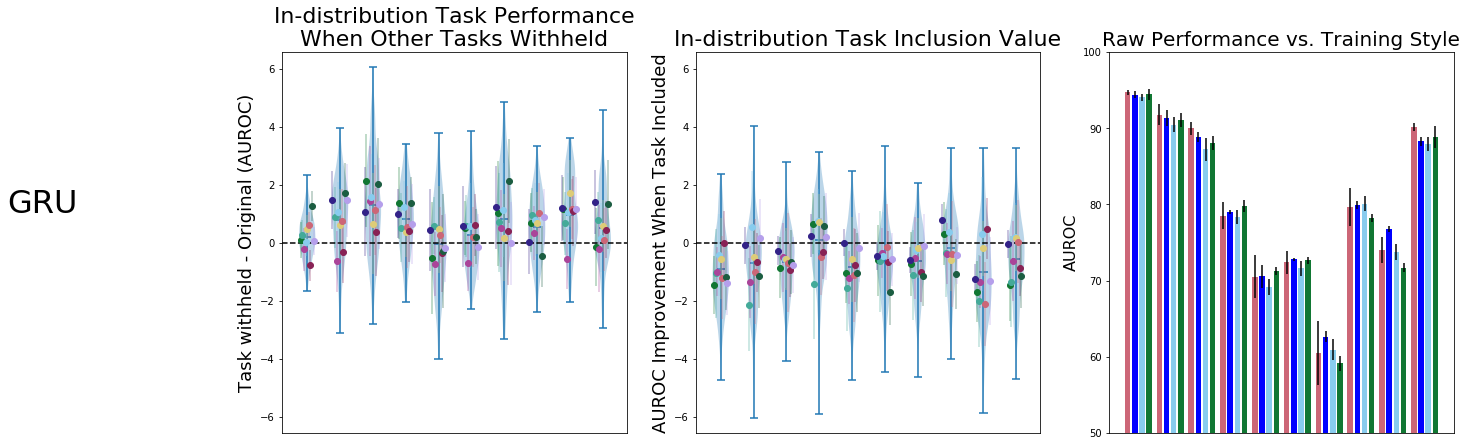

# Samples:


MT   ST  FTD  FTF          ST                                      \
    Orig Orig Orig Orig %: 2.90e-04 %: 1.00e-03 %: 1.78e-03 %: 3.16e-03   
MOR   10    3    3    5           5           5           5           5   
CMO   10    3    3    5           5           5           5           5   
DNR   10    3    3    5           5           5           5           5   
ICD   10    3    3    5           5           5           5           5   
LOS   10    3    3    5           5           5           5           5   
REA   10    3    3    5           5           5           5           5   
DIS   10    3    3    5           5           5           5           5   
ACU   10    3    3    5           5           5           5           5   
WBM   10    3    3    5           5           5           5           5   
FTS   10    3    3    5           5           5           5           5   

                                                                             \
    %: 5.62e-03 %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02 %: 1.00e-01   
MOR           4           2           2           2           2           2   
CMO           4           3           3           3           3           3   
DNR           4           3           3           3           3           3   
ICD           4           2           2           2           2           2   
LOS           4           2           2           2           2           2   
REA           4           2           2           2           2           2   
DIS           4           3           3           3           3           3   
ACU           4           3           3           3           3           3   
WBM           4           2           2           2           2           2   
FTS           4           3           3           3           2           2   

                                                FTD                          \
    %: 1.78e-01 %: 3.16e-01 %: 5.62e-01 %: 2.90e-04 %: 1.00e-03 %: 1.78e-03   
MOR           2           2           2           2           3           3   
CMO           3           3           3           2           3           3   
DNR           2           2           2           2           3           3   
ICD           2           2           2           2           3           3   
LOS           2           2           2           2           3           3   
REA           2           2           2           2           3           3   
DIS           3           2           2           2           3           3   
ACU           3           2           2           2           3           3   
WBM           2           2           2           2           3           3   
FTS           2           2           2           2           3           3   

                                                                             \
    %: 3.16e-03 %: 5.62e-03 %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02   
MOR           3           2           3           3           2           2   
CMO           3           2           3           3           3           2   
DNR           3           2           3           3           3           3   
ICD           3           2           3           3           2           2   
LOS           3           2           3           3           2           2   
REA           3           2           3           3           2           2   
DIS           3           2           3           3           3           2   
ACU           3           2           3           3           3           2   
WBM           3           2           3           3           3           3   
FTS           3           2           3           3           3           2   

                                                            FTF              \
    %: 1.00e-01 %: 1.78e-01 %: 3.16e-01 %: 5.62e-01 %: 2.90e-04 %: 1.00e-03   
MOR           2           2           1           2           4           5   
CMO           2      

<Figure size 1512x504 with 0 Axes>

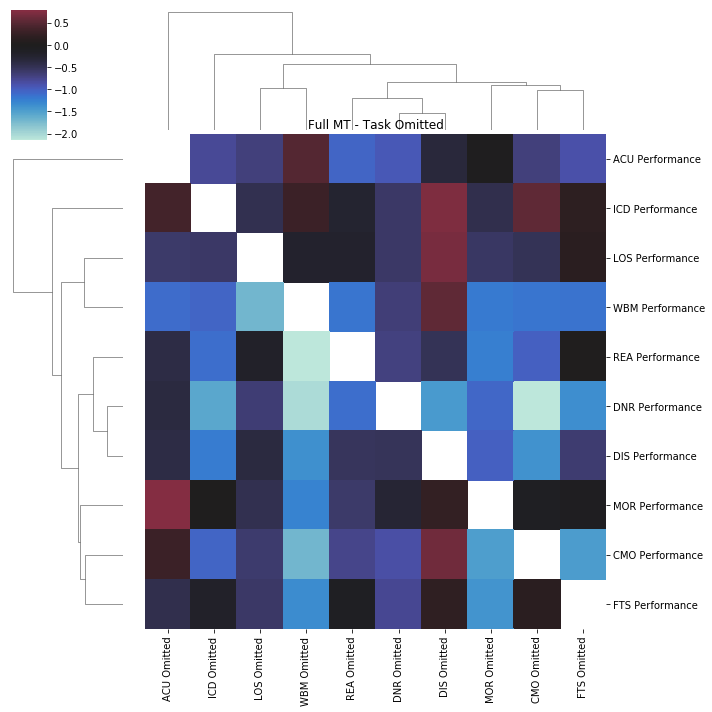

In [327]:
out = get_full_summary(
    'gru', split='test',
    display_ticks=False, add_titles=True,
    show_all_perfs=True, add_arch_text=True,
    add_violin_points_jitter=True, add_violin_points_errorbars=True,
    show_legend=False, legend_right=False,
#     display_ticks=True, add_titles=True,
#     add_violin_points_jitter=False, add_violin_points_errorbars=False,
#     show_all_perfs=False, add_arch_text=False,
#     show_legend=True, legend_right=True,
)
[
    agg_multitask_gru, pre_train_gru, small_data_gru, small_data_full_gru, fine_tune_gru,
    fine_tune_full_gru, single_task_small_data_gru, single_task_gru, female_gru, female_full_gru,
    single_task_female_gru, num_samples_gru
] = out

In [257]:
lll = foo[
    '/crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single_female/v0/gru/f3fd061f9c7216b77f053d92a884bea8/0'
]['readmission']

In [258]:
len(lll)

3

In [259]:
lll[0]

[0.0, 0.1, 0.5]

In [266]:
lll[1][0]['test']

[{('Sum', 'Loss (mean)'): 0.0024718505,
  ('Sum', 'Loss (std)'): 0.007524291,
  ('disch_48h', 'Loss (mean)'): 0.008651476,
  ('disch_48h', 'Loss (std)'): 0.012028692,
  ('disch_48h', 'Balanced Accuracy'): 0.0625,
  ('disch_48h', "Cohen's Kappa"): -3.533971193747654e-05,
  ('disch_48h', 'AUROC (ovr; all)'): NO_DISCH                     0.501871
  HOME HEALTH CARE             0.512442
  HOME                         0.520561
  SNF                          0.480932
  REHAB/DISTINCT PART HOSP     0.596308
  LONG TERM CARE HOSPITAL      0.367722
  DISC-TRAN CANCER/CHLDRN H    0.526739
  SHORT TERM HOSPITAL          0.498999
  DISCH-TRAN TO PSYCH HOSP     0.291416
  HOSPICE-HOME                 0.636131
  LEFT AGAINST MEDICAL ADVI    0.722933
  HOSPICE-MEDICAL FACILITY     0.665619
  HOME WITH HOME IV PROVIDR    0.681856
  OTHER FACILITY               0.431973
  ICF                          0.737838
  dtype: float64,
  ('disch_48h', 'AUROC (ovr; micro)'): 0.5073057484393947,
  ('disch_48h', '

In [ ]:
out_auprc = get_full_summary(
    'gru', split='test',
    display_ticks=False, add_titles=True,
    show_all_perfs=True, add_arch_text=True,
    add_violin_points_jitter=True, add_violin_points_errorbars=True,
    show_legend=False, legend_right=False,
#     display_ticks=True, add_titles=True,
#     add_violin_points_jitter=False, add_violin_points_errorbars=False,
#     show_all_perfs=False, add_arch_text=False,
#     show_legend=True, legend_right=True,
    auprc=True,
)
[
    agg_multitask_gru_auprc, pre_train_gru_auprc, small_data_gru_auprc, small_data_full_gru_auprc,
    fine_tune_gru_auprc, fine_tune_full_gru_auprc, single_task_small_data_gru_auprc, single_task_gru_auprc,
    female_gru_auprc, female_full_gru_auprc, single_task_female_gru_auprc, num_samples_gru_auprc
] = out_auprc

In [129]:
main_results_gru, main_results_display_gru = get_results_table({
    ('Full-data', 'FTF'): fine_tune_full_gru, ('Full-data', 'FTD'): fine_tune_gru,
    ('Full-data', 'ST'): single_task_gru, ('Full-data', 'MT'): agg_multitask_gru,
    ('Few-shot (1%)', 'FTF'): small_data_full_gru.loc[0.01].unstack('Aggregation Function'),
    ('Few-shot (1%)', 'FTD'): small_data_gru.loc[0.01].unstack('Aggregation Function'),
    ('Few-shot (1%)', 'ST'): single_task_small_data_gru.loc[0.01].unstack('Aggregation Function'),
}, secondary_max_cmd='boldsymbol')
display(main_results_display_gru)
print(main_results_display_gru.to_latex(escape=False))

Full-data                               \
                              ST                           MT   
MOR               $94.5 \pm 0.7$               $94.1 \pm 0.5$   
CMO               $91.2 \pm 0.9$               $90.5 \pm 1.0$   
DNR               $88.1 \pm 1.0$               $87.2 \pm 1.5$   
DIS  $\boldsymbol{79.8 \pm 0.8}$               $78.3 \pm 0.9$   
ICD  $\boldsymbol{71.2 \pm 0.5}$               $69.2 \pm 1.0$   
LOS               $72.6 \pm 0.5$               $71.6 \pm 0.9$   
REA               $59.1 \pm 1.0$               $60.9 \pm 1.4$   
ACU               $78.2 \pm 0.5$  $\boldsymbol{80.1 \pm 0.9}$   
WBM               $71.7 \pm 0.6$               $73.8 \pm 1.1$   
FTS               $88.9 \pm 1.5$               $87.9 \pm 1.0$   

                                                               \
                             FTD                          FTF   
MOR               $94.4 \pm 0.4$  $\boldsymbol{94.9 \pm 0.2}$   
CMO               $91.4 \pm 1.0$  $\boldsymbol{92.3 \pm 0.9}$   
DNR               $88.9 \pm 0.7$  $\boldsymbol{90.2 \pm 0.9}$   
DIS               $79.0 \pm 0.3$               $78.6 \pm 2.0$   
ICD               $70.6 \pm 1.5$               $70.9 \pm 3.1$   
LOS               $72.8 \pm 0.2$  $\boldsymbol{72.9 \pm 1.0}$   
REA  $\boldsymbol{62.6 \pm 0.7}$               $59.3 \pm 3.8$   
ACU               $79.9 \pm 0.5$               $80.0 \pm 2.7$   
WBM  $\boldsymbol{76.8 \pm 0.4}$               $73.5 \pm 1.4$   
FTS               $88.3 \pm 0.6$  $\boldsymbol{90.1 \pm 0.6}$   

                   Few-shot (1%)                               \
                              ST                          FTD   
MOR               $64.1 \pm 6.7$              $39.6 \pm 12.2$   
CMO               $48.4 \pm 2.2$              $42.0 \pm 15.7$   
DNR               $59.8 \pm 5.0$               $30.7 \pm 8.6$   
DIS               $57.2 \pm 3.0$               $50.7 \pm 0.6$   
ICD               $53.8 \pm 2.2$               $51.1 \pm 2.5$   
LOS               $52.4 \pm 0.5$              $53.3 \pm 11.7$   
REA               $51.1 \pm 3.4$  $\boldsymbol{51.8 \pm 6.3}$   
ACU               $57.0 \pm 4.1$               $52.4 \pm 4.9$   
WBM               $50.3 \pm 0.5$               $50.2 \pm 0.8$   
FTS  $\boldsymbol{62.9 \pm 5.0}$               $55.5 \pm 6.1$   

                                  
                             FTF  
MOR  $\boldsymbol{89.4 \pm 2.2}$  
CMO  $\boldsymbol{75.4 \pm 7.6}$  
DNR  $\boldsymbol{76.3 \pm 1.3}$  
DIS  $\boldsymbol{57.3 \pm 0.7}$  
ICD  $\boldsymbol{56.7 \pm 1.1}$  
LOS  $\boldsymbol{66.4 \pm 3.2}$  
REA               $51.8 \pm 4.5$  
ACU  $\boldsymbol{60.9 \pm 1.1}$  
WBM  $\boldsymbol{51.1 \pm 1.8}$  
FTS               $58.8 \pm 2.0$

\begin{tabular}{llllllll}
\toprule
{} & \multicolumn{4}{l}{Full-data} & \multicolumn{3}{l}{Few-shot (1%)} \\
{} &                           ST &                           MT &                          FTD &                          FTF &                           ST &                          FTD &                          FTF \\
\midrule
MOR &               $94.5 \pm 0.7$ &               $94.1 \pm 0.5$ &               $94.4 \pm 0.4$ &  $\boldsymbol{94.9 \pm 0.2}$ &               $64.1 \pm 6.7$ &              $39.6 \pm 12.2$ &  $\boldsymbol{89.4 \pm 2.2}$ \\
CMO &               $91.2 \pm 0.9$ &               $90.5 \pm 1.0$ &               $91.4 \pm 1.0$ &  $\boldsymbol{92.3 \pm 0.9}$ &               $48.4 \pm 2.2$ &              $42.0 \pm 15.7$ &  $\boldsymbol{75.4 \pm 7.6}$ \\
DNR &               $88.1 \pm 1.0$ &               $87.2 \pm 1.5$ &               $88.9 \pm 0.7$ &  $\boldsymbol{90.2 \pm 0.9}$ &               $59.8 \pm 5.0$ &               $30.7 \pm 8.6$ &  $\boldsymbol{76.3 

In [56]:
main_results_gru, main_results_display_gru = get_results_table({
    ('GRU', 'FTF'): fine_tune_full_gru, ('GRU', 'FTD'): fine_tune_gru, ('GRU', 'ST'): single_task_gru,
    ('GRU', 'MT'): agg_multitask_gru,
})
display(main_results_display_gru)
print(main_results_display_gru.to_latex(escape=False))

GRU                               \
                              ST                           MT   
MOR               $94.5 \pm 0.6$               $94.1 \pm 0.5$   
CMO               $91.2 \pm 0.8$               $90.5 \pm 1.0$   
DNR               $87.8 \pm 1.0$               $87.2 \pm 1.5$   
DIS  $\boldsymbol{79.3 \pm 1.3}$               $78.3 \pm 0.9$   
ICD  $\boldsymbol{70.9 \pm 0.7}$               $69.2 \pm 1.0$   
LOS               $72.6 \pm 0.4$               $71.6 \pm 0.9$   
REA               $58.9 \pm 0.9$               $60.9 \pm 1.4$   
ACU               $78.3 \pm 0.4$  $\boldsymbol{80.1 \pm 0.9}$   
WBM               $71.8 \pm 0.5$               $73.8 \pm 1.1$   
FTS               $89.2 \pm 1.4$               $87.9 \pm 1.0$   

                                                               
                             FTD                          FTF  
MOR               $94.4 \pm 0.4$  $\boldsymbol{94.9 \pm 0.2}$  
CMO               $91.4 \pm 1.0$  $\boldsymbol{92.3 \pm 0.9}$  
DNR               $88.9 \pm 0.7$  $\boldsymbol{90.2 \pm 0.9}$  
DIS               $79.0 \pm 0.3$               $78.6 \pm 2.0$  
ICD               $70.6 \pm 1.5$               $70.9 \pm 3.1$  
LOS               $72.8 \pm 0.2$  $\boldsymbol{72.9 \pm 1.0}$  
REA  $\boldsymbol{62.6 \pm 0.7}$               $59.3 \pm 3.8$  
ACU               $79.9 \pm 0.5$               $80.0 \pm 2.7$  
WBM  $\boldsymbol{76.8 \pm 0.4}$               $73.5 \pm 1.4$  
FTS               $88.3 \pm 0.6$  $\boldsymbol{90.1 \pm 0.6}$

\begin{tabular}{lllll}
\toprule
{} & \multicolumn{4}{l}{GRU} \\
{} &                           ST &                           MT &                          FTD &                          FTF \\
\midrule
MOR &               $94.5 \pm 0.6$ &               $94.1 \pm 0.5$ &               $94.4 \pm 0.4$ &  $\boldsymbol{94.9 \pm 0.2}$ \\
CMO &               $91.2 \pm 0.8$ &               $90.5 \pm 1.0$ &               $91.4 \pm 1.0$ &  $\boldsymbol{92.3 \pm 0.9}$ \\
DNR &               $87.8 \pm 1.0$ &               $87.2 \pm 1.5$ &               $88.9 \pm 0.7$ &  $\boldsymbol{90.2 \pm 0.9}$ \\
DIS &  $\boldsymbol{79.3 \pm 1.3}$ &               $78.3 \pm 0.9$ &               $79.0 \pm 0.3$ &               $78.6 \pm 2.0$ \\
ICD &  $\boldsymbol{70.9 \pm 0.7}$ &               $69.2 \pm 1.0$ &               $70.6 \pm 1.5$ &               $70.9 \pm 3.1$ \\
LOS &               $72.6 \pm 0.4$ &               $71.6 \pm 0.9$ &               $72.8 \pm 0.2$ &  $\boldsymbol{72.9 \pm 1.0}$ \\
REA &      

In [57]:
small_results_gru, small_results_display_gru = get_results_table({
    ('GRU', 'FTF'): small_data_full_gru.loc[0.01].unstack('Aggregation Function'),
    ('GRU', 'FTD'): small_data_gru.loc[0.01].unstack('Aggregation Function'),
    ('GRU', 'ST'): single_task_small_data_gru.loc[0.01].unstack('Aggregation Function'),
})
display(small_results_display_gru)
print(small_results_display_gru.to_latex(escape=False))

GRU                   \
                               ST              FTD   
Task                                                 
MOR                $67.6 \pm 8.8$  $39.6 \pm 12.2$   
CMO                $50.6 \pm 4.8$  $42.0 \pm 15.7$   
DNR                $56.2 \pm 8.4$   $30.7 \pm 8.6$   
DIS                $57.2 \pm 3.0$   $50.7 \pm 0.6$   
ICD                $54.0 \pm 1.8$   $51.1 \pm 2.5$   
LOS                $52.7 \pm 0.8$  $53.3 \pm 11.7$   
REA   $\boldsymbol{52.6 \pm 4.0}$   $51.8 \pm 6.3$   
ACU                $57.4 \pm 3.5$   $52.4 \pm 4.9$   
WBM                $50.4 \pm 0.4$   $50.2 \pm 0.8$   
FTS   $\boldsymbol{62.1 \pm 4.4}$   $55.5 \pm 6.1$   

                                   
                              FTF  
Task                               
MOR   $\boldsymbol{89.4 \pm 2.2}$  
CMO   $\boldsymbol{75.4 \pm 7.6}$  
DNR   $\boldsymbol{76.3 \pm 1.3}$  
DIS   $\boldsymbol{57.3 \pm 0.7}$  
ICD   $\boldsymbol{56.7 \pm 1.1}$  
LOS   $\boldsymbol{66.4 \pm 3.2}$  
REA                $51.8 \pm 4.5$  
ACU   $\boldsymbol{60.9 \pm 1.1}$  
WBM   $\boldsymbol{51.1 \pm 1.8}$  
FTS                $58.8 \pm 2.0$

\begin{tabular}{llll}
\toprule
{} & \multicolumn{3}{l}{GRU} \\
{} &                           ST &              FTD &                          FTF \\
Task &                              &                  &                              \\
\midrule
MOR  &               $67.6 \pm 8.8$ &  $39.6 \pm 12.2$ &  $\boldsymbol{89.4 \pm 2.2}$ \\
CMO  &               $50.6 \pm 4.8$ &  $42.0 \pm 15.7$ &  $\boldsymbol{75.4 \pm 7.6}$ \\
DNR  &               $56.2 \pm 8.4$ &   $30.7 \pm 8.6$ &  $\boldsymbol{76.3 \pm 1.3}$ \\
DIS  &               $57.2 \pm 3.0$ &   $50.7 \pm 0.6$ &  $\boldsymbol{57.3 \pm 0.7}$ \\
ICD  &               $54.0 \pm 1.8$ &   $51.1 \pm 2.5$ &  $\boldsymbol{56.7 \pm 1.1}$ \\
LOS  &               $52.7 \pm 0.8$ &  $53.3 \pm 11.7$ &  $\boldsymbol{66.4 \pm 3.2}$ \\
REA  &  $\boldsymbol{52.6 \pm 4.0}$ &   $51.8 \pm 6.3$ &               $51.8 \pm 4.5$ \\
ACU  &               $57.4 \pm 3.5$ &   $52.4 \pm 4.9$ &  $\boldsymbol{60.9 \pm 1.1}$ \\
WBM  &               $50.4 \pm 0.4$ &   

In [237]:
single_task_female_gru.loc[0, idx['MOR', :, 'list']]

Task  Gender         Aggregation Function
MOR   Female         list                      [93.58482778668447]
      Male           list                      [94.08253590029867]
      M-F Disparity  list                    [0.49770811361419476]
Name: 0.0, dtype: object

In [328]:
female_results_gru, female_results_display_gru = get_results_table({
    ('GRU', 'FTF'): get_gender(female_full_gru, 'M-F Disparity').loc[0].unstack('Aggregation Function'),
    ('GRU', 'FTD'): get_gender(female_gru, 'M-F Disparity').loc[0].unstack('Aggregation Function'),
    ('GRU', 'ST'): get_gender(single_task_female_gru, 'M-F Disparity').loc[0].unstack('Aggregation Function'),
}, do_argmin=True, show_std=False)
display(female_results_display_gru)
print(female_results_display_gru.to_latex(escape=False))

GRU                                          
                       ST                  FTD                  FTF
Task                                                               
MOR                 $0.5$               $-0.2$  $\boldsymbol{-1.1}$
CMO                 $3.1$               $-0.1$  $\boldsymbol{-2.8}$
DNR                 $0.1$                $3.9$  $\boldsymbol{-1.0}$
DIS   $\boldsymbol{-0.3}$                $0.6$                $2.8$
ICD    $\boldsymbol{1.9}$                $4.9$                $3.7$
LOS                $-2.9$  $\boldsymbol{-3.5}$                $1.1$
REA   $\boldsymbol{-3.4}$                $7.9$               $-0.2$
ACU                $-0.7$               $-0.0$  $\boldsymbol{-3.8}$
WBM   $\boldsymbol{-0.2}$                $0.4$                $0.6$
FTS   $\boldsymbol{-2.0}$               $-1.7$               $-1.2$

\begin{tabular}{llll}
\toprule
{} & \multicolumn{3}{l}{GRU} \\
{} &                   ST &                  FTD &                  FTF \\
Task &                      &                      &                      \\
\midrule
MOR  &                $0.5$ &               $-0.2$ &  $\boldsymbol{-1.1}$ \\
CMO  &                $3.1$ &               $-0.1$ &  $\boldsymbol{-2.8}$ \\
DNR  &                $0.1$ &                $3.9$ &  $\boldsymbol{-1.0}$ \\
DIS  &  $\boldsymbol{-0.3}$ &                $0.6$ &                $2.8$ \\
ICD  &   $\boldsymbol{1.9}$ &                $4.9$ &                $3.7$ \\
LOS  &               $-2.9$ &  $\boldsymbol{-3.5}$ &                $1.1$ \\
REA  &  $\boldsymbol{-3.4}$ &                $7.9$ &               $-0.2$ \\
ACU  &               $-0.7$ &               $-0.0$ &  $\boldsymbol{-3.8}$ \\
WBM  &  $\boldsymbol{-0.2}$ &                $0.4$ &                $0.6$ \\
FTS  &  $\boldsymbol{-2.0}$ &               $-1.7$ &               $-1.2$ \\
\botto

In [279]:
female_results_gru, female_results_display_gru = get_results_table({
    ('GRU', 'FTF'): get_gender(female_full_gru, 'M-F Disparity').loc[0].unstack('Aggregation Function'),
    ('GRU', 'FTD'): get_gender(female_gru, 'M-F Disparity').loc[0].unstack('Aggregation Function'),
    ('GRU', 'ST'): get_gender(single_task_female_gru, 'M-F Disparity').loc[0].unstack('Aggregation Function'),
}, do_argmin=True)
display(female_results_display_gru)
print(female_results_display_gru.to_latex(escape=False))

GRU                                \
                                ST                           FTD   
Task                                                               
MOR                  $0.5 \pm 0.0$               $-0.2 \pm -0.0$   
CMO                  $3.1 \pm 0.0$  $\boldsymbol{-0.1 \pm -0.0}$   
DNR                  $0.1 \pm 0.0$                 $3.9 \pm 0.0$   
DIS   $\boldsymbol{-0.3 \pm -0.0}$                 $0.6 \pm 0.0$   
ICD     $\boldsymbol{1.9 \pm 0.0}$                 $4.9 \pm 0.0$   
LOS                $-2.9 \pm -0.0$  $\boldsymbol{-3.5 \pm -0.0}$   
REA       $\boldsymbol{NA \pm NA}$                   $NA \pm NA$   
ACU                $-0.7 \pm -0.0$               $-0.0 \pm -0.0$   
WBM   $\boldsymbol{-0.2 \pm -0.0}$                 $0.4 \pm 0.0$   
FTS   $\boldsymbol{-2.0 \pm -0.0}$               $-1.7 \pm -0.0$   

                                    
                               FTF  
Task                                
MOR   $\boldsymbol{-1.1 \pm -0.0}$  
CMO                    $NA \pm NA$  
DNR   $\boldsymbol{-1.0 \pm -0.0}$  
DIS                  $2.8 \pm 0.0$  
ICD                  $3.7 \pm 0.0$  
LOS                  $1.1 \pm 0.0$  
REA                    $NA \pm NA$  
ACU   $\boldsymbol{-3.8 \pm -0.0}$  
WBM                  $0.6 \pm 0.0$  
FTS                $-1.2 \pm -0.0$

\begin{tabular}{llll}
\toprule
{} & \multicolumn{3}{l}{GRU} \\
{} &                            ST &                           FTD &                           FTF \\
Task &                               &                               &                               \\
\midrule
MOR  &                 $0.5 \pm 0.0$ &               $-0.2 \pm -0.0$ &  $\boldsymbol{-1.1 \pm -0.0}$ \\
CMO  &                 $3.1 \pm 0.0$ &  $\boldsymbol{-0.1 \pm -0.0}$ &                   $NA \pm NA$ \\
DNR  &                 $0.1 \pm 0.0$ &                 $3.9 \pm 0.0$ &  $\boldsymbol{-1.0 \pm -0.0}$ \\
DIS  &  $\boldsymbol{-0.3 \pm -0.0}$ &                 $0.6 \pm 0.0$ &                 $2.8 \pm 0.0$ \\
ICD  &    $\boldsymbol{1.9 \pm 0.0}$ &                 $4.9 \pm 0.0$ &                 $3.7 \pm 0.0$ \\
LOS  &               $-2.9 \pm -0.0$ &  $\boldsymbol{-3.5 \pm -0.0}$ &                 $1.1 \pm 0.0$ \\
REA  &      $\boldsymbol{NA \pm NA}$ &                   $NA \pm NA$ &                   $NA \pm N

MOR
0.4177412063323409 0.52727779121309
CMO
1.0622324476450515 1.0153440306725996
DNR
2.4420205613068156 1.1428364745766308
ICD
-0.05131265876242708 2.730013693946374
LOS
0.29520843234435645 0.9304416150933809
REA
0.4077383228736018 3.3969601013197197
DIS
-0.7083266092713814 2.085333970298343
ACU
1.725110096903908 2.3646407168137227
WBM
1.7601650411777428 1.3181300797020372
FTS
0.9561507956569848 1.29878638675525
Overall: 0.83 \pm 2.10


(array([ 4.,  3., 11., 19., 53., 32., 18., 14.,  4.,  2.]),
 array([-5.22596205, -4.00157085, -2.77717965, -1.55278845, -0.32839725,
         0.89599395,  2.12038515,  3.34477635,  4.56916755,  5.79355875,
         7.01794995]),
 <a list of 10 Patch objects>)

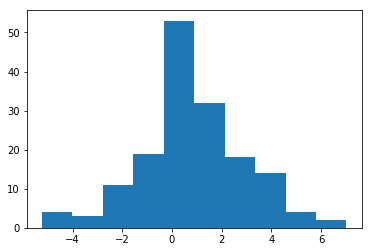

In [59]:
all_diffs = []
for task in fine_tune_full_gru.index:
    print(task)
    diffs = [
        y1 - y2 for y1, y2 in itertools.product(
            fine_tune_full_gru.loc[task, 'list'],
            single_task_gru.loc[task, 'list'],
        ) if not (np.isnan(y1) or np.isnan(y2))
    ]
    print(np.mean(diffs), np.std(diffs))
    all_diffs.extend(diffs)
    
print("Overall: %.2f \pm %.2f" % (np.mean(all_diffs), np.std(all_diffs)))
plt.hist(all_diffs)

In [60]:
for task in fine_tune_full_gru.index:
    print(task)
    print(ss.ttest_ind_from_stats(
        mean1=single_task_gru.loc[task, 'mean'], 
        std1=single_task_gru.loc[task, 'std'],
        nobs1=single_task_gru.loc[task, 'count'],
        mean2=fine_tune_full_gru.loc[task, 'mean'],
        std2=fine_tune_full_gru.loc[task, 'std'],
        nobs2=fine_tune_full_gru.loc[task, 'count'],
    ))

MOR
Ttest_indResult(statistic=-1.3722349126787645, pvalue=0.21907994204048167)
CMO
Ttest_indResult(statistic=-1.8120366232425806, pvalue=0.11993616314796562)
DNR
Ttest_indResult(statistic=-3.7010576573329694, pvalue=0.010075742108239867)
ICD
Ttest_indResult(statistic=0.03255519642449767, pvalue=0.9750852531074263)
LOS
Ttest_indResult(statistic=-0.5495412021009901, pvalue=0.6024721311365346)
REA
Ttest_indResult(statistic=-0.207898671266595, pvalue=0.8421852916247081)
DIS
Ttest_indResult(statistic=0.5883267107740647, pvalue=0.5777712605563998)
ACU
Ttest_indResult(statistic=-1.2636077503198293, pvalue=0.25324661518703284)
WBM
Ttest_indResult(statistic=-2.3128940974593126, pvalue=0.06003035214363857)
FTS
Ttest_indResult(statistic=-1.2751148107678643, pvalue=0.24941554724586323)


In [61]:
for task in fine_tune_full_gru.index:
    print(task)
    print(ss.ttest_ind_from_stats(
        mean1=single_task_gru.loc[task, 'mean'], 
        std1=single_task_gru.loc[task, 'std'],
        nobs1=single_task_gru.loc[task, 'count'],
        mean2=fine_tune_gru.loc[task, 'mean'],
        std2=fine_tune_gru.loc[task, 'std'],
        nobs2=fine_tune_gru.loc[task, 'count'],
    ))

MOR
Ttest_indResult(statistic=0.07489885988213042, pvalue=0.943199497496634)
CMO
Ttest_indResult(statistic=-0.26819520568602623, pvalue=0.7992620825204793)
DNR
Ttest_indResult(statistic=-1.6302409696503042, pvalue=0.16397931347259342)
ICD
Ttest_indResult(statistic=0.45082370273141364, pvalue=0.6709941109890885)
LOS
Ttest_indResult(statistic=-0.6712819291058759, pvalue=0.5317998353748454)
REA
Ttest_indResult(statistic=-5.668531986676437, pvalue=0.002377091762426342)
DIS
Ttest_indResult(statistic=0.378738410367373, pvalue=0.7204313284095618)
ACU
Ttest_indResult(statistic=-4.411867403572389, pvalue=0.006944457834865907)
WBM
Ttest_indResult(statistic=-13.286970360090287, pvalue=4.3168985880475e-05)
FTS
Ttest_indResult(statistic=1.0029856733493332, pvalue=0.36190764104383427)


In [62]:
for task in fine_tune_full_gru.index:
    print(task)
    print(ss.ttest_ind_from_stats(
        mean1=fine_tune_full_gru.loc[task, 'mean'], 
        std1=fine_tune_full_gru.loc[task, 'std'],
        nobs1=fine_tune_full_gru.loc[task, 'count'],
        mean2=fine_tune_gru.loc[task, 'mean'],
        std2=fine_tune_gru.loc[task, 'std'],
        nobs2=fine_tune_gru.loc[task, 'count'],
    ))

MOR
Ttest_indResult(statistic=1.7817946254853767, pvalue=0.13488279746422113)
CMO
Ttest_indResult(statistic=1.2106564345734885, pvalue=0.2801271447788484)
DNR
Ttest_indResult(statistic=2.1777512090416087, pvalue=0.08134342720177393)
ICD
Ttest_indResult(statistic=0.17019027139471404, pvalue=0.8715326119647977)
LOS
Ttest_indResult(statistic=0.20817577169342166, pvalue=0.8433059521973807)
REA
Ttest_indResult(statistic=-1.437547046290883, pvalue=0.21007194664562506)
DIS
Ttest_indResult(statistic=-0.3432461424003557, pvalue=0.7453746435898825)
ACU
Ttest_indResult(statistic=0.054524010523838776, pvalue=0.9586292367349489)
WBM
Ttest_indResult(statistic=-3.7205958615412307, pvalue=0.013703654037190892)
FTS
Ttest_indResult(statistic=3.890258652604704, pvalue=0.01152192057845523)


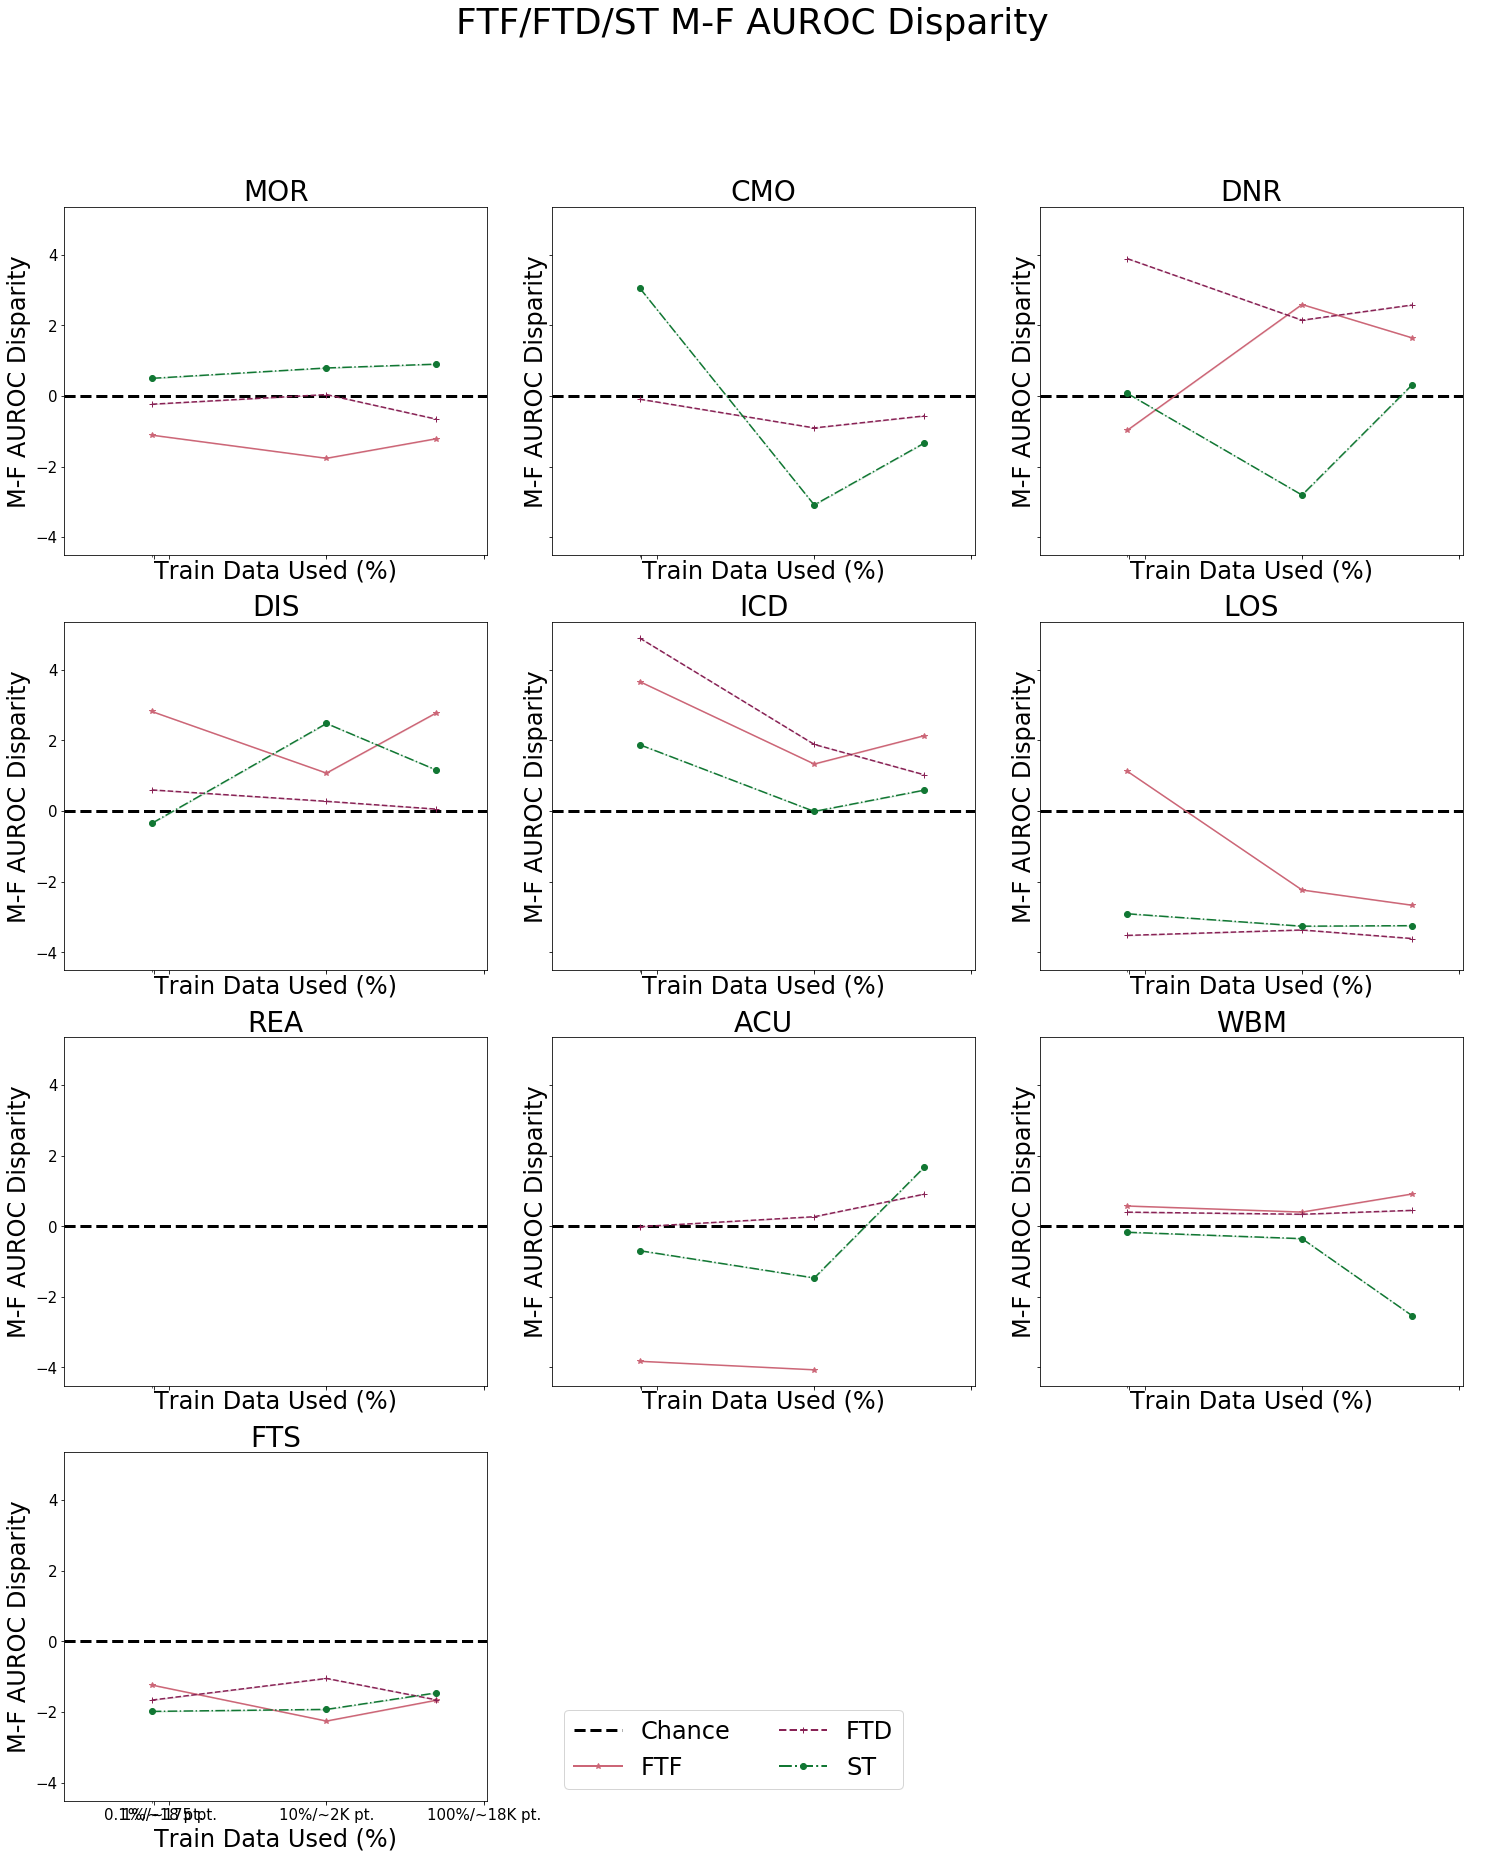

<Figure size 1512x2016 with 0 Axes>

In [130]:
plot_rest_data_line(
    {
        'ST': get_gender(single_task_female_gru, 'M-F Disparity'),
        'FTD': get_gender(female_gru, 'M-F Disparity'),
        'FTF': get_gender(female_full_gru, 'M-F Disparity'),
    },
    rest_value=0,
    baseline=None,
    metric='M-F AUROC Disparity',
    full_data_runs_by_training_mode=None,
    do_log=False, do_symlog=True
)

In [64]:
A = small_data_full_gru.loc[0.01].unstack('Aggregation Function')

In [65]:
B = single_task_small_data_gru.loc[0.01].unstack('Aggregation Function')

In [66]:
A['mean'] - B['mean']

Task
ACU      3.51041
CMO      24.7564
DIS    0.0417713
DNR      20.1287
FTS      -3.2475
ICD       2.6941
LOS      13.6462
MOR      21.8111
REA    -0.800431
WBM     0.687365
Name: mean, dtype: object

MOR
21.81111569456631 7.885735880268947 Ttest_1sampResult(statistic=10.712264413854234, pvalue=2.0061670461127763e-08)
CMO
24.75641864723255 7.782521999810272 Ttest_1sampResult(statistic=12.320067599527235, pvalue=3.0141002078956803e-09)
DNR
20.128660289744918 7.326644220929324 Ttest_1sampResult(statistic=10.640337340382048, pvalue=2.1950671258429547e-08)
ICD
2.694104092430047 1.8446609409029484 Ttest_1sampResult(statistic=5.656443442567469, pvalue=4.56136418534097e-05)
LOS
13.646208160771273 2.842500425536503 Ttest_1sampResult(statistic=18.593325957223566, pvalue=9.052413127062139e-12)
REA
-0.8004311368567691 5.2100712926094275 Ttest_1sampResult(statistic=-0.5950122922942759, pvalue=0.5607049635906578)
DIS
0.04177131274401861 2.507321298816883 Ttest_1sampResult(statistic=0.05525409585036933, pvalue=0.9569268461359699)
ACU
3.5104076882395603 3.146121004989397 Ttest_1sampResult(statistic=4.321432803566345, pvalue=0.0006051556321540846)
WBM
0.6873649572859364 1.6252060603938698 Ttest_1sa

(array([ 7., 13., 48., 23., 13., 20., 10.,  9.,  8.,  5.]),
 array([-11.90316127,  -6.93847499,  -1.97378872,   2.99089755,
          7.95558383,  12.9202701 ,  17.88495638,  22.84964265,
         27.81432892,  32.7790152 ,  37.74370147]),
 <a list of 10 Patch objects>)

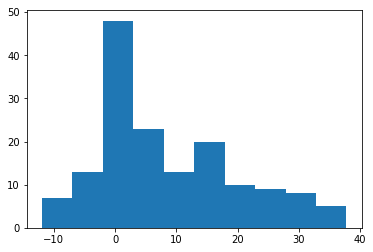

In [67]:
all_diffs = []
for task in fine_tune_full_gru.index:
    print(task)
    diffs = [
        y1 - y2 for y1, y2 in itertools.product(
            A.loc[task, 'list'],
            B.loc[task, 'list'],
        ) if not (np.isnan(y1) or np.isnan(y2))
    ]
    print(np.mean(diffs), np.std(diffs), ss.ttest_1samp(diffs, 0))
    all_diffs.extend(diffs)
    
print("Overall: %.2f \pm %.2f" % (np.mean(all_diffs), np.std(all_diffs)))
print(ss.ttest_1samp(all_diffs, 0))
plt.hist(all_diffs)

In [68]:
A

Aggregation Function,mean,std,count,max,min,list
Task,,,,,,
ACU,60.9383,1.12087,4,62.583,60.0881,"[60.4280531436412, 60.08805145003633, 60.65412..."
CMO,75.38,7.59068,4,84.5418,66.6476,"[84.54184640715086, 77.67216240444496, 66.6475..."
DIS,57.2599,0.717859,4,58.0197,56.6071,"[56.688355261179844, 57.72447144926276, 56.607..."
DNR,76.3062,1.32366,4,77.4698,74.8156,"[77.37150743568695, 75.5676448973617, 77.46983..."
FTS,58.846,1.95013,4,60.0712,55.9691,"[55.96914612688957, 60.07117396922681, 60.0376..."
ICD,56.6911,1.11795,4,57.6079,55.0781,"[57.21922642487175, 57.607897868916226, 56.859..."
LOS,66.3927,3.18266,4,68.6968,61.8918,"[66.39367913639758, 68.58849887976102, 61.8918..."
MOR,89.3893,2.1519,4,91.2339,86.3667,"[90.55245707023755, 89.40407950983177, 86.3666..."
REA,51.7502,4.48718,4,54.2679,45.029,"[54.26789258211123, 45.02904437368415, 53.6819..."


In [69]:
B

Aggregation Function,mean,std,count,max,min,list
Task,,,,,,
ACU,57.4279,3.45559,4,61.4409,53.4362,"[53.436209779713465, 56.0415268461885, 61.4409..."
CMO,50.6236,4.81024,4,57.3065,46.7981,"[46.79814493478835, 47.45741702290979, 50.9323..."
DIS,57.2181,2.97494,3,60.5322,54.7782,"[54.7781650418518, 60.53220376621742, 56.34406..."
DNR,56.1775,8.35589,4,63.0822,45.2464,"[54.055960251851864, 63.08216291343109, 62.325..."
FTS,62.0935,4.36079,4,67.4521,57.6226,"[67.4521163502364, 63.64359326522977, 57.62261..."
ICD,53.997,1.81307,4,55.1242,51.3027,"[55.00842836146135, 51.30270972826829, 55.1241..."
LOS,52.7465,0.802328,4,53.763,51.8023,"[52.66650824903252, 51.802311765903994, 52.754..."
MOR,67.5782,8.84773,4,78.0395,56.6947,"[69.64260014225863, 65.93583360694605, 56.6947..."
REA,52.5506,4.00729,4,56.9322,49.1077,"[49.10773590754107, 49.193077656966416, 54.969..."


In [70]:
for task in fine_tune_full_gru.index:
    print(task)
    print(ss.ttest_ind_from_stats(
        mean1=A.loc[task, 'mean'], 
        std1=A.loc[task, 'std'],
        nobs1=A.loc[task, 'count'],
        mean2=B.loc[task, 'mean'],
        std2=B.loc[task, 'std'],
        nobs2=B.loc[task, 'count'],
        equal_var=True
    ))

MOR
Ttest_indResult(statistic=4.7906702844660005, pvalue=0.0030295319543451314)
CMO
Ttest_indResult(statistic=5.50970172798711, pvalue=0.0015012382627653015)
DNR
Ttest_indResult(statistic=4.758503519324716, pvalue=0.003131201717478166)
ICD
Ttest_indResult(statistic=2.5296384096927635, pvalue=0.04470150908031612)
LOS
Ttest_indResult(statistic=8.315188153632644, pvalue=0.00016409780132115574)
REA
Ttest_indResult(statistic=-0.2660975866035937, pvalue=0.7990718928247409)
DIS
Ttest_indResult(statistic=0.02787591770404842, pvalue=0.9788395188284136)
ACU
Ttest_indResult(statistic=1.9326035017943721, pvalue=0.10147723756911135)
WBM
Ttest_indResult(statistic=0.7325538947800394, pvalue=0.49144491771905663)
FTS
Ttest_indResult(statistic=-1.359646353692714, pvalue=0.2228153237281414)


In [71]:
small_data_gru.loc[0.001][idx[:, 'list']].apply(min)

Task
ACU    47.756535
CMO    30.928521
DIS    50.317910
DNR    26.541237
FTS    47.688262
ICD    50.239198
LOS    43.026682
MOR    28.587998
REA    44.610387
WBM    49.103019
Name: 0.001, dtype: float64

In [72]:
small_data_gru.loc[0.001][idx[:, 'list']].apply(max)

Task
ACU    58.591507
CMO    56.559866
DIS    52.912908
DNR    41.298642
FTS    62.472657
ICD    53.035135
LOS    62.297084
MOR    53.563974
REA    55.914546
WBM    49.913944
Name: 0.001, dtype: float64

In [73]:
for base in BASES:
    fp = os.path.join(
        base, TG_FULL_DIR, 'v0', 'gru', EXP_KEYS['gru'], '0/discharge',
        'discharge_0-001_1/tuning_perf.pkl'
    )
    with open(fp, mode='rb') as f: tuning_perf_disch = pickle.load(f)
    print(tuning_perf_disch[0][('disch_48h', 'AUROC (ovr; all)')]['DISCH-TRAN TO PSYCH HOSP'])

0.6978899831533278
0.8272920574086867
0.7145100698784229
0.7283665728734932
0.714148440622373


In [74]:
for base in BASES:
    fp = os.path.join(
        base, TG_DIR, 'v0', 'gru', EXP_KEYS['gru'], '0/mortality',
        'mortality_0-001_1/tuning_perf.pkl'
    )
    with open(fp, mode='rb') as f: tuning_perf_disch = pickle.load(f)
    print(tuning_perf_disch[2][('tasks_binary_multilabel', 'AUROC (all)')]['Readmission 30'])

0.6334342167448286
0.6360562765841422
0.6295988293888828
0.6283582360853601
0.6083269713163922


In [193]:
small_data_gru['CMO']

Aggregation Function,mean,std,count,max,min,list
% Data,,,,,,
0.000290,47.4407,24.6366,2,64.8613,30.02,"[30.019987072874844, nan, 64.86134173772462]"
0.001000,42.7373,12.9338,3,56.5599,30.9285,"[30.928520995996898, 40.723476769251995, 56.55..."
0.001778,41.8139,15.2334,3,56.8269,26.3692,"[26.369168023071953, 42.24554124044201, 56.826..."
0.003162,42.0281,14.4329,3,56.8537,28.0229,"[28.022908231681043, 41.20772464412826, 56.853..."
0.005623,34.5266,8.30215,2,40.3971,28.6561,"[28.65612794567072, 40.397140005682495, nan]"
0.010000,41.9841,15.686,3,58.2337,26.9302,"[26.930152934417496, 40.788309548364225, 58.23..."
0.017783,42.085,13.3315,3,56.6123,30.4115,"[30.411475209292902, 39.23123179746846, 56.612..."
0.031623,44.7568,12.6573,3,59.0694,35.0374,"[35.03742928937874, 40.163446932257166, 59.069..."
0.056234,48.1161,9.46917,2,54.8118,41.4204,"[41.420408816379854, 54.81183882944332, nan]"


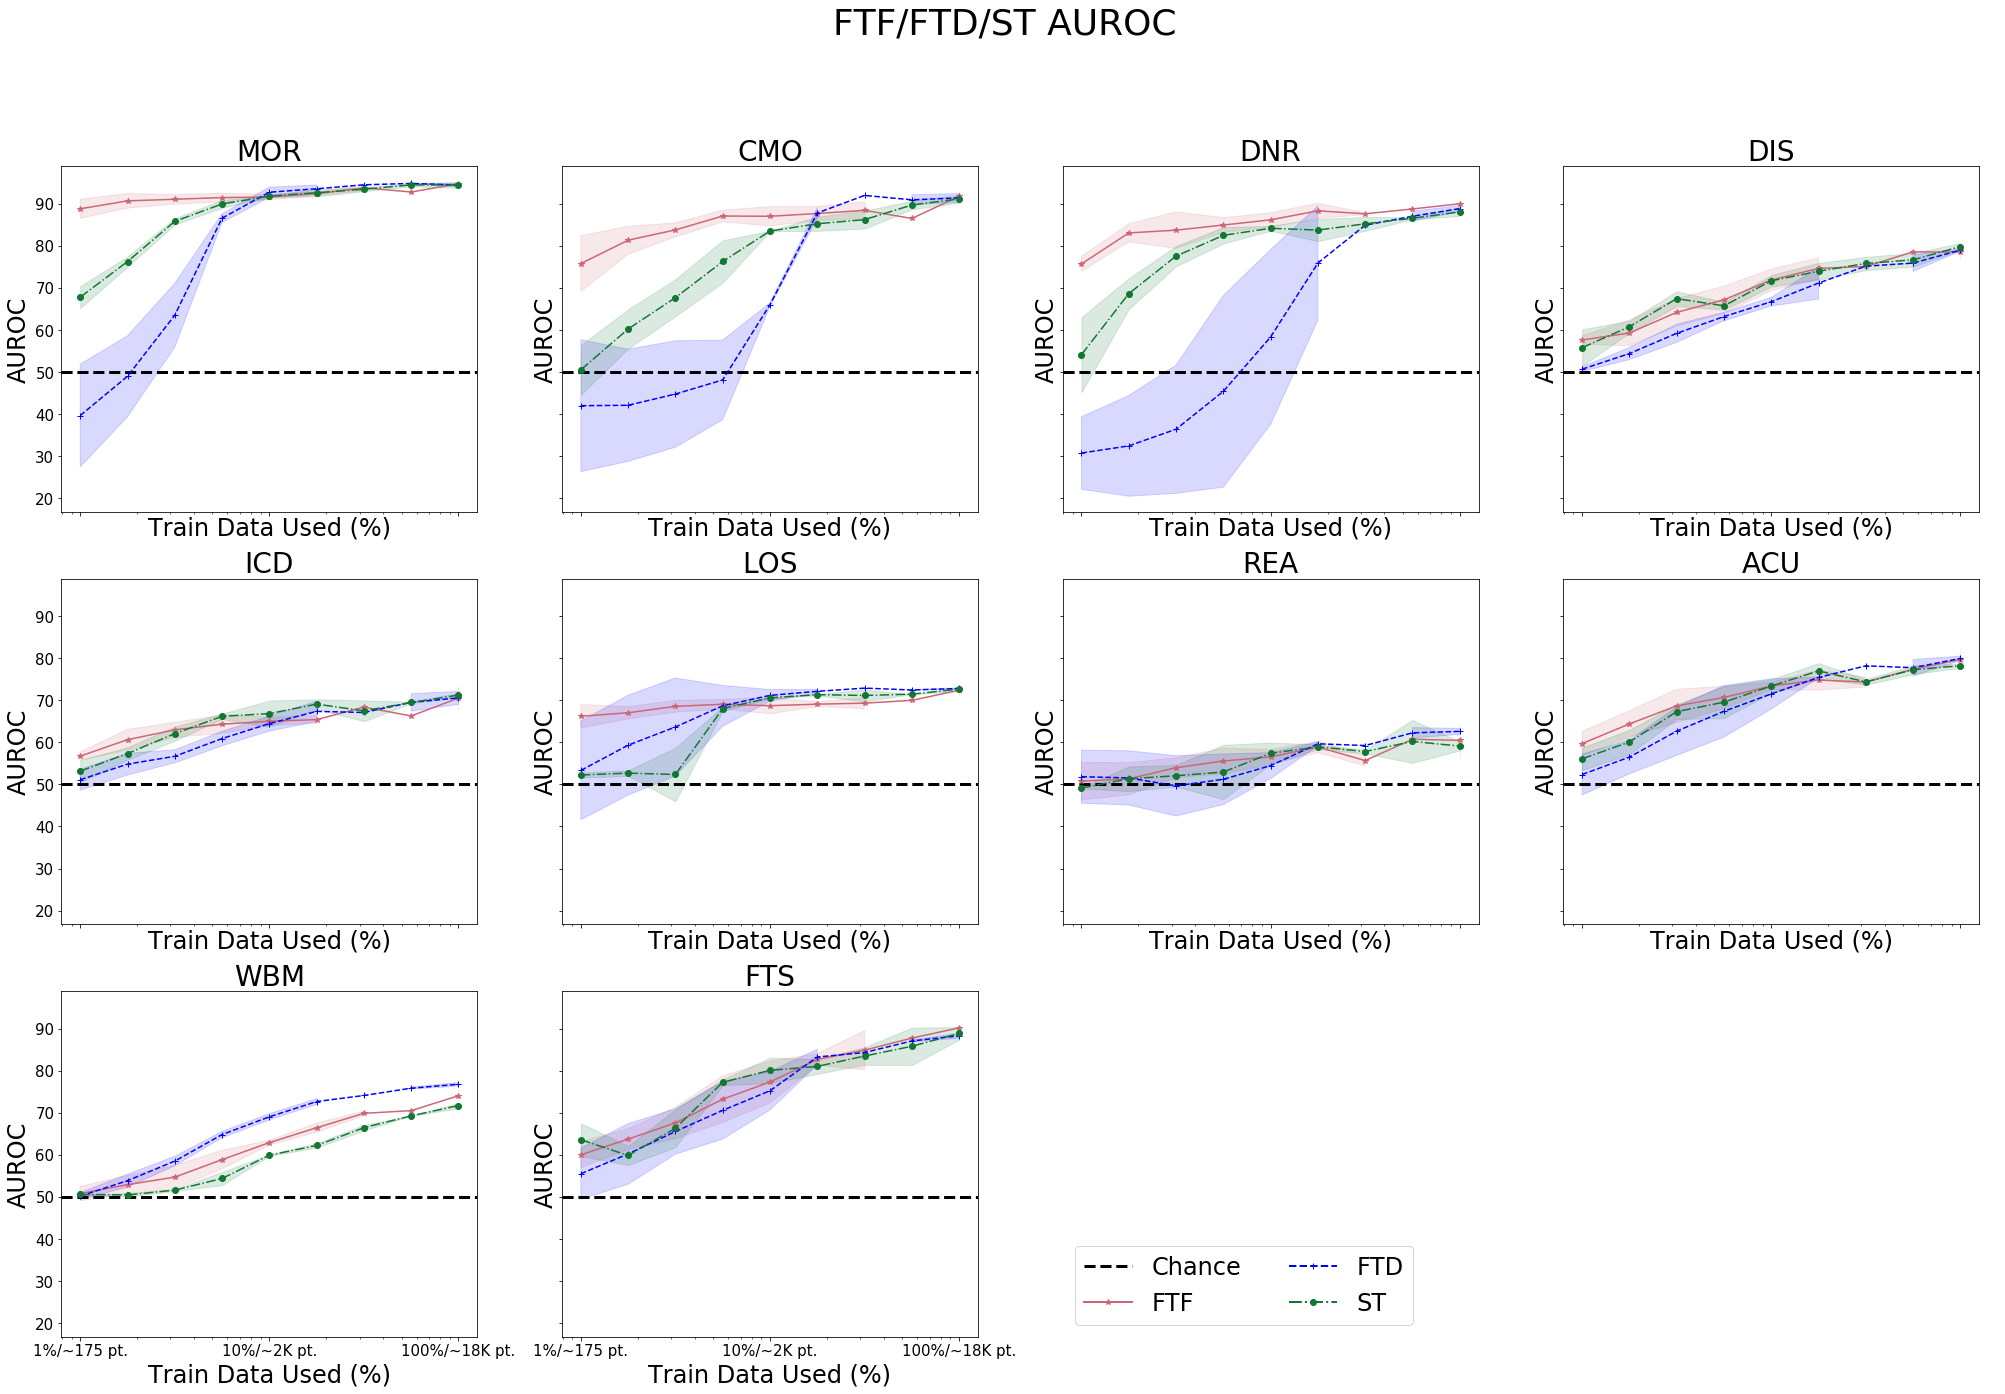

<Figure size 2016x1512 with 0 Axes>

In [329]:
plot_rest_data_line(
    {'ST': single_task_small_data_gru.loc[0.01:], 'FTD': small_data_gru.loc[0.01:], 'FTF': small_data_full_gru.loc[0.01:]},
    baseline = None,
    full_data_runs_by_training_mode={
        'ST': single_task_gru, 'FTD': fine_tune_gru, 'FTF': fine_tune_full_gru
    },
    W = 4,
    task_groupings = None,
)

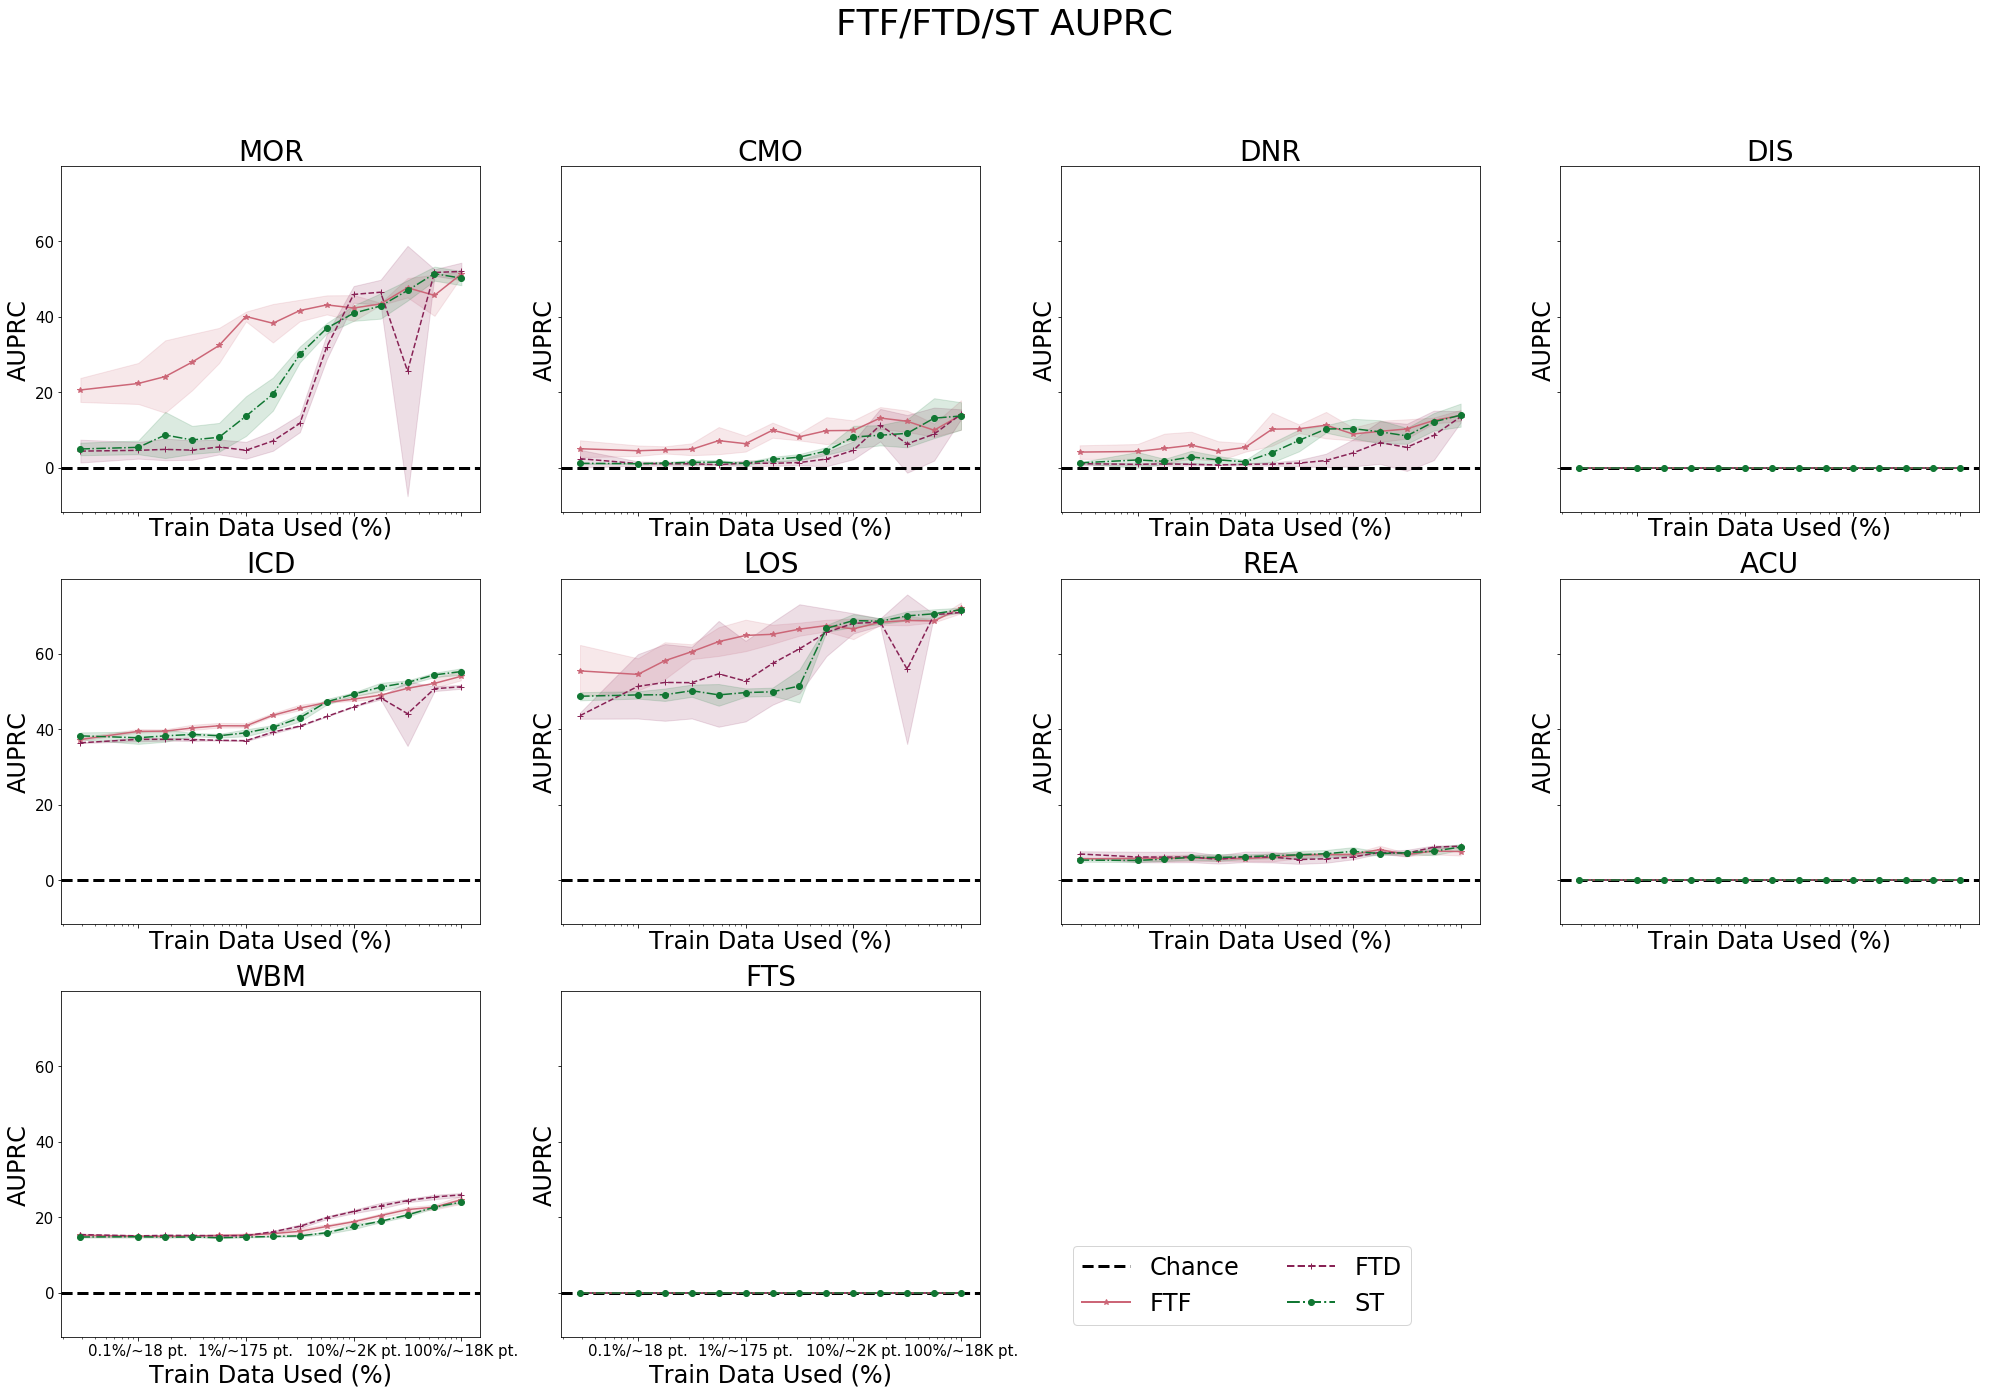

<Figure size 2016x1512 with 0 Axes>

In [77]:
plot_rest_data_line(
    {'ST': single_task_small_data_gru_auprc, 'FTD': small_data_gru_auprc, 'FTF': small_data_full_gru_auprc},
    baseline = None,
    full_data_runs_by_training_mode={
        'ST': single_task_gru_auprc, 'FTD': fine_tune_gru_auprc, 'FTF': fine_tune_full_gru_auprc
    },
    W = 4,
    task_groupings = None,
    rest_value=0,
    metric='AUPRC'
)

In [78]:
(33.5 + 84.1 ) / 2

58.8

In [79]:
small_data_full_gru['MOR']

Aggregation Function,mean,std,count,max,min,list
% Data,,,,,,
0.000290,73.685,3.60152,3,76.9564,69.8257,"[76.95642336314285, nan, 74.27287159666795, 69..."
0.001000,81.0073,4.16522,4,85.4448,75.8232,"[82.9934718309594, 79.76783922708441, 85.44480..."
0.001778,81.6457,6.21081,4,88.3938,75.9267,"[88.39380770185801, 75.92674990475771, 85.4293..."
0.003162,83.5869,3.83273,4,88.8273,80.6658,"[84.06832177290597, 80.78625844784773, 88.8272..."
0.005623,84.9672,4.1728,3,88.8652,80.5653,"[88.8651852326068, 85.47111571451948, nan, 80...."
0.010000,89.3893,2.1519,4,91.2339,86.3667,"[90.55245707023755, 89.40407950983177, 86.3666..."
0.017783,90.2885,1.72151,4,92.3048,88.6617,"[92.304844178167, 89.06835098983966, 91.119202..."
0.031623,90.7762,1.09837,4,91.9944,89.6093,"[91.99443586399806, 90.12923069528462, 91.3720..."
0.056234,91.1791,0.943661,4,91.9917,89.9565,"[91.84909037351736, 91.99171972170114, 90.9192..."


In [80]:
small_data_gru['MOR']

Aggregation Function,mean,std,count,max,min,list
% Data,,,,,,
0.000290,39.8755,19.2532,2,53.4896,26.2614,"[53.48956765942021, nan, 26.261441038847867]"
0.001000,39.4034,12.8196,3,53.564,28.588,"[53.56397370735553, 36.05818339619822, 28.5879..."
0.001778,39.665,15.1905,3,56.662,27.4143,"[56.66199353795498, 34.91861590438249, 27.4143..."
0.003162,39.3201,14.1317,3,55.4342,29.0367,"[55.43417260955419, 33.48934325183035, 29.0366..."
0.005623,43.9972,13.7269,2,53.7036,34.2908,"[53.70361205701545, 34.290803318942466, nan]"
0.010000,39.6495,12.2049,3,53.2671,29.6976,"[53.267116744639424, 35.98380313751187, 29.697..."
0.017783,48.9802,9.64083,3,59.8259,41.3837,"[59.825854385419106, 45.73116824892577, 41.383..."
0.031623,63.5109,7.59043,2,68.8781,58.1437,"[68.8781415431378, 58.143654690124826, nan]"
0.056234,86.5785,1.03946,2,87.3135,85.8435,"[85.8434933381503, 87.31351391150797, nan]"


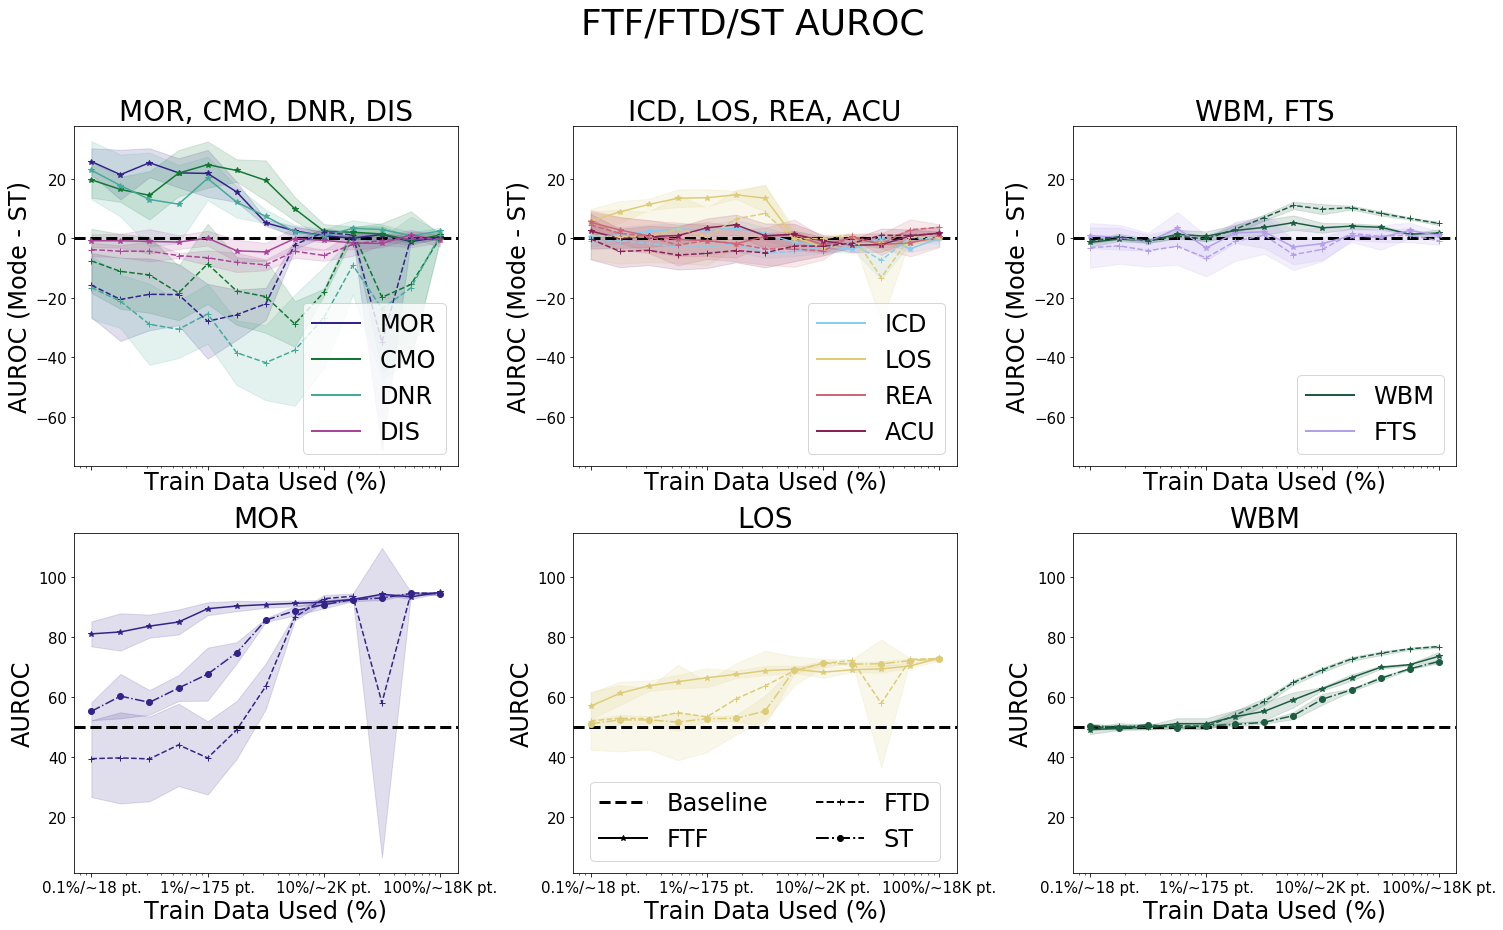

<Figure size 1512x1008 with 0 Axes>

In [83]:
plot_rest_data_line(
    {'ST': single_task_small_data_gru[0.001:],
     'FTD': small_data_gru[0.001:],
     'FTF': small_data_full_gru[0.001:]},
    baseline = ('ST', None),
    full_data_runs_by_training_mode={
        'ST': single_task_gru, 'FTD': fine_tune_gru, 'FTF': fine_tune_full_gru
    },
    W = 3,
    task_groupings = (
        ('MOR', 'CMO', 'DNR', 'DIS'), ('ICD', 'LOS', 'REA', 'ACU'), ('WBM', 'FTS'),
        ('MOR',), ('LOS',), ('WBM',),
    ),
    show_title=True,
)

/scratch/conda_envs/latent_patients_trajectories/lib/python3.7/site-packages/ipykernel_launcher.py:226: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


TypeError: 'AxesSubplot' object is not subscriptable

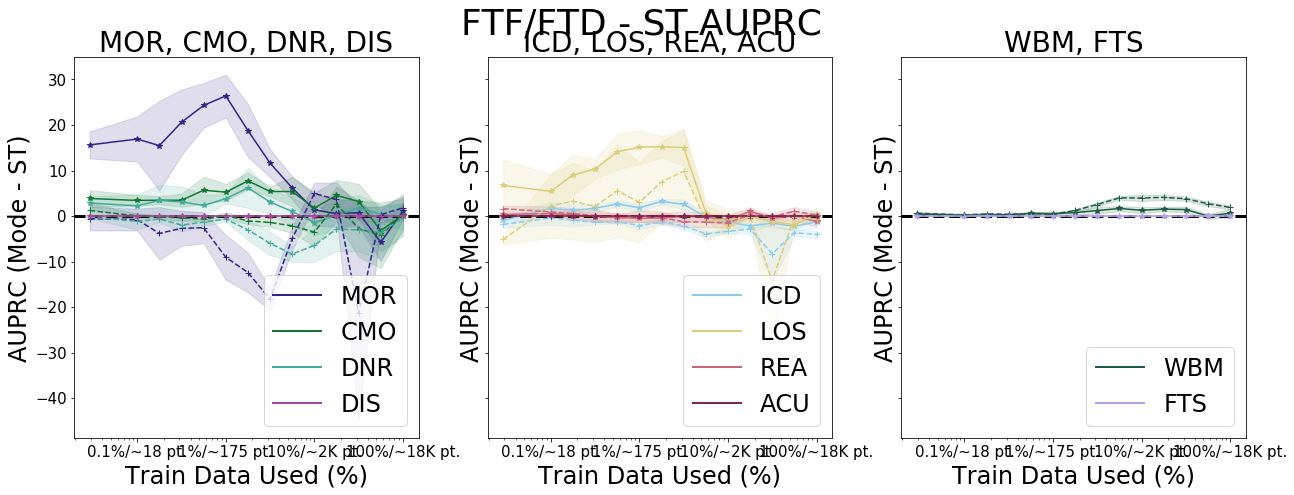

In [84]:
plot_rest_data_line(
    {'ST': single_task_small_data_gru_auprc, 'FTD': small_data_gru_auprc, 'FTF': small_data_full_gru_auprc},
    baseline = 'ST',
    full_data_runs_by_training_mode={
        'ST': single_task_gru_auprc, 'FTD': fine_tune_gru_auprc, 'FTF': fine_tune_full_gru_auprc
    },
    W = 4,
    task_groupings = (
        ('MOR', 'CMO', 'DNR', 'DIS'),
        ('ICD', 'LOS', 'REA', 'ACU'),
        ('WBM', 'FTS'),
    ),
    metric='AUPRC'
)

In [330]:
old = pd.options.display.max_columns
pd.options.display.max_columns = None
display(num_samples_gru)
pd.options.display.max_columns = old

MT   ST  FTD  FTF          ST                                      \
    Orig Orig Orig Orig %: 2.90e-04 %: 1.00e-03 %: 1.78e-03 %: 3.16e-03   
MOR   10    3    3    5           5           5           5           5   
CMO   10    3    3    5           5           5           5           5   
DNR   10    3    3    5           5           5           5           5   
ICD   10    3    3    5           5           5           5           5   
LOS   10    3    3    5           5           5           5           5   
REA   10    3    3    5           5           5           5           5   
DIS   10    3    3    5           5           5           5           5   
ACU   10    3    3    5           5           5           5           5   
WBM   10    3    3    5           5           5           5           5   
FTS   10    3    3    5           5           5           5           5   

                                                                             \
    %: 5.62e-03 %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02 %: 1.00e-01   
MOR           4           2           2           2           2           2   
CMO           4           3           3           3           3           3   
DNR           4           3           3           3           3           3   
ICD           4           2           2           2           2           2   
LOS           4           2           2           2           2           2   
REA           4           2           2           2           2           2   
DIS           4           3           3           3           3           3   
ACU           4           3           3           3           3           3   
WBM           4           2           2           2           2           2   
FTS           4           3           3           3           2           2   

                                                FTD                          \
    %: 1.78e-01 %: 3.16e-01 %: 5.62e-01 %: 2.90e-04 %: 1.00e-03 %: 1.78e-03   
MOR           2           2           2           2           3           3   
CMO           3           3           3           2           3           3   
DNR           2           2           2           2           3           3   
ICD           2           2           2           2           3           3   
LOS           2           2           2           2           3           3   
REA           2           2           2           2           3           3   
DIS           3           2           2           2           3           3   
ACU           3           2           2           2           3           3   
WBM           2           2           2           2           3           3   
FTS           2           2           2           2           3           3   

                                                                             \
    %: 3.16e-03 %: 5.62e-03 %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02   
MOR           3           2           3           3           2           2   
CMO           3           2           3           3           3           2   
DNR           3           2           3           3           3           3   
ICD           3           2           3           3           2           2   
LOS           3           2           3           3           2           2   
REA           3           2           3           3           2           2   
DIS           3           2           3           3           3           2   
ACU           3           2           3           3           3           2   
WBM           3           2           3           3           3           3   
FTS           3           2           3           3           3           2   

                                                            FTF              \
    %: 1.00e-01 %: 1.78e-01 %: 3.16e-01 %: 5.62e-01 %: 2.90e-04 %: 1.00e-03   
MOR           2           2           1           2           4           5   
CMO           2      

In [331]:
num_samples_display_cols(num_samples_gru)
print(num_samples_gru[[c for c in num_samples_gru.columns if 'emale' not in c[1]]].to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &        MT &        ST &       FTD &       FTF & \multicolumn{13}{l}{ST Few-Shot \%} & \multicolumn{13}{l}{FTD Few-Shot \%} & \multicolumn{13}{l}{FTF Few-Shot \%} \\
{} & Full-data & Full-data & Full-data & Full-data &           0.0 & 0.1 & 0.2 & 0.3 & 0.6 & 1.0 & 1.8 & 3.2 & 5.6 & 10.0 & 17.8 & 31.6 & 56.2 &            0.0 & 0.1 & 0.2 & 0.3 & 0.6 & 1.0 & 1.8 & 3.2 & 5.6 & 10.0 & 17.8 & 31.6 & 56.2 &            0.0 & 0.1 & 0.2 & 0.3 & 0.6 & 1.0 & 1.8 & 3.2 & 5.6 & 10.0 & 17.8 & 31.6 & 56.2 \\
\midrule
MOR &        10 &         3 &         3 &         5 &             5 &   5 &   5 &   5 &   4 &   2 &   2 &   2 &   2 &    2 &    2 &    2 &    2 &              2 &   3 &   3 &   3 &   2 &   3 &   3 &   2 &   2 &    2 &    2 &    1 &    2 &              4 &   5 &   5 &   5 &   4 &   5 &   5 &   5 &   5 &    5 &    4 &    3 &    1 \\
CMO &        10 &         3 &         3 &         5 &             5 &   5 &   5 &   5

### Linear

Aggregate multi-task scores


,mean,std,count,max,min,list
MOR,91.9156,0.43982,9,92.4714,91.2134,"[92.00007100295926, 91.7510390000462, 91.80819..."
CMO,89.5167,1.76624,9,91.4195,85.5244,"[90.4279746676304, 89.76760050256291, 91.17289..."
DNR,87.381,0.977805,9,89.3502,86.0275,"[87.80675834310463, 89.35017096892392, 87.4300..."
ICD,69.3658,1.48414,9,71.2919,66.7207,"[69.65900987637755, 71.20845744213295, 69.6166..."
LOS,68.8063,0.682264,9,69.6513,67.4518,"[69.65128318283658, 68.87144408989069, 68.3598..."
REA,62.2332,1.08303,9,64.5055,60.9533,"[62.12879358165635, 60.95333174994868, 61.2794..."
DIS,75.1693,1.02957,9,77.195,73.6845,"[74.6730553548634, 77.19495292476373, 73.68445..."
ACU,77.286,0.848331,9,78.7077,76.1017,"[76.22353173814884, 78.7076989108201, 76.10173..."
WBM,80.6798,0.429598,9,81.5069,80.2389,"[80.5839669265864, 80.83930384773633, 80.41584..."
FTS,89.9394,0.236939,9,90.3331,89.6462,"[89.69948656957155, 89.9260894718523, 90.33310..."


/crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0 {'readmission', 'mortality', 'los', 'future_treatment_sequence', 'dnr', 'icd10', 'cmo', 'next_timepoint_info', 'acuity', 'discharge'}
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0/readmission/readmission_0-001_1
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0/mortality/mortality_0-001_1
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0/los/los_0-001_1
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0/future_treatment_sequence/future_treatment_sequence_0-001_1
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_gen

validating for path: /crimea/latent_patient_trajectories/runs/sp_20_runs_1/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0 and tasks future_treatment_sequence, dnr, cmo, acuity, discharge
Validating future_treatment_sequence
Validating dnr
Validating cmo
Validating acuity
Validating discharge
/crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0 {'readmission', 'mortality', 'los', 'future_treatment_sequence', 'dnr', 'icd10', 'cmo', 'next_timepoint_info', 'acuity', 'discharge'}
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0/readmission/readmission_0-001_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0/readmission/readmission_0-005623_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizabi

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0/dnr/dnr_0-003162_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0/dnr/dnr_0-001_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0/dnr/dnr_0-005623_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0/icd10/icd10_0-001_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0/cmo/cmo_0-001_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/linear/011bae68e092df759ae1c784f148bc74/0/cmo/cmo_0-001778_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generali

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_ftencoder/v0/linear/011bae68e092df759ae1c784f148bc74/0/los/los_0-001_1
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_ftencoder/v0/linear/011bae68e092df759ae1c784f148bc74/0/readmission/readmission_0-001_1
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_ftencoder/v0/linear/011bae68e092df759ae1c784f148bc74/0/future_treatment_sequence/future_treatment_sequence_0-001_1
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_ftencoder/v0/linear/011bae68e092df759ae1c784f148bc74/0/acuity/acuity_0-001_1
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_ftencoder/v0/linear/011bae68e092df759ae1c784f148bc74/0/next_timepoint_info/next_timepoint_info_0-001_1
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_ftencoder/v0/linear/011bae68e092df759ae1c784f148bc74/0/

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/linear/011bae68e092df759ae1c784f148bc74/0/dnr/dnr_0-005623_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/linear/011bae68e092df759ae1c784f148bc74/0/cmo/cmo_0-1_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/linear/011bae68e092df759ae1c784f148bc74/0/cmo/cmo_0-001_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/linear/011bae68e092df759ae1c784f148bc74/0/cmo/cmo_0-005623_3
validating for path: /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_ftencoder/v0/linear/011bae68e092df759ae1c784f148bc74/0 and tasks readmission, mortality, los, future_treatment_sequence, dnr, icd10, cmo, next_timepoint_info, acuity, discharge
Validating readmission
Validating mortality
Validating los
Validating future_treatment_sequence
Valida

/crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_ftencoder_female/v0/linear/011bae68e092df759ae1c784f148bc74/0 Empty DataFrame
Columns: [(ICD, Female), (DIS, Female), (MOR, Female), (LOS, Female), (REA, Female), (FTS, Female), (ACU, Female), (WBM, Female), (DNR, Female), (CMO, Female), (ICD, Male), (DIS, Male), (MOR, Male), (LOS, Male), (REA, Male), (FTS, Male), (ACU, Male), (WBM, Male), (DNR, Male), (CMO, Male)]
Index: []
/crimea/latent_patient_trajectories/runs/sp_20_runs_1/task_generalizability_ftencoder_female/v0/linear/011bae68e092df759ae1c784f148bc74/0 Empty DataFrame
Columns: [(ICD, Female), (DIS, Female), (MOR, Female), (LOS, Female), (REA, Female), (FTS, Female), (ACU, Female), (WBM, Female), (DNR, Female), (CMO, Female), (ICD, Male), (DIS, Male), (MOR, Male), (LOS, Male), (REA, Male), (FTS, Male), (ACU, Male), (WBM, Male), (DNR, Male), (CMO, Male)]
Index: []
/crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder_female/v

,mean,std,max,min,count,list
MOR,42.3065,0.382155,42.5767,42.0363,2,"[42.57672169870291, 42.03627350812858]"
CMO,52.7177,1.23151,53.5886,51.8469,2,"[53.58855209727873, 51.84693057396659]"
DNR,50.9756,5.16142,54.6252,47.3259,2,"[54.625249908709186, 47.325903542723985]"
ICD,50.6442,0.978088,51.3358,49.9526,2,"[51.33583023424948, 49.95260550186802]"
LOS,45.6456,2.85238,47.6625,43.6286,2,"[43.62864077669903, 47.66251951931563]"
REA,48.5241,5.80586,52.6295,44.4188,2,"[52.629492015313204, 44.41877035420851]"
DIS,51.0058,1.92232,52.3651,49.6465,2,"[49.646481882025405, 52.36505634959497]"
ACU,50.1968,2.08311,51.6698,48.7238,2,"[51.66978237761786, 48.72382416121938]"
WBM,50.0893,0.0516877,50.1258,50.0527,2,"[50.12583801914573, 50.05274062370867]"
FTS,43.8207,3.7056,46.441,41.2005,2,"[46.44098581068517, 41.200471604945335]"


Pre-train on target MT scores (unconstrained)


Aggregation Function,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list
Omitted Task,MOR,MOR,MOR,MOR,MOR,MOR,CMO,CMO,CMO,CMO,CMO,CMO,DNR,DNR,DNR,DNR,DNR,DNR,ICD,ICD,ICD,ICD,ICD,ICD,LOS,LOS,LOS,LOS,LOS,LOS,REA,REA,REA,REA,REA,REA,DIS,DIS,DIS,DIS,DIS,DIS,ACU,ACU,ACU,ACU,ACU,ACU,WBM,WBM,WBM,WBM,WBM,WBM,FTS,FTS,FTS,FTS,FTS,FTS
Measured Task,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MOR,NaN,NaN,NaN,NaN,NaN,NaN,92.569325,0.283965,92.036441,93.102209,2.0,"[92.03644054942224, 93.10220857550627]",92.080654,0.392540,91.454123,92.707184,2.0,"[91.45412337502347, 92.70718407838051]",92.432089,0.000158,92.419515,92.444662,2.0,"[92.44466198405865, 92.41951531028141]",91.861372,0.017666,91.728457,91.994287,2.0,"[91.72845707987847, 91.99428740306637]",92.058809,0.630398,91.264833,92.852785,2.0,"[91.2648328360052, 92.85278543238284]",91.485731,0.272161,90.964041,92.007421,2.0,"[92.00742118832315, 90.96404073588988]",91.687390,0.406466,91.049843,92.324937,2.0,"[92.32493715163193, 91.04984329793633]",90.932215,0.224223,90.458693,91.405736,2.0,"[91.4057364514295, 90.45869265717523]",91.789092,0.367530,91.182850,92.395335,2.0,"[91.18284989727763, 92.39533470158246]"
CMO,88.663933,0.096871,88.352692,88.975173,2.0,"[88.35269200203332, 88.975173294589]",NaN,NaN,NaN,NaN,NaN,NaN,89.485568,0.629991,88.691848,90.279288,2.0,"[88.69184838727803, 90.27928765357942]",90.668001,0.081136,90.383157,90.952846,2.0,"[90.95284564087851, 90.38315664915444]",88.916093,0.789999,88.027274,89.804912,2.0,"[89.80491152741696, 88.02727365093348]",89.946810,0.391222,89.321333,90.572287,2.0,"[90.57228730421717, 89.3213329388512]",88.314784,0.211208,87.855210,88.774358,2.0,"[87.85521000517411, 88.77435771160222]",89.460294,0.038928,89.262992,89.657597,2.0,"[89.26299214159563, 89.65759659951826]",89.821410,0.142718,89.443630,90.199190,2.0,"[89.44362950673295, 90.19918969917273]",90.581043,0.522736,89.858039,91.304048,2.0,"[91.30404766179225, 89.85803861845196]"
DNR,88.220464,0.011124,88.114993,88.325936,2.0,"[88.32593564662152, 88.11499322232193]",86.481810,0.092911,86.176997,86.786622,2.0,"[86.78662244120407, 86.17699744058963]",NaN,NaN,NaN,NaN,NaN,NaN,89.470668,0.145698,89.088964,89.852371,2.0,"[89.8523713982256, 89.08896376978484]",86.971710,0.584098,86.207447,87.735973,2.0,"[86.20744697120217, 87.73597325091558]",88.042316,1.055788,87.014800,89.069831,2.0,"[89.06983091280772, 87.0148001089345]",86.945846,0.390597,86.320869,87.570824,2.0,"[86.32086897966067, 87.5708235847726]",87.750818,1.044634,86.728745,88.772892,2.0,"[88.77289157107269, 86.72874510919452]",85.667961,0.736886,84.809541,86.526382,2.0,"[84.80954074226985, 86.52638224277531]",88.664167,0.342528,88.078908,89.249426,2.0,"[88.07890828862635, 89.2494259613017]"
ICD,67.724022,0.067783,67.463670,67.984374,2.0,"[67.98437412765047, 67.46366962582647]",67.145235,0.192163,66.706871,67.583600,2.0,"[67.583599652614, 66.70687070444056]",68.585368,0.363815,67.982198,69.188539,2.0,"[67.98219768308518, 69.18853931659426]",NaN,NaN,NaN,NaN,NaN,NaN,67.387310,0.001256,67.351867,67.422753,2.0,"[67.35186684340769, 67.42275319201096]",69.577383,0.020646,69.433698,69.721069,2.0,"[69.43369771214628, 69.72106860120716]",68.920205,3.677012,67.002651,70.837759,2.0,"[67.00265130505268, 70.83775870939533]",70.831169,0.518440,70.111141,71.551197,2.0,"[71.55119744246248, 70.11114133870278]",67.231871,0.146862,66.848644,67.615097,2.0,"[67.61509665868581, 66.84864449664957]",70.032262,1.973435,68.627472,71.437052,2.0,"[71.43705193226897, 68.6274716900848]"
LOS,68.610097,0.155498,68.215765,69.004430,2.0,"[68.21576481770657, 69.00443003598345]",68.497395,0.168963,68.086343,68.908446,2.0,"[68.90844592300903, 68.0863432683821]",67.955012,0.540705,67.219686,68.690339,2.0,"[68.69033878742616, 67.2196856541

Single task off target (should be ~0.5)


,mean,std,max,min,count
MOR,51.463182,7.252369,61.584414,39.360271,9.0
CMO,48.719276,8.908849,60.244500,32.759910,13.0
DNR,49.946701,5.906594,60.445967,40.714313,13.0
ICD,49.966241,2.213109,52.327551,46.342160,9.0
LOS,50.667532,3.839870,56.503921,44.934653,9.0
REA,49.356068,2.411104,53.173546,46.217791,9.0
DIS,50.651419,2.003939,53.538195,46.881679,13.0
ACU,49.904504,4.547231,59.938732,43.753305,13.0
WBM,49.934382,0.760368,51.382860,48.994018,9.0
FTS,51.618727,5.066339,58.792826,41.549834,13.0


Single task small data


Task                      ACU                                    \
Aggregation Function     mean       std count      max      min   
% Data                                                            
0.000290              50.1026   4.77988     2  53.4825  46.7227   
0.001778              52.1245  0.901928     4  53.1002  51.2399   
0.003162              51.1992   2.98248     3  53.1758  47.7686   
0.005623              55.8287  0.355728     2  56.0803  55.5772   
0.010000              58.1115   2.31935     3  60.7859  56.6523   
0.017783              60.5836  0.810855     4  61.7153  59.8168   
0.031623              65.5241   3.56056     4  69.7631   61.553   
0.056234              69.6904   1.89872     4  72.3851  67.9507   
0.100000              71.8122   1.82733     3  72.9262  69.7033   
0.177800              73.3311   1.57617     4  75.2448  71.3927   
0.316200              73.0272   2.11369     2  74.5218  71.5326   
0.562300              72.8622       NaN     1  72.8622  72.8622   

Task                                                                     \
Aggregation Function                                               list   
% Data                                                                    
0.000290              [53.48246257653576, nan, nan, 46.7226937520309...   
0.001778              [52.67126434372309, 51.486466947109236, 53.100...   
0.003162              [52.65337695770853, 47.768608779618546, 53.175...   
0.005623              [56.080286298921365, 55.57721145940868, nan, n...   
0.010000              [56.652299669789365, 56.89616742207457, 60.785...   
0.017783              [59.81682995197393, 60.26459576442935, 61.7152...   
0.031623              [69.7631261746442, 63.93106173825065, 66.84928...   
0.056234              [72.38507492668293, 69.02373400325794, 69.4019...   
0.100000              [72.92616353143347, 69.7032880616002, nan, nan...   
0.177800              [71.39271541897453, 73.4717125904269, 73.21516...   
0.316200              [71.53257796202432, nan, 74.52179353937427, na...   
0.562300                         [72.8621817445534, nan, nan, nan, nan]   

Task                      CMO                                   \
Aggregation Function     mean      std count      max      min   
% Data                                                           
0.000290              53.1415  1.61942     2  54.2866  51.9964   
0.001778              62.1161  4.64543     3  66.5027  57.2492   
0.003162              59.6064  4.95481     3  64.1389  54.3165   
0.005623              65.6289  2.56851     2  67.4451  63.8127   
0.010000              68.5822  4.07697     5  72.6199  63.2801   
0.017783              72.0773  5.08972     5  76.7694  63.8006   
0.031623              74.1322  5.80845     5  80.8536  65.0118   
0.056234              77.3446  1.64107     5  80.0728  76.1833   
0.100000              75.3738  3.26306     4  77.5634  70.5326   
0.177800              79.9306  2.08513     4  82.0108  77.3556   
0.316200              82.7277  1.58469     2  83.8483  81.6072   
0.562300              83.2724      NaN     1  83.2724  83.2724   

Task                                                                     \
Aggregation Function                                               list   
% Data                                                                    
0.000290              [51.99639265924976, nan, nan, 54.2865958140601...   
0.001778              [62.596417026452386, 66.50271237753365, 57.249...   
0.003162              [64.13886959795163, 60.363937977651695, 54.316...   
0.005623              [67.44510974153741, 63.81269262787788, nan, na...   
0.010000              [71.1358984444133, 65.22473242000527, 63.28008...   
0.017783              [76.76942165561499, 63.80056108900789, 75.3324...   
0.031623              [75.90158590128775, 65.01180985898748, 80.8535...   
0.056234              [76.18327501182686, 80.07282808125592, 77.6986...   
0.100000              [70.5326072713098, 77.56337934

single task - multi-task


MOR    -2.85053
CMO    -4.71604
DNR    -2.72666
ICD    0.490222
LOS    -1.38695
REA    -3.31317
DIS    -1.52659
ACU     -2.7063
WBM    -1.02692
FTS    -1.02143
Name: mean, dtype: object

Fine tune off target (unconstrained)


,mean,std,max,min,count
MOR,90.449048,5.584342,92.994594,68.849054,18
CMO,88.017037,6.637931,91.199651,62.426603,18
DNR,85.932942,7.433725,90.035498,57.465304,18
ICD,68.109914,2.458901,71.551197,60.829875,18
LOS,67.857724,3.138574,69.912036,55.924367,18
REA,61.069491,1.451139,63.161751,58.120952,18
DIS,74.564209,3.167742,77.091438,62.919710,18
ACU,76.178925,3.568238,78.919838,63.052347,18
WBM,79.101464,6.277644,81.014514,54.679596,18
FTS,88.689781,4.552649,90.416567,70.974300,18


fine tune (decoder only) - multi-task


MOR   -0.650898
CMO   -0.793249
DNR    -4.09792
ICD    0.745379
LOS    0.627489
REA    -4.50574
DIS    0.864437
ACU   -0.976354
WBM     1.09872
FTS    -0.76286
Name: mean, dtype: object

fine tune (full model) - multi-task


MOR     -2.03409
CMO     -3.84196
DNR     -4.33818
ICD    -0.468492
LOS     -0.37218
REA     -5.78164
DIS     -1.64551
ACU     -2.60964
WBM    -0.304335
FTS   -0.0296289
Name: mean, dtype: object

fine tune (decoder only) - single task


MOR     2.19963
CMO     3.92279
DNR    -1.37126
ICD    0.255157
LOS     2.01444
REA    -1.19257
DIS     2.39103
ACU     1.72995
WBM     2.12564
FTS    0.258571
Name: mean, dtype: object

fine tune (full model) - single task


MOR     0.816437
CMO     0.874078
DNR     -1.61152
ICD    -0.958713
LOS      1.01477
REA     -2.46847
DIS    -0.118921
ACU    0.0966608
WBM     0.722583
FTS     0.991803
Name: mean, dtype: object

fine tune (full model) - fine tune (decoder only)


MOR     -1.3832
CMO    -3.04871
DNR   -0.240253
ICD    -1.21387
LOS   -0.999669
REA     -1.2759
DIS    -2.50995
ACU    -1.63329
WBM    -1.40305
FTS    0.733231
Name: mean, dtype: object

Omitted Task,MOR,CMO,DNR,ICD,LOS,REA,DIS,ACU,WBM,FTS
Measured Task,,,,,,,,,,
MOR,NaN,92.569325,92.080654,92.432089,91.861372,92.058809,91.485731,91.687390,90.932215,91.789092
CMO,88.663933,NaN,89.485568,90.668001,88.916093,89.946810,88.314784,89.460294,89.821410,90.581043
DNR,88.220464,86.481810,NaN,89.470668,86.971710,88.042316,86.945846,87.750818,85.667961,88.664167
ICD,67.724022,67.145235,68.585368,NaN,67.387310,69.577383,68.920205,70.831169,67.231871,70.032262
LOS,68.610097,68.497395,67.955012,68.389062,NaN,69.229496,67.879566,69.164870,69.751129,68.084985
REA,60.176199,61.911414,61.906986,61.853848,62.411186,NaN,60.976479,60.642962,58.792817,60.953734
DIS,74.229499,75.753663,74.906708,74.878642,74.449273,75.698389,NaN,75.764152,74.327880,74.572525
ACU,77.043679,78.087063,76.384025,77.407923,78.275311,75.912878,77.203138,NaN,75.273807,76.763800
WBM,80.420649,80.312094,80.750042,80.335534,80.667357,80.144934,79.368395,80.739774,NaN,80.537962


,mean,std,count,max,min,list
MOR,91.9156,0.43982,9,92.4714,91.2134,"[92.00007100295926, 91.7510390000462, 91.80819..."
CMO,89.5167,1.76624,9,91.4195,85.5244,"[90.4279746676304, 89.76760050256291, 91.17289..."
DNR,87.381,0.977805,9,89.3502,86.0275,"[87.80675834310463, 89.35017096892392, 87.4300..."
ICD,69.3658,1.48414,9,71.2919,66.7207,"[69.65900987637755, 71.20845744213295, 69.6166..."
LOS,68.8063,0.682264,9,69.6513,67.4518,"[69.65128318283658, 68.87144408989069, 68.3598..."
REA,62.2332,1.08303,9,64.5055,60.9533,"[62.12879358165635, 60.95333174994868, 61.2794..."
DIS,75.1693,1.02957,9,77.195,73.6845,"[74.6730553548634, 77.19495292476373, 73.68445..."
ACU,77.286,0.848331,9,78.7077,76.1017,"[76.22353173814884, 78.7076989108201, 76.10173..."
WBM,80.6798,0.429598,9,81.5069,80.2389,"[80.5839669265864, 80.83930384773633, 80.41584..."
FTS,89.9394,0.236939,9,90.3331,89.6462,"[89.69948656957155, 89.9260894718523, 90.33310..."


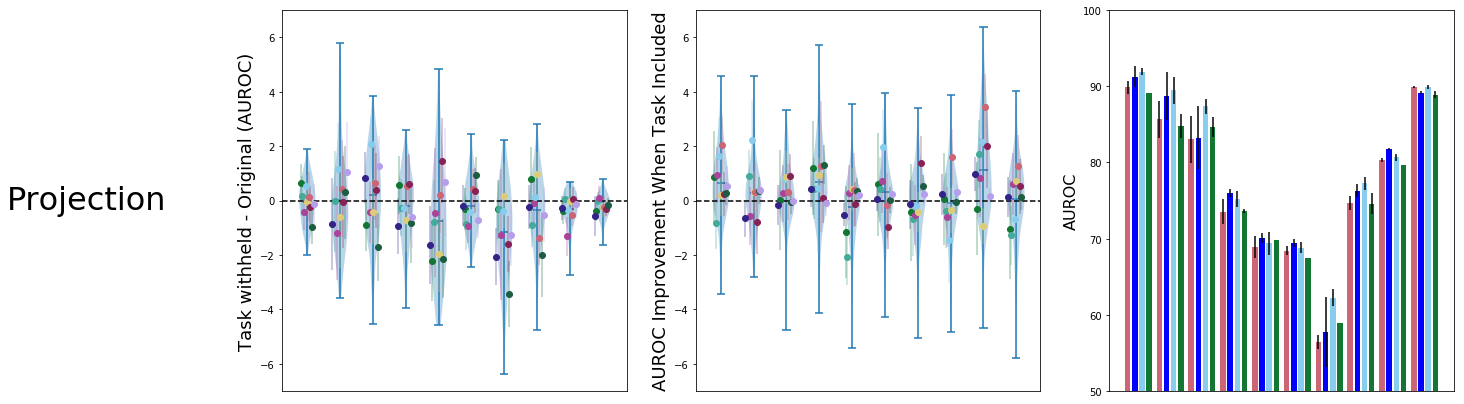

# Samples:


MT   ST  FTD  FTF          ST                                      \
    Orig Orig Orig Orig %: 2.90e-04 %: 1.78e-03 %: 3.16e-03 %: 5.62e-03   
MOR    9    1    2    5           2           4           4           3   
CMO    9    2    2    5           2           3           3           2   
DNR    9    2    2    5           2           4           3           2   
ICD    9    1    2    5           2           4           4           3   
LOS    9    1    2    5           2           4           4           3   
REA    9    1    2    5           2           4           4           2   
DIS    9    2    2    5           2           4           4           3   
ACU    9    2    2    5           2           4           3           2   
WBM    9    1    2    5           2           4           3           2   
FTS    9    2    2    5           2           4           4           2   

                                                                             \
    %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02 %: 1.00e-01 %: 1.78e-01   
MOR           5           5           5           5           2           3   
CMO           5           5           5           5           4           4   
DNR           5           5           5           5           4           3   
ICD           5           5           5           4           2           3   
LOS           4           4           4           4           3           4   
REA           5           4           4           4           3           3   
DIS           4           4           4           4           3           4   
ACU           3           4           4           4           3           4   
WBM           5           5           4           4           3           4   
FTS           5           5           5           5           3           4   

                                    FTD                                      \
    %: 3.16e-01 %: 5.62e-01 %: 2.90e-04 %: 1.78e-03 %: 3.16e-03 %: 5.62e-03   
MOR           3           1           2           2           2           2   
CMO           2           1           2           2           2           2   
DNR           2           1           2           2           2           2   
ICD           3           1           2           2           2           2   
LOS           3           1           2           2           2           2   
REA           2           1           2           2           2           2   
DIS           3           1           2           2           2           2   
ACU           2           1           2           2           2           2   
WBM           3           1           2           2           2           2   
FTS           2           1           2           2           2           2   

                                                                             \
    %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02 %: 1.00e-01 %: 1.78e-01   
MOR           2           2           2           2           2           2   
CMO           2           2           2           2           2           2   
DNR           2           2           2           2           2           2   
ICD           2           2           2           2           2           2   
LOS           2           2           2           2           2           2   
REA           2           2           2           2           2           2   
DIS           2           2           2           2           2           2   
ACU           2           2           2           2           2           2   
WBM           2           2           2           2           2           2   
FTS           2           2           2           2           2           2   

                                    FTF                                      \
    %: 3.16e-01 %: 5.62e-01 %: 1.78e-03 %: 3.16e-03 %: 5.62e-03 %: 1.00e-02   
MOR           2           2           5           5           4           5   
CMO           2      

<Figure size 1512x504 with 0 Axes>

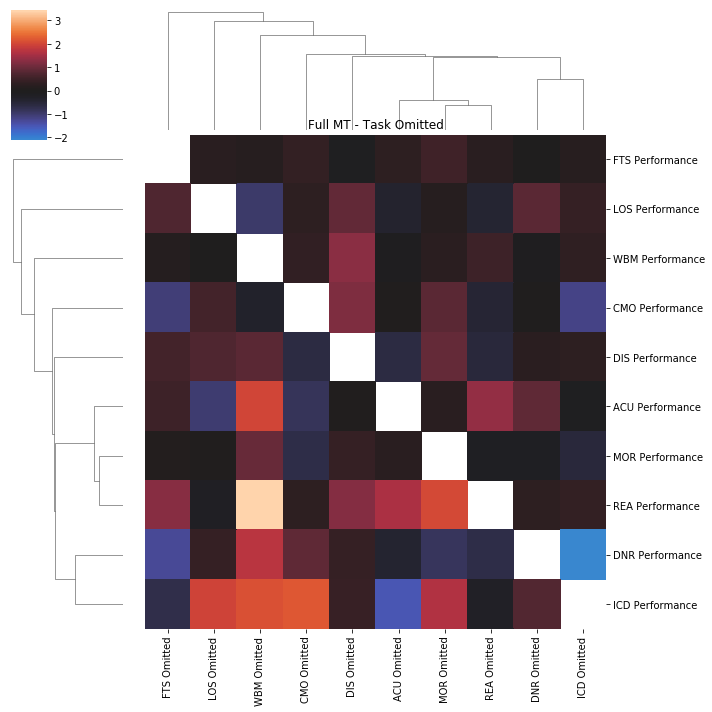

In [323]:
out = get_full_summary(
    'linear', split='test', display_ticks=False, add_titles=False,
     add_violin_points_jitter=True, add_violin_points_errorbars=True,
     show_legend=False, legend_right=False
)

[
    agg_multitask_linear, pre_train_linear, small_data_linear, small_data_full_linear, fine_tune_linear,
    fine_tune_full_linear, single_task_small_data_linear, single_task_linear, female_linear,
    female_full_linear, single_task_female_linear, num_samples_linear
] = out

In [287]:
single_task_small_data_linear['WBM']['list'][0.01]

[79.45781718581453,
 62.40262481387766,
 63.402414484609416,
 64.5428604550092,
 64.29271866025259]

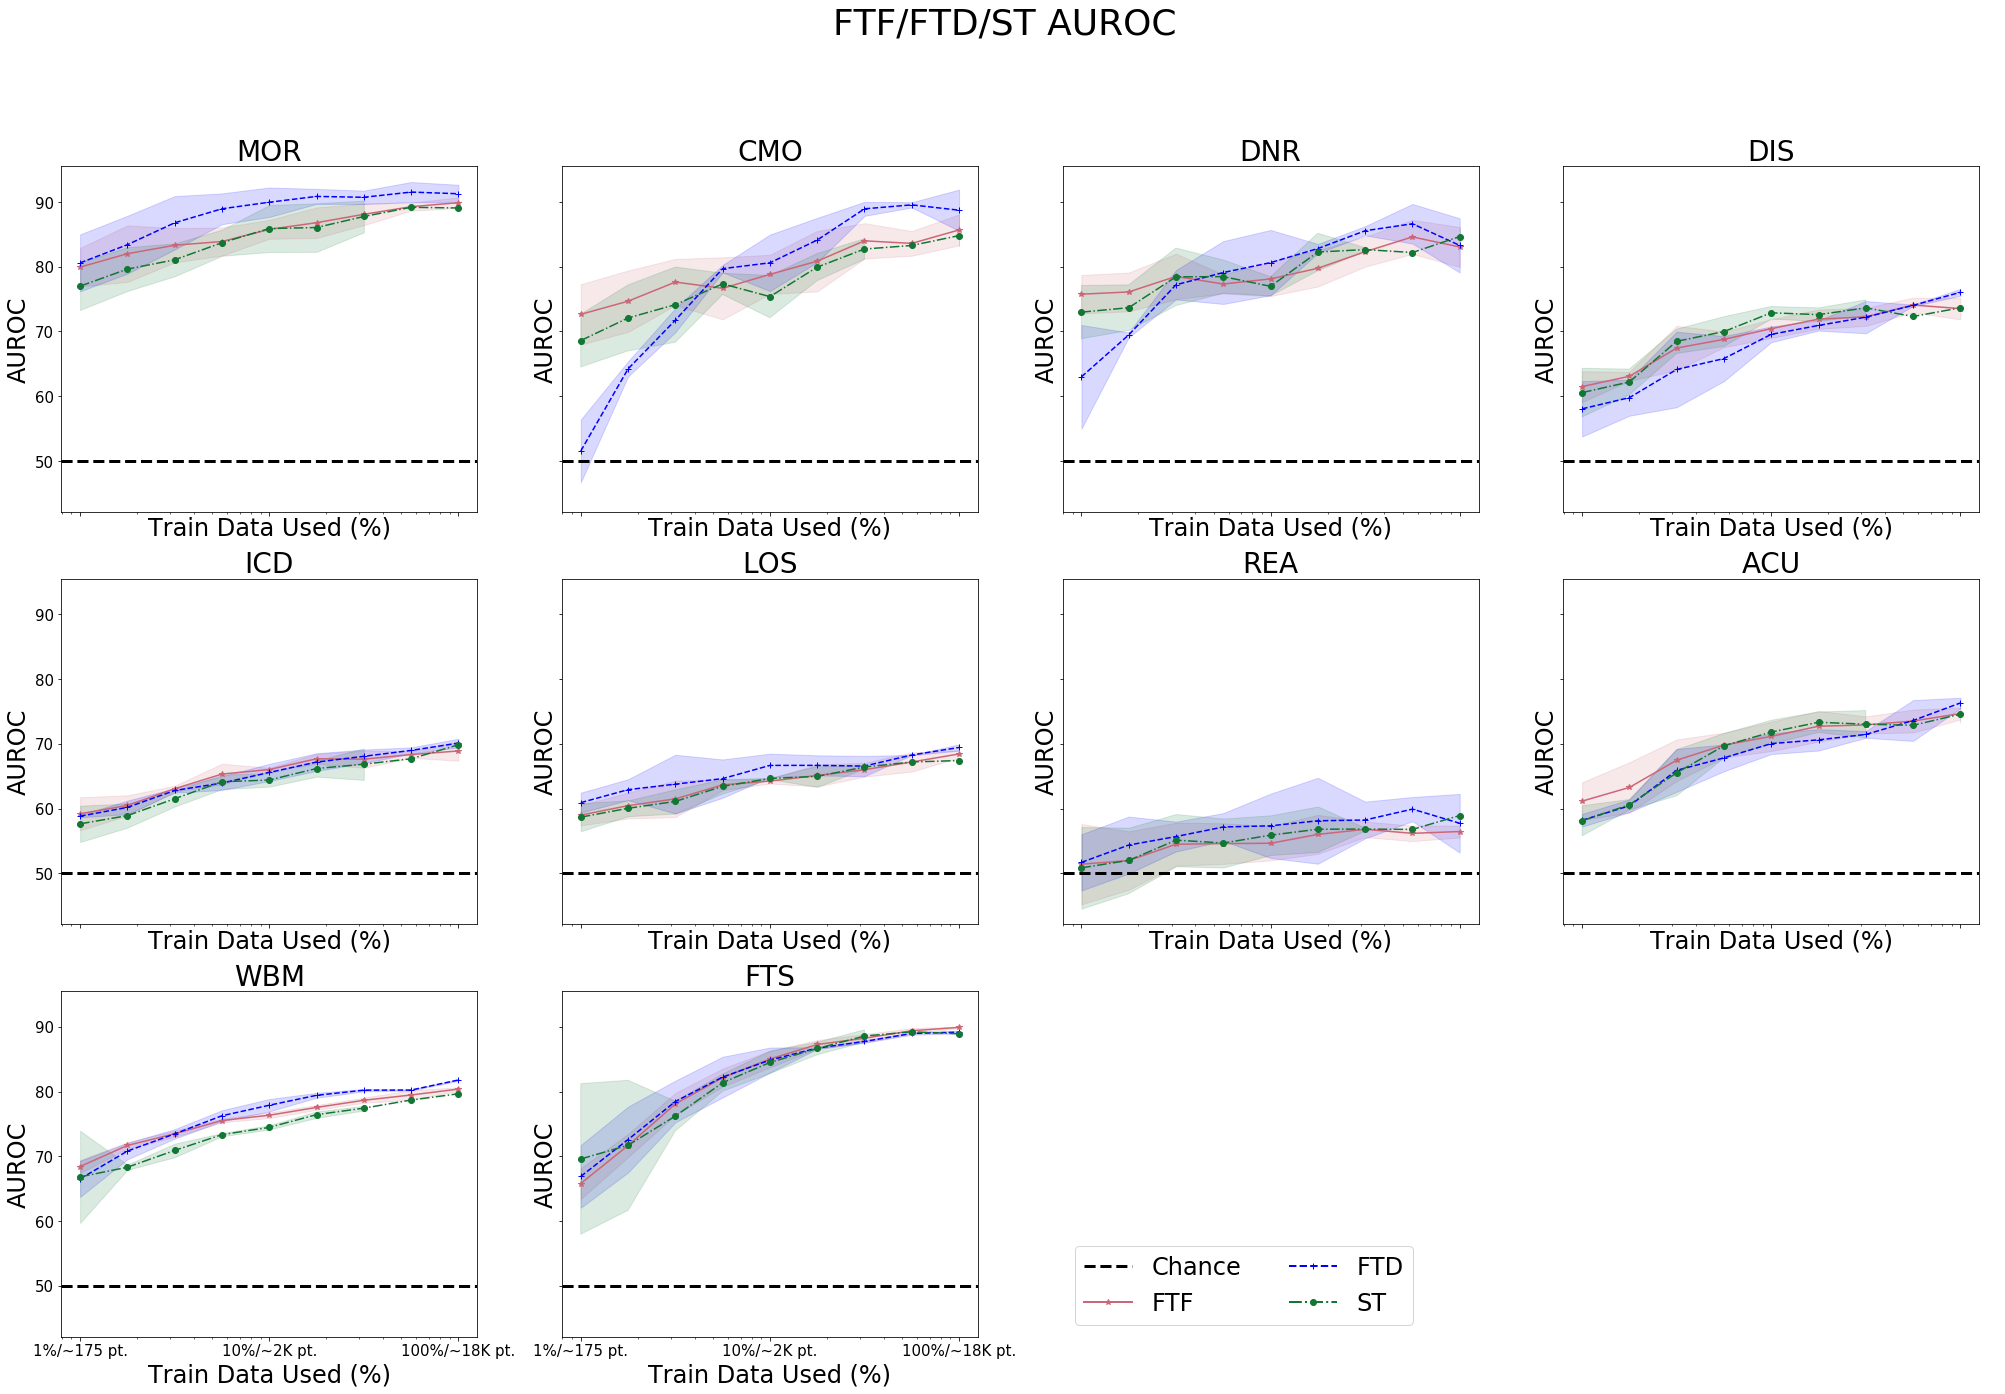

/scratch/conda_envs/latent_patients_trajectories/lib/python3.7/site-packages/matplotlib/axes/_base.py:3269: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  emit=False, auto=auto)


<Figure size 2016x1512 with 0 Axes>

In [314]:
plot_rest_data_line(
    {'ST': single_task_small_data_linear.loc[0.01:], 'FTD': small_data_linear.loc[0.01:], 'FTF': small_data_full_linear.loc[0.01:]},
    baseline = None,
    full_data_runs_by_training_mode={
        'ST': single_task_linear, 'FTD': fine_tune_linear, 'FTF': fine_tune_full_linear
    }, W = 4
)

In [324]:
old = pd.options.display.max_columns
pd.options.display.max_columns = None
display(num_samples_linear)
pd.options.display.max_columns = old

MT   ST  FTD  FTF          ST                                      \
    Orig Orig Orig Orig %: 2.90e-04 %: 1.78e-03 %: 3.16e-03 %: 5.62e-03   
MOR    9    1    2    5           2           4           4           3   
CMO    9    2    2    5           2           3           3           2   
DNR    9    2    2    5           2           4           3           2   
ICD    9    1    2    5           2           4           4           3   
LOS    9    1    2    5           2           4           4           3   
REA    9    1    2    5           2           4           4           2   
DIS    9    2    2    5           2           4           4           3   
ACU    9    2    2    5           2           4           3           2   
WBM    9    1    2    5           2           4           3           2   
FTS    9    2    2    5           2           4           4           2   

                                                                             \
    %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02 %: 1.00e-01 %: 1.78e-01   
MOR           5           5           5           5           2           3   
CMO           5           5           5           5           4           4   
DNR           5           5           5           5           4           3   
ICD           5           5           5           4           2           3   
LOS           4           4           4           4           3           4   
REA           5           4           4           4           3           3   
DIS           4           4           4           4           3           4   
ACU           3           4           4           4           3           4   
WBM           5           5           4           4           3           4   
FTS           5           5           5           5           3           4   

                                    FTD                                      \
    %: 3.16e-01 %: 5.62e-01 %: 2.90e-04 %: 1.78e-03 %: 3.16e-03 %: 5.62e-03   
MOR           3           1           2           2           2           2   
CMO           2           1           2           2           2           2   
DNR           2           1           2           2           2           2   
ICD           3           1           2           2           2           2   
LOS           3           1           2           2           2           2   
REA           2           1           2           2           2           2   
DIS           3           1           2           2           2           2   
ACU           2           1           2           2           2           2   
WBM           3           1           2           2           2           2   
FTS           2           1           2           2           2           2   

                                                                             \
    %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02 %: 1.00e-01 %: 1.78e-01   
MOR           2           2           2           2           2           2   
CMO           2           2           2           2           2           2   
DNR           2           2           2           2           2           2   
ICD           2           2           2           2           2           2   
LOS           2           2           2           2           2           2   
REA           2           2           2           2           2           2   
DIS           2           2           2           2           2           2   
ACU           2           2           2           2           2           2   
WBM           2           2           2           2           2           2   
FTS           2           2           2           2           2           2   

                                    FTF                                      \
    %: 3.16e-01 %: 5.62e-01 %: 1.78e-03 %: 3.16e-03 %: 5.62e-03 %: 1.00e-02   
MOR           2           2           5           5           4           5   
CMO           2      

In [ ]:
num_samples_display_cols(num_samples_linear)

In [326]:
print(num_samples_linear[[c for c in num_samples_linear.columns if 'emale' not in c[1] and c[1] != '0.0']].to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &        MT &        ST &       FTD &       FTF & \multicolumn{11}{l}{ST Few-Shot \%} & \multicolumn{11}{l}{FTD Few-Shot \%} & \multicolumn{11}{l}{FTF Few-Shot \%} \\
{} & Full-data & Full-data & Full-data & Full-data &           0.2 & 0.3 & 0.6 & 1.0 & 1.8 & 3.2 & 5.6 & 10.0 & 17.8 & 31.6 & 56.2 &            0.2 & 0.3 & 0.6 & 1.0 & 1.8 & 3.2 & 5.6 & 10.0 & 17.8 & 31.6 & 56.2 &            0.2 & 0.3 & 0.6 & 1.0 & 1.8 & 3.2 & 5.6 & 10.0 & 17.8 & 31.6 & 56.2 \\
\midrule
MOR &         9 &         1 &         2 &         5 &             4 &   4 &   3 &   5 &   5 &   5 &   5 &    2 &    3 &    3 &    1 &              2 &   2 &   2 &   2 &   2 &   2 &   2 &    2 &    2 &    2 &    2 &              5 &   5 &   4 &   5 &   5 &   5 &   5 &    4 &    5 &    5 &    5 \\
CMO &         9 &         2 &         2 &         5 &             3 &   3 &   2 &   5 &   5 &   5 &   5 &    4 &    4 &    2 &    1 &              2 &   2 &   2 & 

### Self Attention

Aggregate multi-task scores


,mean,std,count,max,min,list
MOR,92.8668,0.78877,7,93.6641,91.3707,"[93.27431182926104, 93.48490903324821, 93.6641..."
CMO,90.4048,0.830756,7,91.5215,88.9674,"[90.88866366987783, 90.68141305706196, 91.5215..."
DNR,86.9344,0.79969,7,87.939,85.432,"[87.4076259823336, 87.34440991000069, 86.89785..."
ICD,63.4804,1.759,7,67.4047,62.5541,"[62.554086559703784, 67.40465687635596, 62.558..."
LOS,69.2234,1.80015,7,71.6067,66.6976,"[70.03895376468192, 70.2543451693937, 71.60669..."
REA,62.1076,0.936676,7,63.3244,60.7859,"[61.641701521256934, 62.96087563855354, 62.259..."
DIS,77.4121,0.358114,7,77.8722,76.7525,"[77.65926696268302, 77.59458883933857, 76.7525..."
ACU,77.805,0.459062,7,78.6155,77.1799,"[77.45242275105959, 78.61551212478204, 77.7247..."
WBM,69.3211,0.507326,7,69.9521,68.3255,"[69.21632040931198, 69.64952040134477, 69.3653..."
FTS,88.5482,0.910757,7,89.5851,87.4993,"[87.51628630295632, 89.58513279654558, 87.4993..."


/crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0 {'readmission', 'mortality', 'los', 'future_treatment_sequence', 'dnr', 'icd10', 'cmo', 'next_timepoint_info', 'acuity', 'discharge'}
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/readmission/readmission_0-001778_1
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/mortality/mortality_0-001778_1
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/los/los_0-001778_1
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/future_treatment_sequence/future_treatment_sequence_0-001778_1
Missing /crimea/

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/cmo/cmo_0-1778_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/cmo/cmo_0-3162_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/cmo/cmo_0-5623_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/cmo/cmo_0-001778_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/next_timepoint_info/next_timepoint_info_0-001778_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/next_timepoint_

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/icd10/icd10_0-01_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/icd10/icd10_0-03162278_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/icd10/icd10_0-1_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/cmo/cmo_0-001_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/cmo/cmo_0-001778_4
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/cmo/cmo_0-00029_4
Missing /crimea/laten

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/mortality/mortality_0-3162_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/mortality/mortality_0-01778279_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/mortality/mortality_0-1_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/mortality/mortality_0-001778_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/los/los_0-005623_5
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_4/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/

validating for path: /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0 and tasks readmission, mortality, los, future_treatment_sequence, dnr, icd10, cmo, next_timepoint_info, acuity, discharge
Validating readmission
Validating mortality
Validating los
Validating future_treatment_sequence
Validating dnr
Validating icd10
Validating cmo
Validating next_timepoint_info
Validating acuity
Validating discharge
/crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0 ['icd10', 'discharge', 'mortality', 'los', 'readmission', 'future_treatment_sequence', 'acuity', 'next_timepoint_info', 'dnr', 'cmo']
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/icd10/icd10_0-001778_1
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability/v0/self_attentio

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_1/task_generalizability_ftencoder/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/next_timepoint_info/next_timepoint_info_0-001778_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_1/task_generalizability_ftencoder/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/dnr/dnr_0-03162278_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_1/task_generalizability_ftencoder/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/dnr/dnr_0-001778_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_1/task_generalizability_ftencoder/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/cmo/cmo_0-001778_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_1/task_generalizability_ftencoder/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/cmo/cmo_0-1_2
validating for path: /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/self_attention/0a87b0a83923b840

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/dnr/dnr_0-3162_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/dnr/dnr_0-05623413_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/dnr/dnr_0-1_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/dnr/dnr_0-001778_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/dnr/dnr_0-03162278_3
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_ftencoder/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/dnr/dnr_0-01_3
Missing /cr

/crimea/latent_patient_trajectories/runs/sp_20_runs_1/task_generalizability_single_female/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0 Empty DataFrame
Columns: [(ICD, Female), (DIS, Female), (MOR, Female), (LOS, Female), (REA, Female), (FTS, Female), (ACU, Female), (WBM, Female), (DNR, Female), (CMO, Female), (ICD, Male), (DIS, Male), (MOR, Male), (LOS, Male), (REA, Male), (FTS, Male), (ACU, Male), (WBM, Male), (DNR, Male), (CMO, Male)]
Index: []
/crimea/latent_patient_trajectories/runs/sp_20_runs_2/task_generalizability_single_female/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0 Empty DataFrame
Columns: [(ICD, Female), (DIS, Female), (MOR, Female), (LOS, Female), (REA, Female), (FTS, Female), (ACU, Female), (WBM, Female), (DNR, Female), (CMO, Female), (ICD, Male), (DIS, Male), (MOR, Male), (LOS, Male), (REA, Male), (FTS, Male), (ACU, Male), (WBM, Male), (DNR, Male), (CMO, Male)]
Index: []
/crimea/latent_patient_trajectories/runs/sp_20_runs_3/task_generalizability_single

,mean,std,max,min,count,list
MOR,54.2046,NaN,54.2046,54.2046,1,[54.20463038698398]
CMO,48.028,NaN,48.028,48.028,1,[48.02797812777052]
DNR,37.8734,NaN,37.8734,37.8734,1,[37.87338486147115]
ICD,53.8477,NaN,53.8477,53.8477,1,[53.847662591242255]
LOS,44.1787,NaN,44.1787,44.1787,1,[44.178746011270285]
REA,47.1747,NaN,47.1747,47.1747,1,[47.17466477197248]
DIS,54.1456,NaN,54.1456,54.1456,1,[54.14560514326263]
ACU,43.2126,NaN,43.2126,43.2126,1,[43.2125932308816]
WBM,51.5549,NaN,51.5549,51.5549,1,[51.554870036676725]
FTS,51.5217,NaN,51.5217,51.5217,1,[51.52165565155564]


Pre-train on target MT scores (unconstrained)


Aggregation Function,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list
Omitted Task,MOR,MOR,MOR,MOR,MOR,MOR,CMO,CMO,CMO,CMO,CMO,CMO,DNR,DNR,DNR,DNR,DNR,DNR,ICD,ICD,ICD,ICD,ICD,ICD,LOS,LOS,LOS,LOS,LOS,LOS,REA,REA,REA,REA,REA,REA,DIS,DIS,DIS,DIS,DIS,DIS,ACU,ACU,ACU,ACU,ACU,ACU,WBM,WBM,WBM,WBM,WBM,WBM,FTS,FTS,FTS,FTS,FTS,FTS
Measured Task,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MOR,NaN,NaN,NaN,NaN,NaN,NaN,92.764091,0.0,92.764091,92.764091,1.0,[92.76409054545816],93.148304,0.0,93.148304,93.148304,1.0,[93.14830448194718],93.843444,0.0,93.843444,93.843444,1.0,[93.8434442730829],92.970330,0.0,92.970330,92.970330,1.0,[92.97032955457712],93.121449,0.0,93.121449,93.121449,1.0,[93.12144922628075],92.002630,0.0,92.002630,92.002630,1.0,[92.00263036662864],93.399797,0.0,93.399797,93.399797,1.0,[93.39979674781974],95.081495,0.0,95.081495,95.081495,1.0,[95.08149516636824],93.223990,0.0,93.223990,93.223990,1.0,[93.2239904402353]
CMO,89.731675,0.0,89.731675,89.731675,1.0,[89.73167485562502],NaN,NaN,NaN,NaN,NaN,NaN,89.052688,0.0,89.052688,89.052688,1.0,[89.05268776042277],90.949536,0.0,90.949536,90.949536,1.0,[90.94953616788682],89.970472,0.0,89.970472,89.970472,1.0,[89.97047187422837],91.303481,0.0,91.303481,91.303481,1.0,[91.30348056447588],89.547811,0.0,89.547811,89.547811,1.0,[89.54781065242416],91.463598,0.0,91.463598,91.463598,1.0,[91.46359751483672],92.288124,0.0,92.288124,92.288124,1.0,[92.28812410682757],91.435060,0.0,91.435060,91.435060,1.0,[91.43506009362994]
DNR,89.853903,0.0,89.853903,89.853903,1.0,[89.85390297474439],86.360852,0.0,86.360852,86.360852,1.0,[86.36085165155936],NaN,NaN,NaN,NaN,NaN,NaN,87.581210,0.0,87.581210,87.581210,1.0,[87.58120973803736],86.890892,0.0,86.890892,86.890892,1.0,[86.89089203519858],88.201208,0.0,88.201208,88.201208,1.0,[88.20120773207174],86.853699,0.0,86.853699,86.853699,1.0,[86.85369881112828],87.758371,0.0,87.758371,87.758371,1.0,[87.75837126625831],89.702726,0.0,89.702726,89.702726,1.0,[89.702726240891],87.369060,0.0,87.369060,87.369060,1.0,[87.36905981846961]
ICD,63.041699,0.0,63.041699,63.041699,1.0,[63.041699365566984],62.788743,0.0,62.788743,62.788743,1.0,[62.78874259151208],61.411143,0.0,61.411143,61.411143,1.0,[61.41114314843229],NaN,NaN,NaN,NaN,NaN,NaN,62.583485,0.0,62.583485,62.583485,1.0,[62.58348541252962],61.920263,0.0,61.920263,61.920263,1.0,[61.92026347834987],62.912979,0.0,62.912979,62.912979,1.0,[62.91297944654728],61.877280,0.0,61.877280,61.877280,1.0,[61.877280204871354],64.634578,0.0,64.634578,64.634578,1.0,[64.63457809268294],65.337783,0.0,65.337783,65.337783,1.0,[65.33778286369979]
LOS,71.320185,0.0,71.320185,71.320185,1.0,[71.32018466969923],70.616726,0.0,70.616726,70.616726,1.0,[70.6167255075022],69.854114,0.0,69.854114,69.854114,1.0,[69.85411433226967],71.870375,0.0,71.870375,71.870375,1.0,[71.87037477086021],NaN,NaN,NaN,NaN,NaN,NaN,69.786051,0.0,69.786051,69.786051,1.0,[69.78605132731346],70.237202,0.0,70.237202,70.237202,1.0,[70.23720211827008],71.626129,0.0,71.626129,71.626129,1.0,[71.62612872564328],73.071576,0.0,73.071576,73.071576,1.0,[73.07157648177066],70.962217,0.0,70.962217,70.962217,1.0,[70.96221739425623]
REA,62.722563,0.0,62.722563,62.722563,1.0,[62.72256282883746],63.560281,0.0,63.560281,63.560281,1.0,[63.56028066164009],63.250313,0.0,63.250313,63.250313,1.0,[63.25031298684046],62.112289,0.0,62.112289,62.112289,1.0,[62.11228880936183],61.939190,0.0,61.939190,61.939190,1.0,[61.93918997798023],NaN,NaN,NaN,NaN,NaN,NaN,62.723972,0.0,62.723972,62.723972,1.0,[62.723971772813826],60.942865,0.0,60.942865,60.942865,1.0,[60.94286530898141],61.745561,0.0,61.745561,61.745561,1.0,[61.74556082008591],61.983069,0.0,61.983069,61.983069,1.0,[61.98306851895834]
DIS,77.274880,0.0,77.274880,77.274880,1.0,[77.27488040390116],77.409200,0.

Single task off target (should be ~0.5)


,mean,std,max,min,count
MOR,45.810566,14.599413,66.750526,18.722258,17.0
CMO,53.089073,9.659607,70.635812,37.917830,17.0
DNR,55.668993,12.034872,73.105572,29.601876,17.0
ICD,50.268543,2.346053,54.928668,45.417326,17.0
LOS,46.932362,6.266300,59.292722,36.202220,17.0
REA,48.074708,4.152822,55.079243,40.632334,17.0
DIS,50.976799,2.617340,55.145837,46.643230,17.0
ACU,49.591348,4.124089,58.867469,43.790374,17.0
WBM,49.942683,1.027833,51.513195,47.659642,17.0
FTS,53.855963,5.769989,63.191251,45.605358,9.0


Single task small data


Task                      ACU                                    \
Aggregation Function     mean       std count      max      min   
% Data                                                            
0.000290              51.2264   3.09062     3  54.3683  48.1897   
0.001000              52.4076    4.1938     4  55.8141  46.6895   
0.003162              52.6537   3.22948     4  55.3259  48.3736   
0.005623              60.7382   2.55067     4  63.5376  58.4936   
0.010000              58.1907   2.06311     4   61.014  56.0676   
0.017783              60.5288   3.18312     4   64.396  56.6031   
0.031623              65.7166   2.75309     4  69.1405  63.4349   
0.056234              68.6837   1.15359     4  69.9807  67.4429   
0.100000              72.6664   3.02359     4  75.1197  68.3972   
0.177800              75.0553   2.90169     5  77.8149  71.3971   
0.316200              78.2831  0.355695     2  78.5346  78.0316   
0.562300              78.1603  0.463367     2   78.488  77.8327   

Task                                                                     \
Aggregation Function                                               list   
% Data                                                                    
0.000290              [51.12131062326873, 54.368283179803555, nan, n...   
0.001000              [51.86174168847876, 46.68952546065269, 55.2651...   
0.003162              [55.3258707597994, 54.96363311836635, 51.95159...   
0.005623              [58.65964998156884, 63.537600326262066, 58.493...   
0.010000              [61.013985533143035, 57.689730663923285, 56.06...   
0.017783              [60.677977435692966, 60.43805201519156, 64.396...   
0.031623              [69.14046483914748, 63.539733889158654, 63.434...   
0.056234              [67.44289900198692, 69.27553002078618, 69.9807...   
0.100000              [68.39724875577255, 72.69877022729928, 74.4498...   
0.177800              [72.62563346239513, 71.39705160182768, 77.8149...   
0.316200              [78.0315893697721, 78.53461791081655, nan, nan...   
0.562300              [78.48799221536295, 77.8326926317149, nan, nan...   

Task                      CMO                                    \
Aggregation Function     mean       std count      max      min   
% Data                                                            
0.000290              55.5998   4.32802     2  58.6602  52.5395   
0.001000              53.2536    11.708     3  62.1708   39.995   
0.003162              54.3387   2.81761     4  58.3385  52.3341   
0.005623              54.3506   3.78034     4  58.4923  50.8488   
0.010000              66.2485   7.96118     4  72.8522   55.408   
0.017783              62.7251   10.3336     4  77.2213  52.7992   
0.031623              73.0531   5.69958     4   81.351  69.0861   
0.056234              69.5886   17.3287     4  83.4461  44.2484   
0.100000              79.2246   4.12759     3  83.7004  75.5681   
0.177800              77.1608   5.66411     3  83.6874  73.5304   
0.316200               85.449   1.50926     3  86.6024  83.7408   
0.562300              87.5793  0.697898     2  88.0727  87.0858   

Task                                                                     \
Aggregation Function                                               list   
% Data                                                                    
0.000290              [52.53945369306033, 58.66019854866125, nan, na...   
0.001000              [62.17079512551963, 57.59494186674608, 39.9949...   
0.003162              [58.338477711841506, 52.38988715294441, 54.292...   
0.005623              [50.848834584466516, 56.6048417889929, 51.4565...   
0.010000              [72.85224110566688, 55.407954091201105, 65.201...   
0.017783              [52.79924767795624, 61.22910985724324, 59.6509...   
0.031623              [72.20774553496419, 69.08608963828901, 81.3510...   
0.056234              [44.2483649177695, 74.71093152214227, 83.44610...   
0.100000              [75.56807416182

single task - multi-task


MOR     -1.59091
CMO     -3.96876
DNR      1.13525
ICD      8.95632
LOS    0.0748675
REA     -1.86304
DIS      3.97833
ACU      3.04218
WBM     -2.71915
FTS    -0.450015
Name: mean, dtype: object

Fine tune off target (unconstrained)


,mean,std,max,min,count
MOR,93.073187,1.379516,95.365575,90.452185,9
CMO,90.624909,0.850670,92.275934,89.483452,9
DNR,87.831834,1.475414,89.025120,84.201258,9
ICD,63.213738,1.090579,65.457678,62.155087,9
LOS,70.242784,2.178875,73.674299,65.847478,9
REA,62.150084,0.654110,62.811930,60.667920,9
DIS,77.366174,1.694028,81.557201,75.410260,9
ACU,78.117514,1.432881,81.026092,75.853148,9
WBM,69.502030,1.297547,71.387008,67.701515,9
FTS,88.572087,0.634244,89.465990,87.680379,9


fine tune (decoder only) - multi-task


MOR     0.444026
CMO     -2.52001
DNR    -0.647403
ICD     0.429568
LOS     0.564314
REA   -0.0272875
DIS     -1.58737
ACU     -2.09507
WBM      5.55118
FTS    -0.170805
Name: mean, dtype: object

fine tune (full model) - multi-task


MOR     1.86482
CMO    0.119303
DNR     1.27754
ICD      9.8901
LOS     2.81172
REA    -1.01959
DIS     2.80478
ACU     2.57329
WBM    -1.76143
FTS     2.18796
Name: mean, dtype: object

fine tune (decoder only) - single task


MOR     2.03493
CMO     1.44875
DNR    -1.78265
ICD    -8.52675
LOS    0.489447
REA     1.83575
DIS     -5.5657
ACU    -5.13725
WBM     8.27033
FTS    0.279211
Name: mean, dtype: object

fine tune (full model) - single task


MOR     3.45573
CMO     4.08807
DNR    0.142291
ICD    0.933784
LOS     2.73686
REA    0.843454
DIS    -1.17356
ACU   -0.468881
WBM    0.957721
FTS     2.63797
Name: mean, dtype: object

fine tune (full model) - fine tune (decoder only)


MOR     1.42079
CMO     2.63932
DNR     1.92494
ICD     9.46054
LOS     2.24741
REA   -0.992299
DIS     4.39214
ACU     4.66837
WBM    -7.31261
FTS     2.35876
Name: mean, dtype: object

Omitted Task,MOR,CMO,DNR,ICD,LOS,REA,DIS,ACU,WBM,FTS
Measured Task,,,,,,,,,,
MOR,NaN,92.764091,93.148304,93.843444,92.970330,93.121449,92.002630,93.399797,95.081495,93.223990
CMO,89.731675,NaN,89.052688,90.949536,89.970472,91.303481,89.547811,91.463598,92.288124,91.435060
DNR,89.853903,86.360852,NaN,87.581210,86.890892,88.201208,86.853699,87.758371,89.702726,87.369060
ICD,63.041699,62.788743,61.411143,NaN,62.583485,61.920263,62.912979,61.877280,64.634578,65.337783
LOS,71.320185,70.616726,69.854114,71.870375,NaN,69.786051,70.237202,71.626129,73.071576,70.962217
REA,62.722563,63.560281,63.250313,62.112289,61.939190,NaN,62.723972,60.942865,61.745561,61.983069
DIS,77.274880,77.409200,76.537512,76.422208,76.180638,76.736604,NaN,75.855643,81.754486,77.568520
ACU,78.580492,77.836835,76.731475,78.292889,77.707646,77.756298,75.304283,NaN,80.493137,77.441958
WBM,70.296361,69.985446,68.468355,70.133152,69.389068,68.065948,68.951591,69.424077,NaN,69.687211


,mean,std,count,max,min,list
MOR,92.8668,0.78877,7,93.6641,91.3707,"[93.27431182926104, 93.48490903324821, 93.6641..."
CMO,90.4048,0.830756,7,91.5215,88.9674,"[90.88866366987783, 90.68141305706196, 91.5215..."
DNR,86.9344,0.79969,7,87.939,85.432,"[87.4076259823336, 87.34440991000069, 86.89785..."
ICD,63.4804,1.759,7,67.4047,62.5541,"[62.554086559703784, 67.40465687635596, 62.558..."
LOS,69.2234,1.80015,7,71.6067,66.6976,"[70.03895376468192, 70.2543451693937, 71.60669..."
REA,62.1076,0.936676,7,63.3244,60.7859,"[61.641701521256934, 62.96087563855354, 62.259..."
DIS,77.4121,0.358114,7,77.8722,76.7525,"[77.65926696268302, 77.59458883933857, 76.7525..."
ACU,77.805,0.459062,7,78.6155,77.1799,"[77.45242275105959, 78.61551212478204, 77.7247..."
WBM,69.3211,0.507326,7,69.9521,68.3255,"[69.21632040931198, 69.64952040134477, 69.3653..."
FTS,88.5482,0.910757,7,89.5851,87.4993,"[87.51628630295632, 89.58513279654558, 87.4993..."


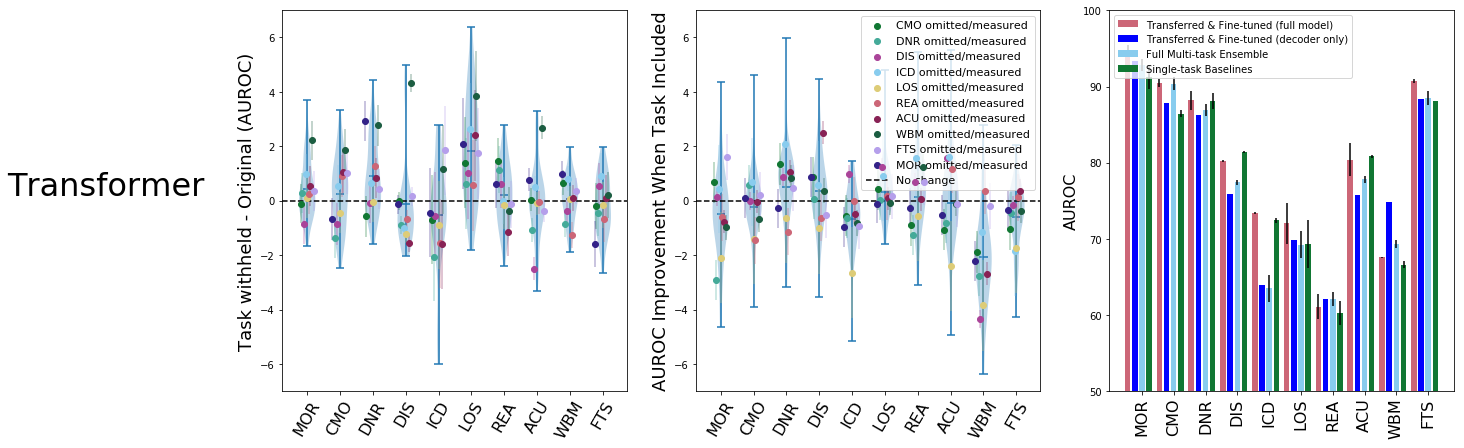

# Samples:


MT   ST  FTD  FTF          ST                                      \
    Orig Orig Orig Orig %: 2.90e-04 %: 1.00e-03 %: 3.16e-03 %: 5.62e-03   
MOR    7    2    1    3           4           4           3           3   
CMO    7    2    1    2           2           3           4           4   
DNR    7    2    1    3           3           4           3           3   
ICD    7    2    1    3           3           4           3           3   
LOS    7    2    1    3           3           3           4           3   
REA    7    2    1    3           4           3           5           4   
DIS    7    2    1    3           4           3           4           4   
ACU    7    2    1    3           3           4           4           4   
WBM    7    2    1    2           3           4           3           4   
FTS    7    1    1    3           3           3           3           3   

                                                                             \
    %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02 %: 1.00e-01 %: 1.78e-01   
MOR           3           3           3           3           3           3   
CMO           4           4           4           4           3           3   
DNR           3           3           3           3           3           2   
ICD           3           3           3           3           3           4   
LOS           3           3           3           3           3           2   
REA           4           4           4           4           4           4   
DIS           3           3           3           3           3           4   
ACU           4           4           4           4           4           5   
WBM           3           3           3           3           3           5   
FTS           3           3           3           3           3           3   

                                    FTD                                      \
    %: 3.16e-01 %: 5.62e-01 %: 2.90e-04 %: 1.00e-03 %: 3.16e-03 %: 5.62e-03   
MOR           2           3           1           1           1           1   
CMO           3           2           1           1           1           1   
DNR           3           2           1           1           1           1   
ICD           4           2           1           1           1           1   
LOS           2           2           1           1           1           1   
REA           2           2           1           1           1           1   
DIS           3           2           1           1           1           1   
ACU           2           2           1           1           1           1   
WBM           3           3           1           1           1           1   
FTS           3           3           1           1           1           1   

                                                                             \
    %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02 %: 1.00e-01 %: 1.78e-01   
MOR           1           1           1           1           1           1   
CMO           1           1           1           1           1           1   
DNR           1           1           1           1           1           1   
ICD           1           1           1           1           1           1   
LOS           1           1           1           1           1           1   
REA           1           1           1           1           1           1   
DIS           1           1           1           1           1           1   
ACU           1           1           1           1           1           1   
WBM           1           1           1           1           1           1   
FTS           1           1           1           1           1           1   

                                    FTF                                      \
    %: 3.16e-01 %: 5.62e-01 %: 1.00e-03 %: 3.16e-03 %: 5.62e-03 %: 1.00e-02   
MOR           1           1           3           3           3           3   
CMO           1      

<Figure size 1512x504 with 0 Axes>

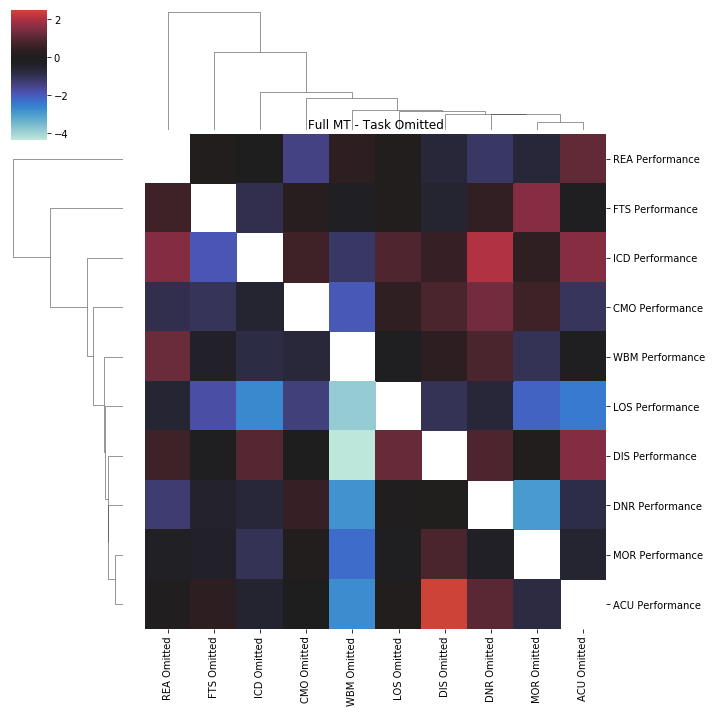

In [317]:
out = get_full_summary(
    'self_attention', split='test', add_titles=False, 
    add_violin_points_jitter=True, add_violin_points_errorbars=True,
    show_legend=True, legend_right=False
)
[
    agg_multitask_self_attention, pre_train_self_attention,
    small_data_self_attention, small_data_full_self_attention, fine_tune_self_attention,
    fine_tune_full_self_attention, single_task_small_data_self_attention, single_task_self_attention,
    female_self_attention, female_full_self_attention, single_task_female_self_attention,
    num_samples_self_attention
] = out

Aggregate multi-task scores


,mean,std,count,max,min,list
MOR,43.8107,3.19308,7,47.6692,39.1622,"[46.16799114768592, 43.192901121982445, 47.669..."
CMO,12.993,2.95981,7,16.1349,7.4776,"[16.134883883048502, 12.62838114971911, 16.084..."
DNR,13.3565,1.50688,7,16.6101,12.3087,"[13.325452099734578, 12.335910069055545, 13.51..."
ICD,47.2514,0.419344,7,47.7811,46.8242,"[46.94026027415614, 47.75737565475682, 46.8241..."
LOS,65.8793,2.10139,7,68.8407,62.5681,"[65.49511801472512, 67.01221791389752, 68.8406..."
REA,8.61016,0.402698,7,9.27138,8.08274,"[8.470520470686335, 8.514837780945712, 8.98137..."
DIS,0,0,7,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
ACU,0,0,7,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
WBM,22.3193,0.415712,7,22.8799,21.6044,"[22.444674055600185, 22.879863068305724, 21.99..."
FTS,0,0,7,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


validating for path: /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0 and tasks readmission, mortality, los, future_treatment_sequence, dnr, icd10, cmo, next_timepoint_info, acuity, discharge
Validating readmission
Validating mortality
Validating los
Validating future_treatment_sequence
Validating dnr
Validating icd10
Validating cmo
Validating next_timepoint_info
Validating acuity
Validating discharge
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/icd10/icd10_0-03162278_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/icd10/icd10_0-1_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/icd10/icd10_0-1778_2
Missing /crimea/late

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/future_treatment_sequence/future_treatment_sequence_0-01778279_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/acuity/acuity_0-00029_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/acuity/acuity_0-1_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/acuity/acuity_0-01_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/acuity/acuity_0-05623413_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f

Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/cmo/cmo_0-03162278_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/cmo/cmo_0-001_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/cmo/cmo_0-003162_2
Missing /crimea/latent_patient_trajectories/runs/sp_20_runs/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0/cmo/cmo_0-1_2
validating for path: /crimea/latent_patient_trajectories/runs/sp_20_runs_1/task_generalizability_single/v0/self_attention/0a87b0a83923b840442cbc187f4c9095/0 and tasks readmission, mortality, los, dnr, icd10, cmo, next_timepoint_info, acuity, discharge
Validating readmission
Validating mortality
Validating los
Validating dnr
Validating icd10
Validating cmo
Vali

Pre-train off target (should be ~0.5)


,mean,std,max,min,count,list
MOR,17.5678,NaN,17.5678,17.5678,1,[17.567769168509972]
CMO,1.20609,NaN,1.20609,1.20609,1,[1.2060876508541742]
DNR,0.979724,NaN,0.979724,0.979724,1,[0.9797239519416505]
ICD,37.9791,NaN,37.9791,37.9791,1,[37.979064127099925]
LOS,44.3146,NaN,44.3146,44.3146,1,[44.31458472638211]
REA,4.98575,NaN,4.98575,4.98575,1,[4.985746270724251]
DIS,0,NaN,0,0,1,[0.0]
ACU,0,NaN,0,0,1,[0.0]
WBM,15.244,NaN,15.244,15.244,1,[15.243987321138993]
FTS,0,NaN,0,0,1,[0.0]


Pre-train on target MT scores (unconstrained)


Aggregation Function,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list,mean,std,min,max,count,list
Omitted Task,MOR,MOR,MOR,MOR,MOR,MOR,CMO,CMO,CMO,CMO,CMO,CMO,DNR,DNR,DNR,DNR,DNR,DNR,ICD,ICD,ICD,ICD,ICD,ICD,LOS,LOS,LOS,LOS,LOS,LOS,REA,REA,REA,REA,REA,REA,DIS,DIS,DIS,DIS,DIS,DIS,ACU,ACU,ACU,ACU,ACU,ACU,WBM,WBM,WBM,WBM,WBM,WBM,FTS,FTS,FTS,FTS,FTS,FTS
Measured Task,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MOR,NaN,NaN,NaN,NaN,NaN,NaN,42.567161,0.0,42.567161,42.567161,1.0,[42.56716098594126],46.508568,0.0,46.508568,46.508568,1.0,[46.50856768003586],47.254130,0.0,47.254130,47.254130,1.0,[47.254129865126615],44.369998,0.0,44.369998,44.369998,1.0,[44.36999794755111],45.160673,0.0,45.160673,45.160673,1.0,[45.160672559256454],42.658991,0.0,42.658991,42.658991,1.0,[42.658991353801035],45.236127,0.0,45.236127,45.236127,1.0,[45.23612745650289],44.580185,0.0,44.580185,44.580185,1.0,[44.58018492696625],45.363366,0.0,45.363366,45.363366,1.0,[45.363365894411814]
CMO,13.629813,0.0,13.629813,13.629813,1.0,[13.629812934458835],NaN,NaN,NaN,NaN,NaN,NaN,11.555266,0.0,11.555266,11.555266,1.0,[11.555265895018437],13.347439,0.0,13.347439,13.347439,1.0,[13.347439076159242],12.960025,0.0,12.960025,12.960025,1.0,[12.960025214116891],12.371511,0.0,12.371511,12.371511,1.0,[12.371510843598148],7.821040,0.0,7.821040,7.821040,1.0,[7.821039760988138],10.462442,0.0,10.462442,10.462442,1.0,[10.462441631209222],10.026526,0.0,10.026526,10.026526,1.0,[10.026525541850242],10.798609,0.0,10.798609,10.798609,1.0,[10.798609020156258]
DNR,14.406166,0.0,14.406166,14.406166,1.0,[14.406165777230367],8.775574,0.0,8.775574,8.775574,1.0,[8.77557417946089],NaN,NaN,NaN,NaN,NaN,NaN,9.572086,0.0,9.572086,9.572086,1.0,[9.572085519427345],11.492996,0.0,11.492996,11.492996,1.0,[11.492995890423286],11.888061,0.0,11.888061,11.888061,1.0,[11.888061445649642],12.420777,0.0,12.420777,12.420777,1.0,[12.420776501624124],14.137317,0.0,14.137317,14.137317,1.0,[14.137316821720217],11.665070,0.0,11.665070,11.665070,1.0,[11.66507010211072],9.384489,0.0,9.384489,9.384489,1.0,[9.38448874142653]
ICD,47.417443,0.0,47.417443,47.417443,1.0,[47.417442632155456],47.293719,0.0,47.293719,47.293719,1.0,[47.29371931398468],46.133327,0.0,46.133327,46.133327,1.0,[46.13332689484287],NaN,NaN,NaN,NaN,NaN,NaN,46.844949,0.0,46.844949,46.844949,1.0,[46.84494853810296],46.413949,0.0,46.413949,46.413949,1.0,[46.41394863086544],47.094178,0.0,47.094178,47.094178,1.0,[47.094178456180494],46.666919,0.0,46.666919,46.666919,1.0,[46.6669189784759],47.065671,0.0,47.065671,47.065671,1.0,[47.0656708691493],48.268102,0.0,48.268102,48.268102,1.0,[48.26810187367889]
LOS,68.429543,0.0,68.429543,68.429543,1.0,[68.42954255651613],68.294372,0.0,68.294372,68.294372,1.0,[68.29437151573292],67.096663,0.0,67.096663,67.096663,1.0,[67.0966627001628],68.701508,0.0,68.701508,68.701508,1.0,[68.70150811876701],NaN,NaN,NaN,NaN,NaN,NaN,67.282708,0.0,67.282708,67.282708,1.0,[67.28270820982884],67.844070,0.0,67.844070,67.844070,1.0,[67.8440696970149],68.827171,0.0,68.827171,68.827171,1.0,[68.82717113456252],70.942026,0.0,70.942026,70.942026,1.0,[70.94202555183749],68.215869,0.0,68.215869,68.215869,1.0,[68.21586935027423]
REA,8.695241,0.0,8.695241,8.695241,1.0,[8.69524071724064],8.730605,0.0,8.730605,8.730605,1.0,[8.730605404170035],9.053109,0.0,9.053109,9.053109,1.0,[9.053108835932909],8.379134,0.0,8.379134,8.379134,1.0,[8.379134289892114],8.773722,0.0,8.773722,8.773722,1.0,[8.77372164223477],NaN,NaN,NaN,NaN,NaN,NaN,8.829967,0.0,8.829967,8.829967,1.0,[8.829966991523747],8.397650,0.0,8.397650,8.397650,1.0,[8.397650268447576],7.502020,0.0,7.502020,7.502020,1.0,[7.502019886103262],8.864385,0.0,8.864385,8.864385,1.0,[8.864385155244145]
DIS,0.000000,0.0,0.000000,0.000000,1.0,[0.0],0.000000,0.0,0.000000,0.000000,1.0,[0.0],0.000000,0.0,0

Single task off target (should be ~0.5)


,mean,std,max,min,count
MOR,5.603857,3.532192,13.527214,2.162648,17.0
CMO,2.098236,1.950201,8.780906,0.837676,17.0
DNR,2.554391,1.945386,7.898100,0.882876,17.0
ICD,36.575031,0.738148,38.034117,35.386511,17.0
LOS,45.970764,4.947847,56.696870,40.116723,17.0
REA,5.433389,0.646135,6.533306,4.355901,17.0
DIS,0.000000,0.000000,0.000000,0.000000,17.0
ACU,0.000000,0.000000,0.000000,0.000000,17.0
WBM,14.988961,0.267279,15.305410,14.610325,17.0
FTS,0.000000,0.000000,0.000000,0.000000,9.0


Single task small data


Task                  ACU                                    CMO            \
Aggregation Function mean std count max min        list     mean       std   
% Data                                                                       
0.010000                0   0     2   0   0  [0.0, 0.0]  4.93617  0.405333   
0.017783                0   0     2   0   0  [0.0, 0.0]  5.87466   2.15737   
0.031623                0   0     2   0   0  [0.0, 0.0]  4.47013  0.384246   
0.056234                0   0     2   0   0  [0.0, 0.0]  7.02772   5.69781   
0.100000                0   0     2   0   0  [0.0, 0.0]  9.07182   3.92292   
0.177800                0   0     2   0   0  [0.0, 0.0]   11.175   8.05375   
0.316200                0   0     2   0   0  [0.0, 0.0]  9.94061  0.713136   
0.562300                0   0     2   0   0  [0.0, 0.0]  12.6908    1.3147   

Task                                          \
Aggregation Function count      max      min   
% Data                                         
0.010000                 2  5.22279  4.64956   
0.017783                 2  7.40015  4.34917   
0.031623                 2  4.74184  4.19843   
0.056234                 2  11.0567  2.99876   
0.100000                 2  11.8457  6.29789   
0.177800                 2  16.8698   5.4801   
0.316200                 2  10.4449  9.43635   
0.562300                 2  13.6204  11.7611   

Task                                                            DIS            \
Aggregation Function                                      list mean std count   
% Data                                                                          
0.010000                [5.222786335908847, 4.649559319637654]    0   0     2   
0.017783                [4.349166844580203, 7.400153188619971]    0   0     2   
0.031623                  [4.7418359226215, 4.198430656766621]    0   0     2   
0.056234              [2.9987616135992425, 11.056676162331907]    0   0     2   
0.100000                [6.29789377110139, 11.845737814457614]    0   0     2   
0.177800               [5.480103748052015, 16.869831698831323]    0   0     2   
0.316200               [9.436351276731852, 10.444878242225112]    0   0     2   
0.562300               [11.76112604705359, 13.620392647093366]    0   0     2   

Task                                          DNR                           \
Aggregation Function max min        list     mean       std count      max   
% Data                                                                       
0.010000               0   0  [0.0, 0.0]  6.72676  0.279411     2  6.92434   
0.017783               0   0  [0.0, 0.0]  5.41206   0.94814     2  6.08249   
0.031623               0   0  [0.0, 0.0]  6.89542  0.453726     2  7.21625   
0.056234               0   0  [0.0, 0.0]  7.02255   1.73902     2  8.25222   
0.100000               0   0  [0.0, 0.0]   7.5161   0.30511     2  7.73185   
0.177800               0   0  [0.0, 0.0]  8.80428   3.06302     2  10.9702   
0.316200               0   0  [0.0, 0.0]  12.3661  0.433818     2  12.6728   
0.562300               0   0  [0.0, 0.0]   9.7895  0.346527     2  10.0345   

Task                                                                    FTS  \
Aggregation Function      min                                     list mean   
% Data                                                                        
0.010000              6.52919   [6.529189263724006, 6.924335584349517]    0   
0.017783              4.74162   [4.741620363635822, 6.082492354276655]    0   
0.031623              6.57458  [6.574582996221734, 7.2162485878195834]    0   
0.056234              5.79288   [5.792884405497122, 8.252224077860914]    0   
0.100000              7.30036   [7.300357951077288, 7.731848194452655]    0   
0.177800               6.6384   [6.638402160571355, 10.97016551610721]    0   
0.316200              12.0593  [12.05933203251927, 12.672843732027554]    0   
0.562300              9.54447  [10.034527996891251, 9.544465487664077] 

single task - multi-task


MOR     1.24423
CMO    -6.02999
DNR     1.52315
ICD     6.45693
LOS   -0.217559
REA   -0.495671
DIS           0
ACU           0
WBM     -1.6386
FTS           0
Name: mean, dtype: object

Fine tune off target (unconstrained)


,mean,std,max,min,count
MOR,44.984127,3.495029,48.958308,37.270827,9
CMO,11.945245,2.506002,16.423448,9.092731,9
DNR,11.961062,2.351393,15.004451,8.345859,9
ICD,47.234839,0.462582,48.264355,46.675496,9
LOS,67.209958,2.353114,71.284714,62.723009,9
REA,8.669913,0.508122,9.552394,7.753467,9
DIS,0.000000,0.000000,0.000000,0.000000,9
ACU,0.000000,0.000000,0.000000,0.000000,9
WBM,22.509064,1.051625,24.198543,21.089656,9
FTS,0.000000,0.000000,0.000000,0.000000,9


fine tune (decoder only) - multi-task


MOR     -3.3079
CMO    -3.77424
DNR   -0.863279
ICD     1.36883
LOS     1.60657
REA    0.856697
DIS           0
ACU           0
WBM     2.24275
FTS           0
Name: mean, dtype: object

fine tune (full model) - multi-task


MOR     7.48226
CMO     1.00963
DNR    0.695403
ICD     7.37227
LOS     5.91033
REA    0.741551
DIS           0
ACU           0
WBM    -1.12115
FTS           0
Name: mean, dtype: object

fine tune (decoder only) - single task


MOR   -4.55213
CMO    2.25575
DNR   -2.38643
ICD    -5.0881
LOS    1.82413
REA    1.35237
DIS          0
ACU          0
WBM    3.88135
FTS          0
Name: mean, dtype: object

fine tune (full model) - single task


MOR     6.23803
CMO     7.03962
DNR    -0.82775
ICD    0.915338
LOS     6.12789
REA     1.23722
DIS           0
ACU           0
WBM    0.517452
FTS           0
Name: mean, dtype: object

fine tune (full model) - fine tune (decoder only)


MOR     10.7902
CMO     4.78387
DNR     1.55868
ICD     6.00344
LOS     4.30376
REA   -0.115147
DIS           0
ACU           0
WBM     -3.3639
FTS           0
Name: mean, dtype: object

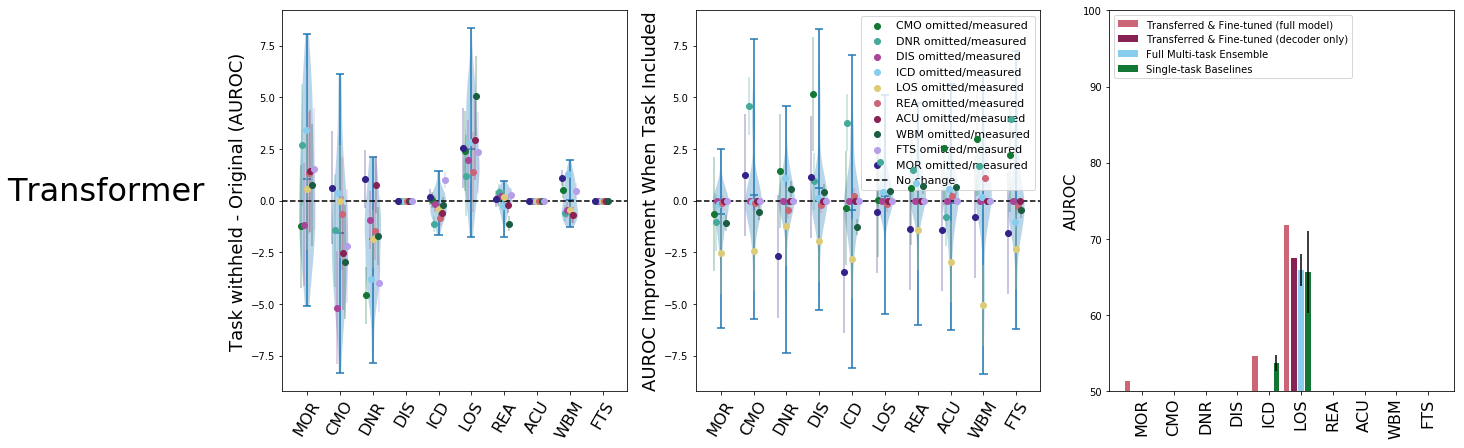

# Samples:


MT   ST  FTD  FTF          ST                                      \
    Orig Orig Orig Orig %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02   
MOR    7    2    1    1           2           2           2           2   
CMO    7    2    1    1           2           2           2           2   
DNR    7    2    1    1           2           2           2           2   
ICD    7    2    1    1           2           2           2           2   
LOS    7    2    1    1           2           2           2           2   
REA    7    2    1    1           2           2           2           2   
DIS    7    2    1    1           2           2           2           2   
ACU    7    2    1    1           2           2           2           2   
WBM    7    2    1    1           2           2           2           2   
FTS    7    1    1    1           1           1           1           1   

                                                            FTD              \
    %: 1.00e-01 %: 1.78e-01 %: 3.16e-01 %: 5.62e-01 %: 1.00e-02 %: 1.78e-02   
MOR           2           2           2           2           1           1   
CMO           2           2           2           2           1           1   
DNR           2           2           2           2           1           1   
ICD           2           2           2           2           1           1   
LOS           2           2           2           2           1           1   
REA           2           2           2           2           1           1   
DIS           2           2           2           2           1           1   
ACU           2           2           2           2           1           1   
WBM           2           2           2           2           1           1   
FTS           1           1           1           1           1           1   

                                                                             \
    %: 3.16e-02 %: 5.62e-02 %: 1.00e-01 %: 1.78e-01 %: 3.16e-01 %: 5.62e-01   
MOR           1           1           1           1           1           1   
CMO           1           1           1           1           1           1   
DNR           1           1           1           1           1           1   
ICD           1           1           1           1           1           1   
LOS           1           1           1           1           1           1   
REA           1           1           1           1           1           1   
DIS           1           1           1           1           1           1   
ACU           1           1           1           1           1           1   
WBM           1           1           1           1           1           1   
FTS           1           1           1           1           1           1   

            FTF                                                              \
    %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02 %: 1.00e-01 %: 1.78e-01   
MOR           1           1           1           1           1           1   
CMO           1           1           1           1           1           1   
DNR           1           1           1           1           1           1   
ICD           1           1           1           1           1           1   
LOS           1           1           1           1           1           1   
REA           1           1           1           1           1           1   
DIS           1           1           1           1           1           1   
ACU           1           1           1           1           1           1   
WBM           1           1           1           1           1           1   
FTS           1           1           1           1           1           1   

                                     ST         FTD         FTF  
    %: 3.16e-01 %: 5.62e-01 % Female: ? % Female: ? % Female: ?  
MOR           1           1           0           0           0  
CMO           1           1           0           0         

<Figure size 1512x504 with 0 Axes>

In [110]:
out = get_full_summary(
    'self_attention', split='test', add_titles=False, 
    add_violin_points_jitter=True, add_violin_points_errorbars=True,
    auprc=True, show_legend=True, legend_right=False
)
[
    agg_multitask_self_attention_auprc, pre_train_self_attention_auprc,
    small_data_self_attention_auprc, small_data_full_self_attention_auprc, fine_tune_self_attention_auprc,
    fine_tune_full_self_attention_auprc, single_task_small_data_self_attention_auprc, single_task_self_attention_auprc,
    female_self_attention_auprc, female_full_self_attention_auprc, single_task_female_self_attention_auprc,
    num_samples_self_attention_auprc
] = out

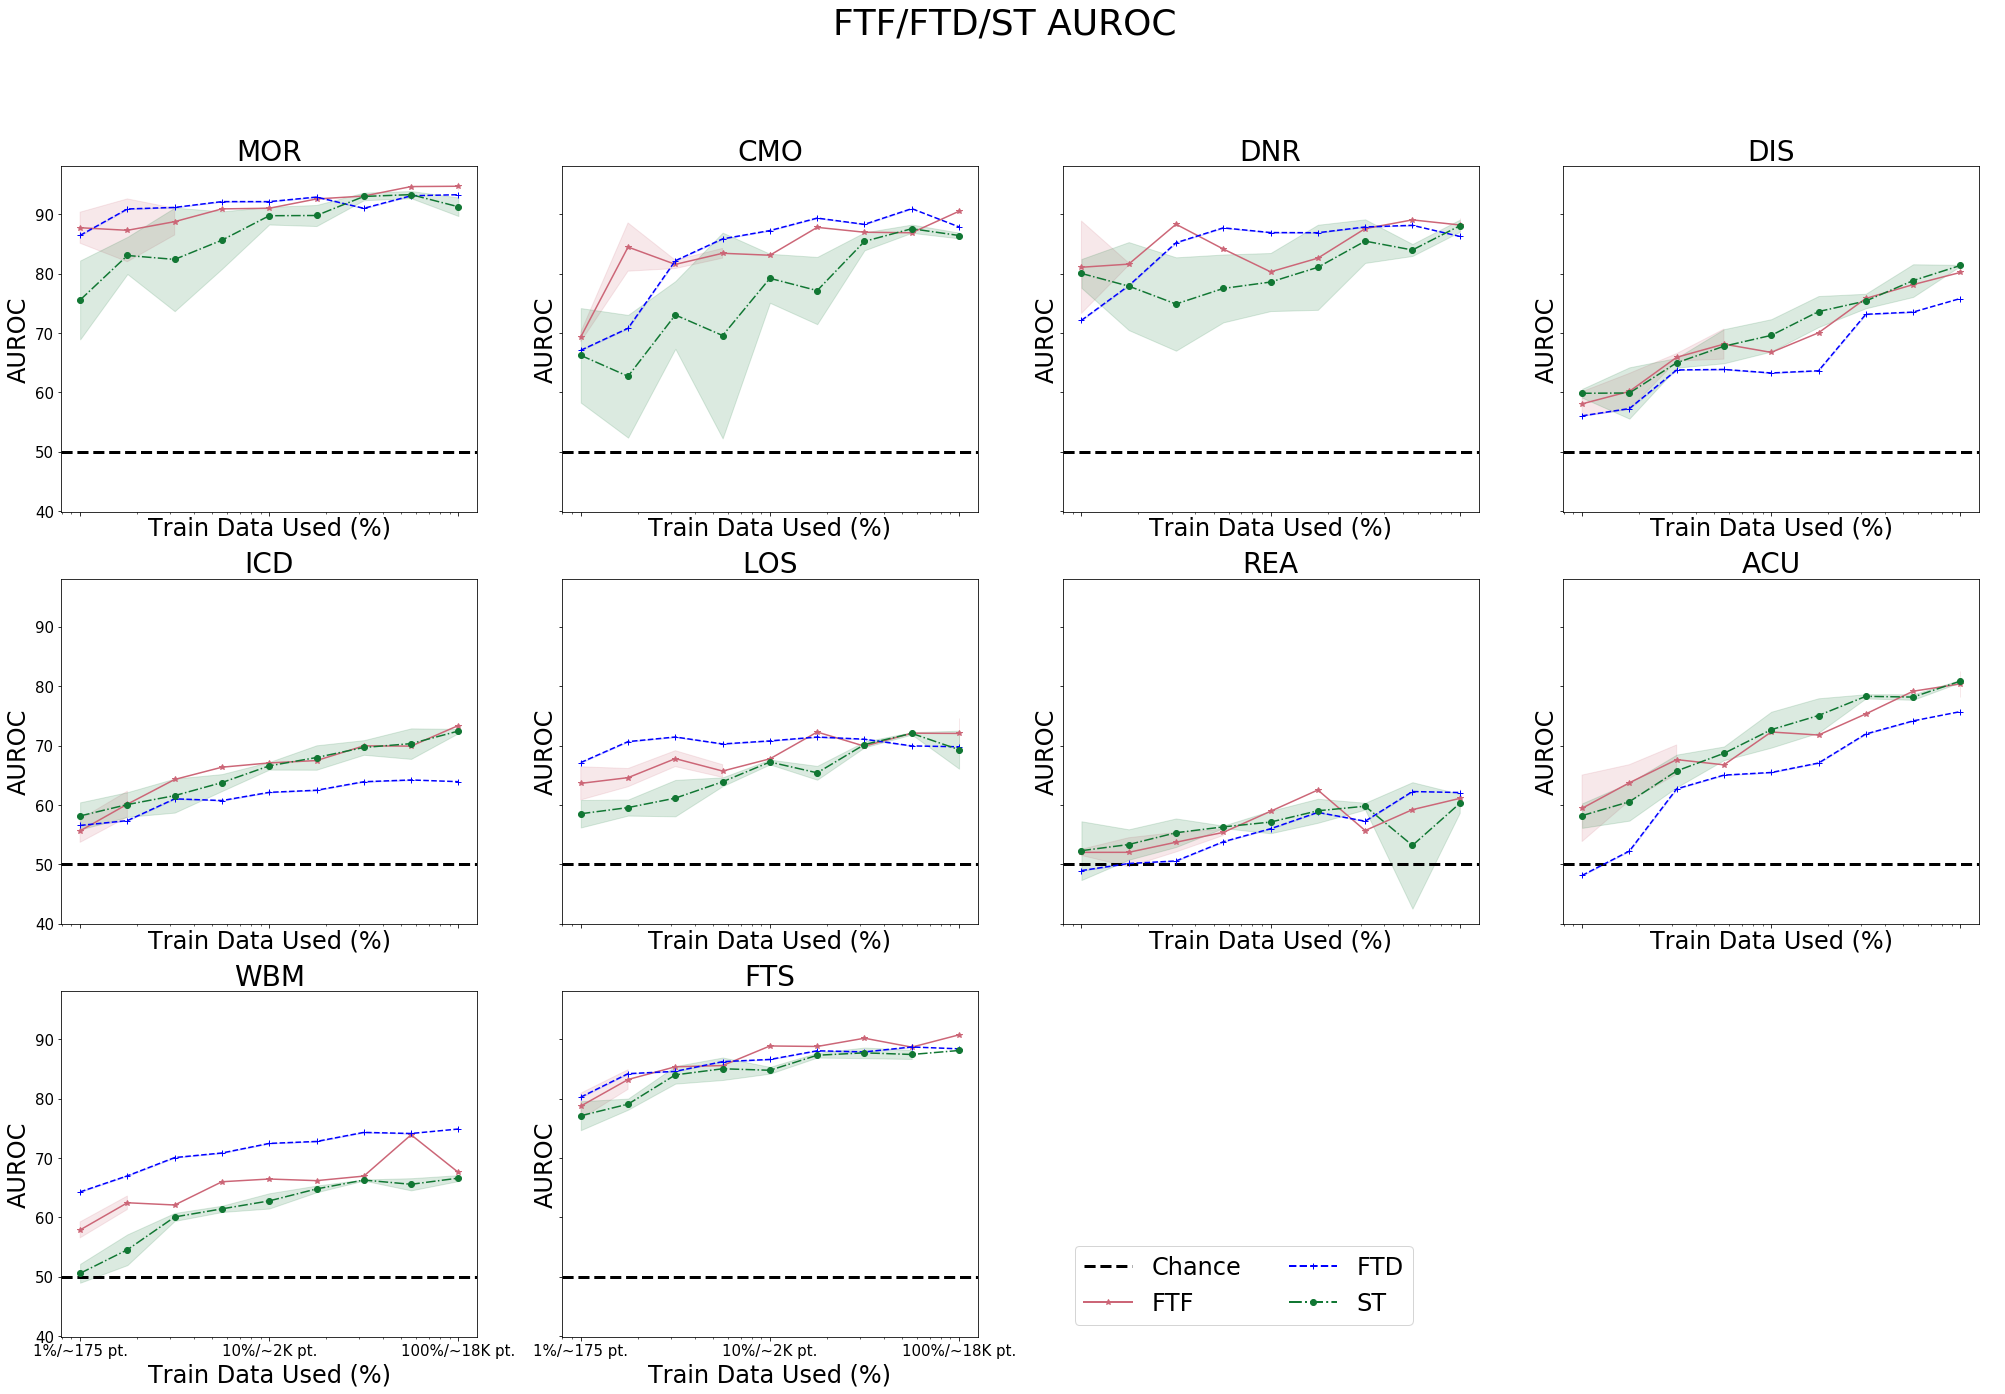

<Figure size 2016x1512 with 0 Axes>

In [318]:
plot_rest_data_line(
    {'ST': single_task_small_data_self_attention.loc[0.01:], 'FTD': small_data_self_attention.loc[0.01:], 'FTF': small_data_full_self_attention.loc[0.01:]},
    baseline = None,
    full_data_runs_by_training_mode={
        'ST': single_task_self_attention, 'FTD': fine_tune_self_attention, 'FTF': fine_tune_full_self_attention
    }, W = 4
)

In [319]:
old = pd.options.display.max_columns
pd.options.display.max_columns = None
display(num_samples_self_attention)
pd.options.display.max_columns = old

MT   ST  FTD  FTF          ST                                      \
    Orig Orig Orig Orig %: 2.90e-04 %: 1.00e-03 %: 3.16e-03 %: 5.62e-03   
MOR    7    2    1    3           4           4           3           3   
CMO    7    2    1    2           2           3           4           4   
DNR    7    2    1    3           3           4           3           3   
ICD    7    2    1    3           3           4           3           3   
LOS    7    2    1    3           3           3           4           3   
REA    7    2    1    3           4           3           5           4   
DIS    7    2    1    3           4           3           4           4   
ACU    7    2    1    3           3           4           4           4   
WBM    7    2    1    2           3           4           3           4   
FTS    7    1    1    3           3           3           3           3   

                                                                             \
    %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02 %: 1.00e-01 %: 1.78e-01   
MOR           3           3           3           3           3           3   
CMO           4           4           4           4           3           3   
DNR           3           3           3           3           3           2   
ICD           3           3           3           3           3           4   
LOS           3           3           3           3           3           2   
REA           4           4           4           4           4           4   
DIS           3           3           3           3           3           4   
ACU           4           4           4           4           4           5   
WBM           3           3           3           3           3           5   
FTS           3           3           3           3           3           3   

                                    FTD                                      \
    %: 3.16e-01 %: 5.62e-01 %: 2.90e-04 %: 1.00e-03 %: 3.16e-03 %: 5.62e-03   
MOR           2           3           1           1           1           1   
CMO           3           2           1           1           1           1   
DNR           3           2           1           1           1           1   
ICD           4           2           1           1           1           1   
LOS           2           2           1           1           1           1   
REA           2           2           1           1           1           1   
DIS           3           2           1           1           1           1   
ACU           2           2           1           1           1           1   
WBM           3           3           1           1           1           1   
FTS           3           3           1           1           1           1   

                                                                             \
    %: 1.00e-02 %: 1.78e-02 %: 3.16e-02 %: 5.62e-02 %: 1.00e-01 %: 1.78e-01   
MOR           1           1           1           1           1           1   
CMO           1           1           1           1           1           1   
DNR           1           1           1           1           1           1   
ICD           1           1           1           1           1           1   
LOS           1           1           1           1           1           1   
REA           1           1           1           1           1           1   
DIS           1           1           1           1           1           1   
ACU           1           1           1           1           1           1   
WBM           1           1           1           1           1           1   
FTS           1           1           1           1           1           1   

                                    FTF                                      \
    %: 3.16e-01 %: 5.62e-01 %: 1.00e-03 %: 3.16e-03 %: 5.62e-03 %: 1.00e-02   
MOR           1           1           3           3           3           3   
CMO           1      

In [320]:
num_samples_display_cols(num_samples_self_attention)

MT        ST       FTD       FTF ST Few-Shot %                      \
    Full-data Full-data Full-data Full-data           0.0 0.1 0.3 0.6 1.0 1.8   
MOR         7         2         1         3             4   4   3   3   3   3   
CMO         7         2         1         2             2   3   4   4   4   4   
DNR         7         2         1         3             3   4   3   3   3   3   
ICD         7         2         1         3             3   4   3   3   3   3   
LOS         7         2         1         3             3   3   4   3   3   3   
REA         7         2         1         3             4   3   5   4   4   4   
DIS         7         2         1         3             4   3   4   4   3   3   
ACU         7         2         1         3             3   4   4   4   4   4   
WBM         7         2         1         2             3   4   3   4   3   3   
FTS         7         1         1         3             3   3   3   3   3   3   

                                FTD Few-Shot %                              \
    3.2 5.6 10.0 17.8 31.6 56.2            0.0 0.1 0.3 0.6 1.0 1.8 3.2 5.6   
MOR   3   3    3    3    2    3              1   1   1   1   1   1   1   1   
CMO   4   4    3    3    3    2              1   1   1   1   1   1   1   1   
DNR   3   3    3    2    3    2              1   1   1   1   1   1   1   1   
ICD   3   3    3    4    4    2              1   1   1   1   1   1   1   1   
LOS   3   3    3    2    2    2              1   1   1   1   1   1   1   1   
REA   4   4    4    4    2    2              1   1   1   1   1   1   1   1   
DIS   3   3    3    4    3    2              1   1   1   1   1   1   1   1   
ACU   4   4    4    5    2    2              1   1   1   1   1   1   1   1   
WBM   3   3    3    5    3    3              1   1   1   1   1   1   1   1   
FTS   3   3    3    3    3    3              1   1   1   1   1   1   1   1   

                        FTF Few-Shot %                                         \
    10.0 17.8 31.6 56.2            0.1 0.3 0.6 1.0 1.8 3.2 5.6 10.0 17.8 31.6   
MOR    1    1    1    1              3   3   3   3   2   2   1    1    1    1   
CMO    1    1    1    1              2   2   2   2   2   2   2    1    1    1   
DNR    1    1    1    1              3   3   3   2   2   1   1    1    1    1   
ICD    1    1    1    1              3   3   3   3   2   1   1    1    1    1   
LOS    1    1    1    1              3   3   3   3   3   2   2    1    1    1   
REA    1    1    1    1              3   3   3   3   3   2   2    1    1    1   
DIS    1    1    1    1              3   3   3   3   2   2   2    1    1    1   
ACU    1    1    1    1              3   3   3   3   3   2   1    1    1    1   
WBM    1    1    1    1              2   2   2   2   2   1   1    1    1    1   
FTS    1    1    1    1              3   3   3   3   2   1   1    1    1    1   

                  ST         FTD         FTF  
    56.2 % Female: ? % Female: ? % Female: ?  
MOR    1           0           0           0  
CMO    1           0           0           0  
DNR    1           0           0           0  
ICD    1           0           0           0  
LOS    1           0           0           0  
REA    1           0           0           0  
DIS    1           0           0           0  
ACU    1           0           0           0  
WBM    1           0           0           0  
FTS    1           0           0           0

In [321]:
display(num_samples_self_attention[[c for c in num_samples_self_attention.columns if 'emale' not in c[1] and c[1] != '0.0']])

MT        ST       FTD       FTF ST Few-Shot %                      \
    Full-data Full-data Full-data Full-data           0.1 0.3 0.6 1.0 1.8 3.2   
MOR         7         2         1         3             4   3   3   3   3   3   
CMO         7         2         1         2             3   4   4   4   4   4   
DNR         7         2         1         3             4   3   3   3   3   3   
ICD         7         2         1         3             4   3   3   3   3   3   
LOS         7         2         1         3             3   4   3   3   3   3   
REA         7         2         1         3             3   5   4   4   4   4   
DIS         7         2         1         3             3   4   4   3   3   3   
ACU         7         2         1         3             4   4   4   4   4   4   
WBM         7         2         1         2             4   3   4   3   3   3   
FTS         7         1         1         3             3   3   3   3   3   3   

                            FTD Few-Shot %                                    \
    5.6 10.0 17.8 31.6 56.2            0.1 0.3 0.6 1.0 1.8 3.2 5.6 10.0 17.8   
MOR   3    3    3    2    3              1   1   1   1   1   1   1    1    1   
CMO   4    3    3    3    2              1   1   1   1   1   1   1    1    1   
DNR   3    3    2    3    2              1   1   1   1   1   1   1    1    1   
ICD   3    3    4    4    2              1   1   1   1   1   1   1    1    1   
LOS   3    3    2    2    2              1   1   1   1   1   1   1    1    1   
REA   4    4    4    2    2              1   1   1   1   1   1   1    1    1   
DIS   3    3    4    3    2              1   1   1   1   1   1   1    1    1   
ACU   4    4    5    2    2              1   1   1   1   1   1   1    1    1   
WBM   3    3    5    3    3              1   1   1   1   1   1   1    1    1   
FTS   3    3    3    3    3              1   1   1   1   1   1   1    1    1   

              FTF Few-Shot %                                              
    31.6 56.2            0.1 0.3 0.6 1.0 1.8 3.2 5.6 10.0 17.8 31.6 56.2  
MOR    1    1              3   3   3   3   2   2   1    1    1    1    1  
CMO    1    1              2   2   2   2   2   2   2    1    1    1    1  
DNR    1    1              3   3   3   2   2   1   1    1    1    1    1  
ICD    1    1              3   3   3   3   2   1   1    1    1    1    1  
LOS    1    1              3   3   3   3   3   2   2    1    1    1    1  
REA    1    1              3   3   3   3   3   2   2    1    1    1    1  
DIS    1    1              3   3   3   3   2   2   2    1    1    1    1  
ACU    1    1              3   3   3   3   3   2   1    1    1    1    1  
WBM    1    1              2   2   2   2   2   1   1    1    1    1    1  
FTS    1    1              3   3   3   3   2   1   1    1    1    1    1

In [309]:
print(num_samples_self_attention[[c for c in num_samples_self_attention.columns if 'emale' not in c[1] and c[1] != '0.0']].to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &        MT &        ST &       FTD &       FTF & \multicolumn{11}{l}{ST Few-Shot \%} & \multicolumn{11}{l}{FTD Few-Shot \%} & \multicolumn{11}{l}{FTF Few-Shot \%} \\
{} & Full-data & Full-data & Full-data & Full-data &           0.1 & 0.3 & 0.6 & 1.0 & 1.8 & 3.2 & 5.6 & 10.0 & 17.8 & 31.6 & 56.2 &            0.1 & 0.3 & 0.6 & 1.0 & 1.8 & 3.2 & 5.6 & 10.0 & 17.8 & 31.6 & 56.2 &            0.1 & 0.3 & 0.6 & 1.0 & 1.8 & 3.2 & 5.6 & 10.0 & 17.8 & 31.6 & 56.2 \\
\midrule
MOR &         7 &         2 &         1 &         3 &             4 &   3 &   3 &   3 &   3 &   3 &   3 &    3 &    3 &    2 &    3 &              1 &   1 &   1 &   1 &   1 &   1 &   1 &    1 &    1 &    1 &    1 &              3 &   3 &   3 &   3 &   2 &   2 &   1 &    1 &    1 &    1 &    1 \\
CMO &         7 &         2 &         1 &         2 &             3 &   4 &   4 &   4 &   4 &   4 &   4 &    3 &    3 &    3 &    2 &              1 &   1 &   1 & 